In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import matplotlib.pyplot as plt
import warnings
from random import sample
warnings.filterwarnings('ignore')
%matplotlib notebook

# Cart Pole balance using Deep Q Learning with Experience Replay and Target Network

#### Please Note:
Uncomment and run the immediate below cell only if you want to check what the output would be with an agent taking random actions as jupyter notebook does not handle this functionality well and your kernel might die and you might have to restart it hence run the below cell separate from the rest of the code cells if running,you might also have to manually quit the file that remains open even after the video has stopped playing(noticed on a macbook).

In [ ]:
# Uncomment the below code to define an agent to take random actions and check output
'''env=gym.make('CartPole-v1')
done=False
observation=env.reset()
while not done:
    env.render()
    observation,reward,done,info=env.step(env.action_space.sample())
env.close()'''

In [10]:
##Choice of the architecture of the Deep Q Network and the learning rate make a big difference in the learning process
##Choose 3 fully connected networks with 4->64->128->2 output with Adam and learning rate as 0.0001
##Seems to work well with 2 hidden layers and performance deteriorates when the hidden layer is increased by 1.

##Define the environment and other parameters
env=gym.make('CartPole-v1')
nGames=1000
scores=[]
averageScore=[]
##Define the Q network
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.fc1=nn.Linear(*observationSpace,64)
        self.fc2=nn.Linear(64,128)
        self.fc3=nn.Linear(128,actionSpace)
    def forward(self,observation):
        output=F.relu(self.fc1(observation))
        output=F.relu(self.fc2(output))
        output=self.fc3(output)
        return output
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
##Instantiate the Q network and the target network
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
QTarget=QNetwork(env.observation_space.shape,env.action_space.n)
Qupdate.to(device)
QTarget.to(device)
##Define the loss function
criterion=nn.MSELoss()
##Define the optimizer
optimizer=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
##Define parameters for experience replay
memorySize=50000
batchSize=16
indices=[i for i in range(batchSize)]
replayMemory=[0 for i in range(memorySize)]
##Define parameters for policy
epsilon=1
epsilonDec=1e-4
epsilonMin=0.01
gamma=0.99
memoryCounter=0
counter=0
replace=4
##Decrement the epsilon value
def decrementEpsilon(epsilon,epsilonDec,epsilonMin):
    if epsilon>epsilonMin:
        epsilon-=epsilonDec
    else:
        epsilon=epsilonMin
    return epsilon
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        ##Epsilon greedy action selection
        if np.random.random()>epsilon:
            with torch.no_grad():
                action=Qupdate(torch.Tensor(observation).to(device))
                action=torch.argmax(action).item()
        else:
            action=env.action_space.sample()
        ##Perform the selected action
        newObservation,reward,done,info=env.step(action)
        ##Store the parameters in memory using dictionary for fast access
        index=memoryCounter%memorySize
        d=dict()
        d['observation']=observation
        d['newObservation']=newObservation
        d['reward']=reward
        d['done']=done
        d['action']=action
        replayMemory[index]=d
        totalReward+=reward
        memoryCounter+=1
        ##Only start the training process if the memory has atleast batchsize number of samples
        if memoryCounter>=batchSize:
            ##Make sure to clear the optimizer
            optimizer.zero_grad()
            ##Replace the target network weights every 'replace' steps
            if counter%replace==0:
                QTarget.load_state_dict(Qupdate.state_dict())
            if memoryCounter<=memorySize:
                maxMem=memoryCounter
            else:
                maxMem=memorySize
            ##Randomly sample indices at uniform and select from experience replay
            numbers=[i for i in range(maxMem)]
            sampleIndices=sample(numbers,batchSize)
            sampledObservations=list()
            sampledNewObservations=list()
            sampledrewards=list()
            sampledActions=list()
            sampledTerminalStates=list()
            for ele in sampleIndices:
                sampledObservations.append(replayMemory[ele]['observation'])
                sampledNewObservations.append(replayMemory[ele]['newObservation'])
                sampledrewards.append(replayMemory[ele]['reward'])
                sampledTerminalStates.append(replayMemory[ele]['done'])
                sampledActions.append(replayMemory[ele]['action'])
            ##Calculate the Q value for all actions in the batch
            batchQValue=Qupdate(torch.Tensor(sampledObservations).to(device))
            qValueCurrentState=torch.empty(batchSize).to(device)
            ##Calculate the target Q value using the target network
            qValueNextState=torch.max(QTarget(torch.Tensor(sampledNewObservations).to(device)),1)[0]
            ##Set target Q value of terminal states as 0 and also select actions from the update Q value
            for j in range(batchSize):
                if sampledTerminalStates[j] is True:
                    qValueNextState[j]=0.0
                qValueCurrentState[j]=batchQValue[j][sampledActions[j]]
            ##Calculate the target value
            y=(torch.Tensor(sampledrewards).to(device)+gamma*qValueNextState).detach()
            ##Calculate the loss
            loss=criterion(y,qValueCurrentState).to(device)
            ##Calculate the derivatives
            loss.backward()
            ##Take one step of gradiet descent 
            optimizer.step()
            ##Decrement epsilon
            epsilon=decrementEpsilon(epsilon,epsilonDec,epsilonMin)
            counter+=1
        observation=newObservation
    scores.append(totalReward)
    if i%100==0:
        averageScore.append(np.mean(scores[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scores[-100:]):.2f},score {totalReward:.2f},epsilon {epsilon:.2f}')
        
        

epsiode 0,Average Score 43.00,score 43.00,epsilon 1.00
epsiode 100,Average Score 19.60,score 17.00,epsilon 0.80
epsiode 200,Average Score 30.90,score 35.00,epsilon 0.49
epsiode 300,Average Score 84.32,score 226.00,epsilon 0.01
epsiode 400,Average Score 388.07,score 332.00,epsilon 0.01
epsiode 500,Average Score 344.92,score 472.00,epsilon 0.01
epsiode 600,Average Score 417.03,score 431.00,epsilon 0.01
epsiode 700,Average Score 496.09,score 500.00,epsilon 0.01
epsiode 800,Average Score 500.00,score 500.00,epsilon 0.01
epsiode 900,Average Score 499.07,score 500.00,epsilon 0.01


In [ ]:
##Choice of the architecture of the Deep Q Network and the learning rate make a big difference in the learning process
##Choose 3 fully connected networks with 4->64->128->2 output with Adam and learning rate as 0.0001
##Seems to work well with 2 hidden layers and performance deteriorates when the hidden layer is increased by 1.

##Define the environment and other parameters
env=gym.make('CartPole-v1')
nGames=1000
scores=[]
averageScore=[]
##Define the Q network
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.fc1=nn.Linear(*observationSpace,64)
        self.fc2=nn.Linear(64,128)
        self.fc3=nn.Linear(128,actionSpace)
    def forward(self,observation):
        output=F.relu(self.fc1(observation))
        output=F.relu(self.fc2(output))
        output=self.fc3(output)
        return output
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
##Instantiate the Q network and the target network
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
QTarget=QNetwork(env.observation_space.shape,env.action_space.n)
Qupdate.to(device)
QTarget.to(device)
##Define the loss function
criterion=nn.MSELoss()
##Define the optimizer
optimizer=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
##Define parameters for experience replay
memorySize=50000
batchSize=16
indices=[i for i in range(batchSize)]
replayMemory=[0 for i in range(memorySize)]
##Define parameters for policy
epsilon=1
epsilonDec=1e-4
epsilonMin=0.01
gamma=0.99
memoryCounter=0
counter=0
replace=4
##Decrement the epsilon value
def decrementEpsilon(epsilon,epsilonDec,epsilonMin):
    if epsilon>epsilonMin:
        epsilon-=epsilonDec
    else:
        epsilon=epsilonMin
    return epsilon
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        ##Epsilon greedy action selection
        if np.random.random()>epsilon:
            with torch.no_grad():
                action=Qupdate(torch.Tensor(observation).to(device))
                action=torch.argmax(action).item()
        else:
            action=env.action_space.sample()
        ##Perform the selected action
        newObservation,reward,done,info=env.step(action)
        ##Store the parameters in memory using dictionary for fast access
        index=memoryCounter%memorySize
        d=dict()
        d['observation']=observation
        d['newObservation']=newObservation
        d['reward']=reward
        d['done']=done
        d['action']=action
        replayMemory[index]=d
        totalReward+=reward
        memoryCounter+=1
        ##Only start the training process if the memory has atleast batchsize number of samples
        if memoryCounter>=batchSize:
            ##Make sure to clear the optimizer
            optimizer.zero_grad()
            ##Replace the target network weights every 'replace' steps
            if counter%replace==0:
                QTarget.load_state_dict(Qupdate.state_dict())
            if memoryCounter<=memorySize:
                maxMem=memoryCounter
            else:
                maxMem=memorySize
            ##Randomly sample indices at uniform and select from experience replay
            numbers=[i for i in range(maxMem)]
            sampleIndices=sample(numbers,batchSize)
            sampledObservations=list()
            sampledNewObservations=list()
            sampledrewards=list()
            sampledActions=list()
            sampledTerminalStates=list()
            for ele in sampleIndices:
                sampledObservations.append(replayMemory[ele]['observation'])
                sampledNewObservations.append(replayMemory[ele]['newObservation'])
                sampledrewards.append(replayMemory[ele]['reward'])
                sampledTerminalStates.append(replayMemory[ele]['done'])
                sampledActions.append(replayMemory[ele]['action'])
            ##Calculate the Q value for all actions in the batch
            batchQValue=Qupdate(torch.Tensor(sampledObservations).to(device))
            qValueCurrentState=torch.empty(batchSize).to(device)
            ##Calculate the target Q value using the target network
            qValueNextState=torch.max(QTarget(torch.Tensor(sampledNewObservations).to(device)),1)[0]
            ##Set target Q value of terminal states as 0 and also select actions from the update Q value
            for j in range(batchSize):
                if sampledTerminalStates[j] is True:
                    qValueNextState[j]=0.0
                qValueCurrentState[j]=batchQValue[j][sampledActions[j]]
            ##Calculate the target value
            y=(torch.Tensor(sampledrewards).to(device)+gamma*qValueNextState).detach()
            ##Calculate the loss
            loss=criterion(y,qValueCurrentState).to(device)
            ##Calculate the derivatives
            loss.backward()
            ##Take one step of gradiet descent 
            optimizer.step()
            ##Decrement epsilon
            epsilon=decrementEpsilon(epsilon,epsilonDec,epsilonMin)
            counter+=1
        observation=newObservation
    scores.append(totalReward)
    if i%100==0:
        averageScore.append(np.mean(scores[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scores[-100:]):.2f},score {totalReward:.2f},epsilon {epsilon:.2f}')
        
        

epsiode 0,Average Score 22.00,score 22.00,epsilon 1.00
epsiode 100,Average Score 20.51,score 18.00,epsilon 0.79
epsiode 200,Average Score 38.08,score 77.00,epsilon 0.41


## Please Note:
The x-axis for all the average score graph henceforth must be interpreted by weighting each value by 100,in other words if the x axis in the graph has a value of 5 then please take it as the 500th episode and not the 5th episode and similarly for other values.

<IPython.core.display.Javascript object>


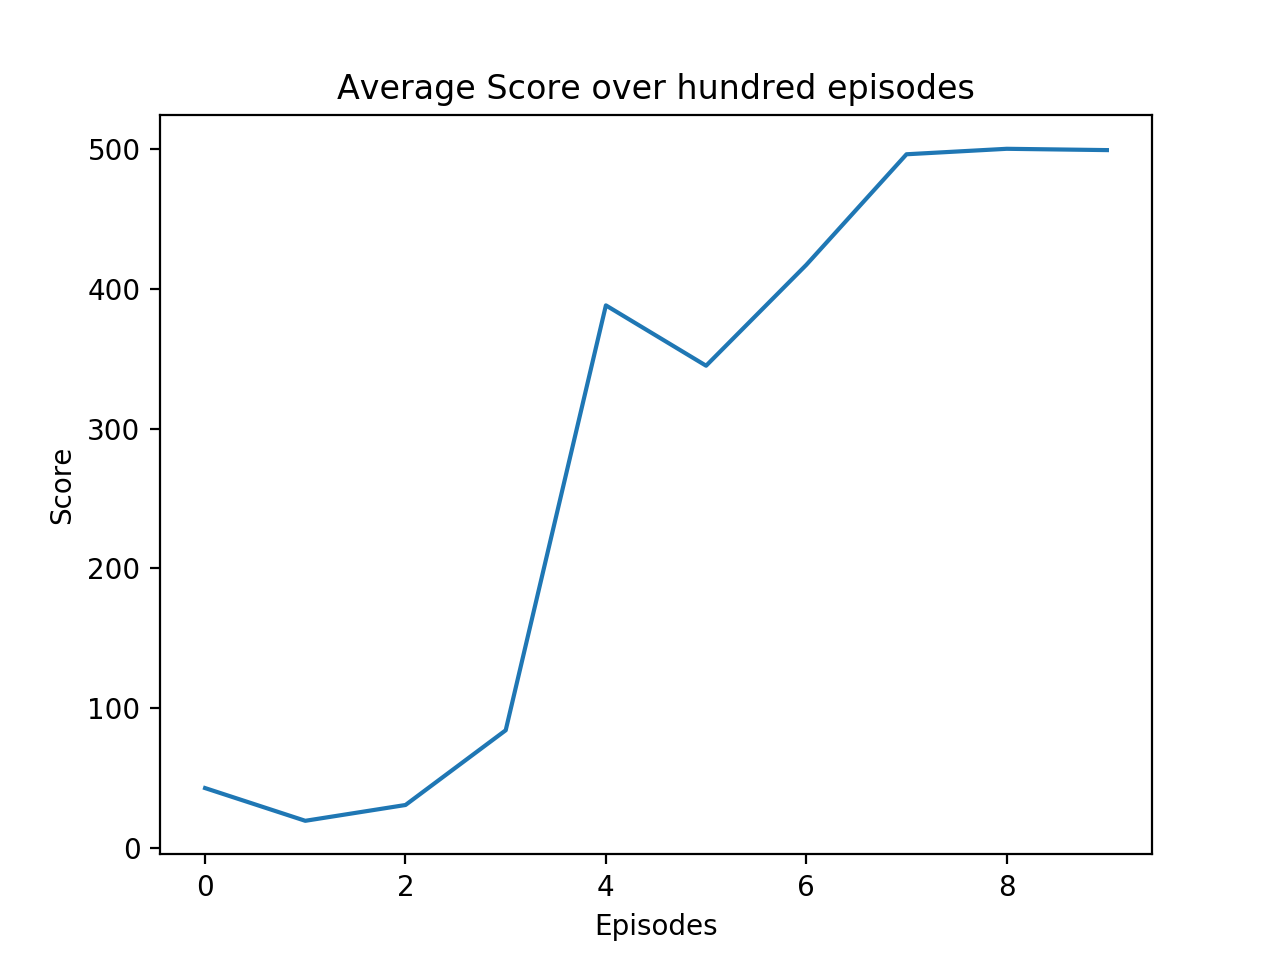

<IPython.core.display.Javascript object>


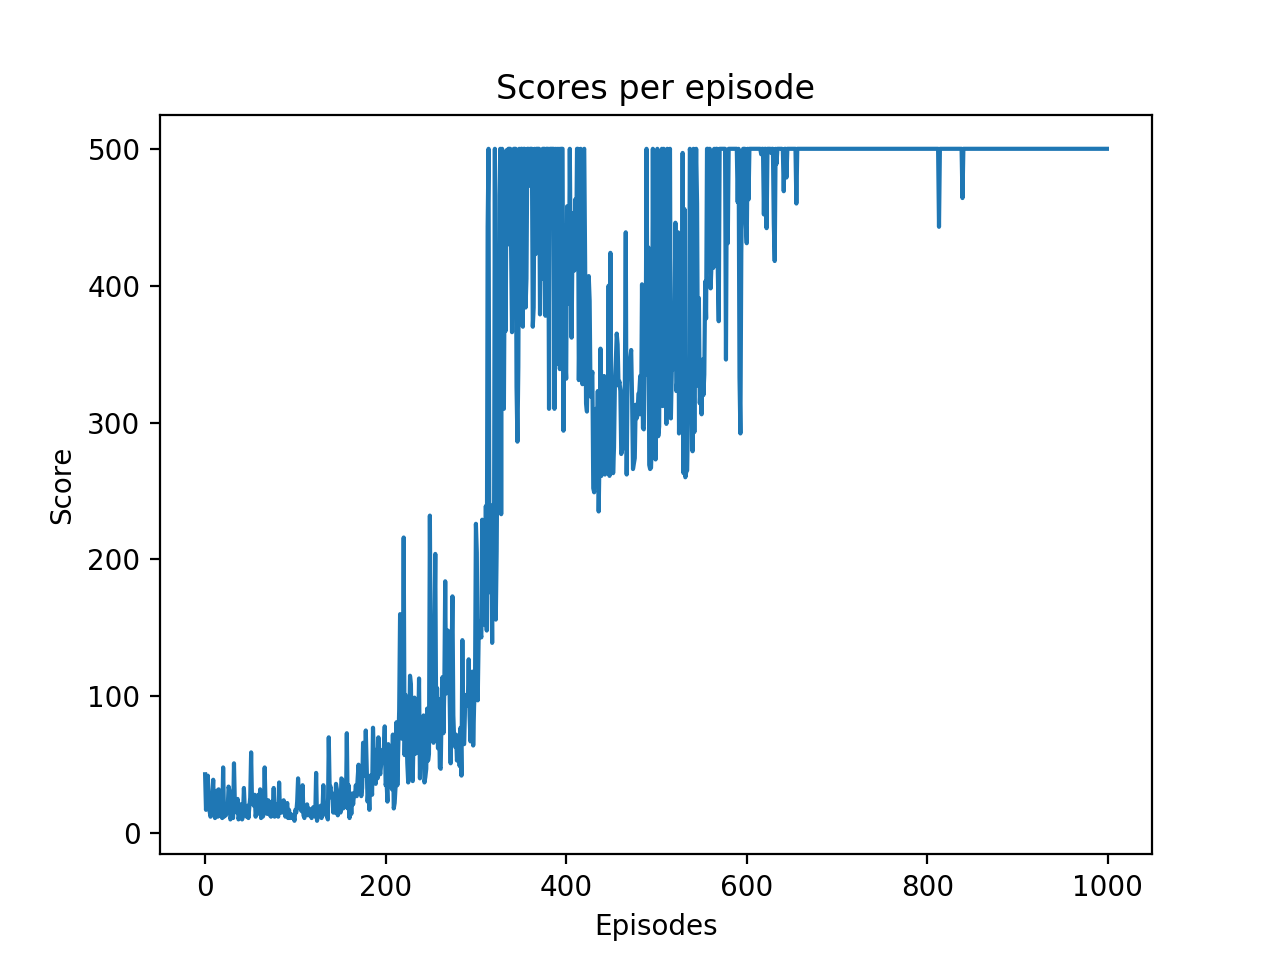

Text(0.5,1,'Scores per episode')

In [11]:
%matplotlib notebook
plt.figure()
plt.plot(averageScore)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.figure()
plt.plot(scores)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per episode')

In [12]:
PATH = './cartpolenogradupdate.pth'
torch.save(Qupdate.state_dict(), PATH)

PATH = './cartpolenogradtarget.pth'
torch.save(QTarget.state_dict(), PATH)

# Mountain Car with Deep Q Learning using Experience Replay and Target Network

In [ ]:
##By making minimal changes to the above code(change made only by increasing one layer in the deep Q network) 
##Try and solve other discrete action environments provided by OpenAI gym

##GOAL-Try and get the car to the top of the valley,environment considered solved when we get a score of less than -110

In [2]:
env=gym.make('MountainCar-v0')
nGames=2500
scores=[]
averageScore=[]
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.fc1=nn.Linear(*observationSpace,64)
        self.fc2=nn.Linear(64,128)
        self.fc3=nn.Linear(128,256)
        self.fc4=nn.Linear(256,actionSpace)
    def forward(self,observation):
        output=F.relu(self.fc1(observation))
        output=F.relu(self.fc2(output))
        output=F.relu(self.fc3(output))
        output=self.fc4(output)
        return output
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
QTarget=QNetwork(env.observation_space.shape,env.action_space.n)
Qupdate.to(device)
QTarget.to(device)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
memorySize=50000
batchSize=16
indices=[i for i in range(batchSize)]
replayMemory=[0 for i in range(memorySize)]
epsilon=1
epsilonDec=1e-5
epsilonMin=0.01
gamma=0.99
memoryCounter=0
counter=0
replace=4
def decrementEpsilon(epsilon,epsilonDec,epsilonMin):
    if epsilon>epsilonMin:
        epsilon-=epsilonDec
    else:
        epsilon=epsilonMin
    return epsilon
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        if np.random.random()>epsilon:
            with torch.no_grad():
                action=Qupdate(torch.Tensor(observation).to(device))
                action=torch.argmax(action).item()
        else:
            action=env.action_space.sample()
        newObservation,reward,done,info=env.step(action)
        index=memoryCounter%memorySize
        d=dict()
        d['observation']=observation
        d['newObservation']=newObservation
        d['reward']=reward
        d['done']=done
        d['action']=action
        replayMemory[index]=d
        totalReward+=reward
        memoryCounter+=1
        if memoryCounter>=batchSize:
            optimizer.zero_grad()
            if counter%replace==0:
                QTarget.load_state_dict(Qupdate.state_dict())
            if memoryCounter<=memorySize:
                maxMem=memoryCounter
            else:
                maxMem=memorySize
            numbers=[i for i in range(maxMem)]
            sampleIndices=sample(numbers,batchSize)
            sampledObservations=list()
            sampledNewObservations=list()
            sampledrewards=list()
            sampledActions=list()
            sampledTerminalStates=list()
            for ele in sampleIndices:
                sampledObservations.append(replayMemory[ele]['observation'])
                sampledNewObservations.append(replayMemory[ele]['newObservation'])
                sampledrewards.append(replayMemory[ele]['reward'])
                sampledTerminalStates.append(replayMemory[ele]['done'])
                sampledActions.append(replayMemory[ele]['action'])
            batchQValue=Qupdate(torch.Tensor(sampledObservations).to(device))
            qValueCurrentState=torch.empty(batchSize).to(device)
            qValueNextState=torch.max(QTarget(torch.Tensor(sampledNewObservations).to(device)),1)[0]
            for j in range(batchSize):
                if sampledTerminalStates[j] is True:
                    qValueNextState[j]=0.0
                qValueCurrentState[j]=batchQValue[j][sampledActions[j]]
            y=(torch.Tensor(sampledrewards).to(device)+gamma*qValueNextState).detach()
            loss=criterion(y,qValueCurrentState).to(device)
            loss.backward()
            optimizer.step()
            epsilon=decrementEpsilon(epsilon,epsilonDec,epsilonMin)
            counter+=1
        observation=newObservation
    scores.append(totalReward)
    if i%100==0:
        averageScore.append(np.mean(scores[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scores[-100:]):.2f},score {totalReward:.2f},epsilon {epsilon:.2f}')
        
        

epsiode 0,Average Score -200.00,score -200.00,epsilon 1.00
epsiode 100,Average Score -200.00,score -200.00,epsilon 0.80
epsiode 200,Average Score -200.00,score -200.00,epsilon 0.60
epsiode 300,Average Score -200.00,score -200.00,epsilon 0.40
epsiode 400,Average Score -199.85,score -200.00,epsilon 0.20
epsiode 500,Average Score -198.14,score -200.00,epsilon 0.01
epsiode 600,Average Score -189.09,score -200.00,epsilon 0.01
epsiode 700,Average Score -191.66,score -200.00,epsilon 0.01
epsiode 800,Average Score -191.25,score -200.00,epsilon 0.01
epsiode 900,Average Score -186.00,score -200.00,epsilon 0.01
epsiode 1000,Average Score -161.55,score -113.00,epsilon 0.01
epsiode 1100,Average Score -162.71,score -200.00,epsilon 0.01
epsiode 1200,Average Score -152.12,score -200.00,epsilon 0.01
epsiode 1300,Average Score -142.52,score -156.00,epsilon 0.01
epsiode 1400,Average Score -142.50,score -148.00,epsilon 0.01
epsiode 1500,Average Score -137.41,score -83.00,epsilon 0.01
epsiode 1600,Average 

<IPython.core.display.Javascript object>


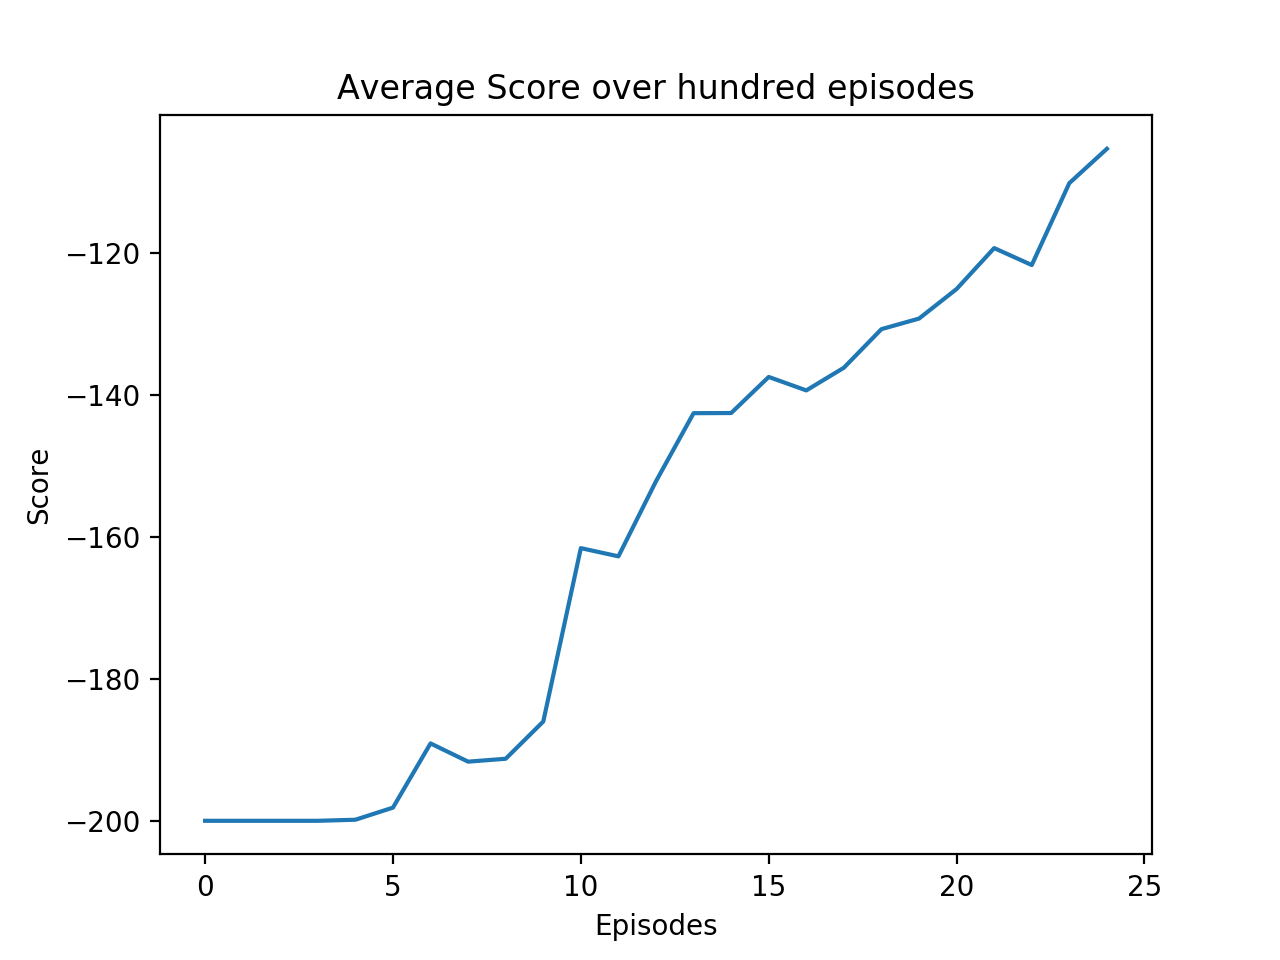

<IPython.core.display.Javascript object>


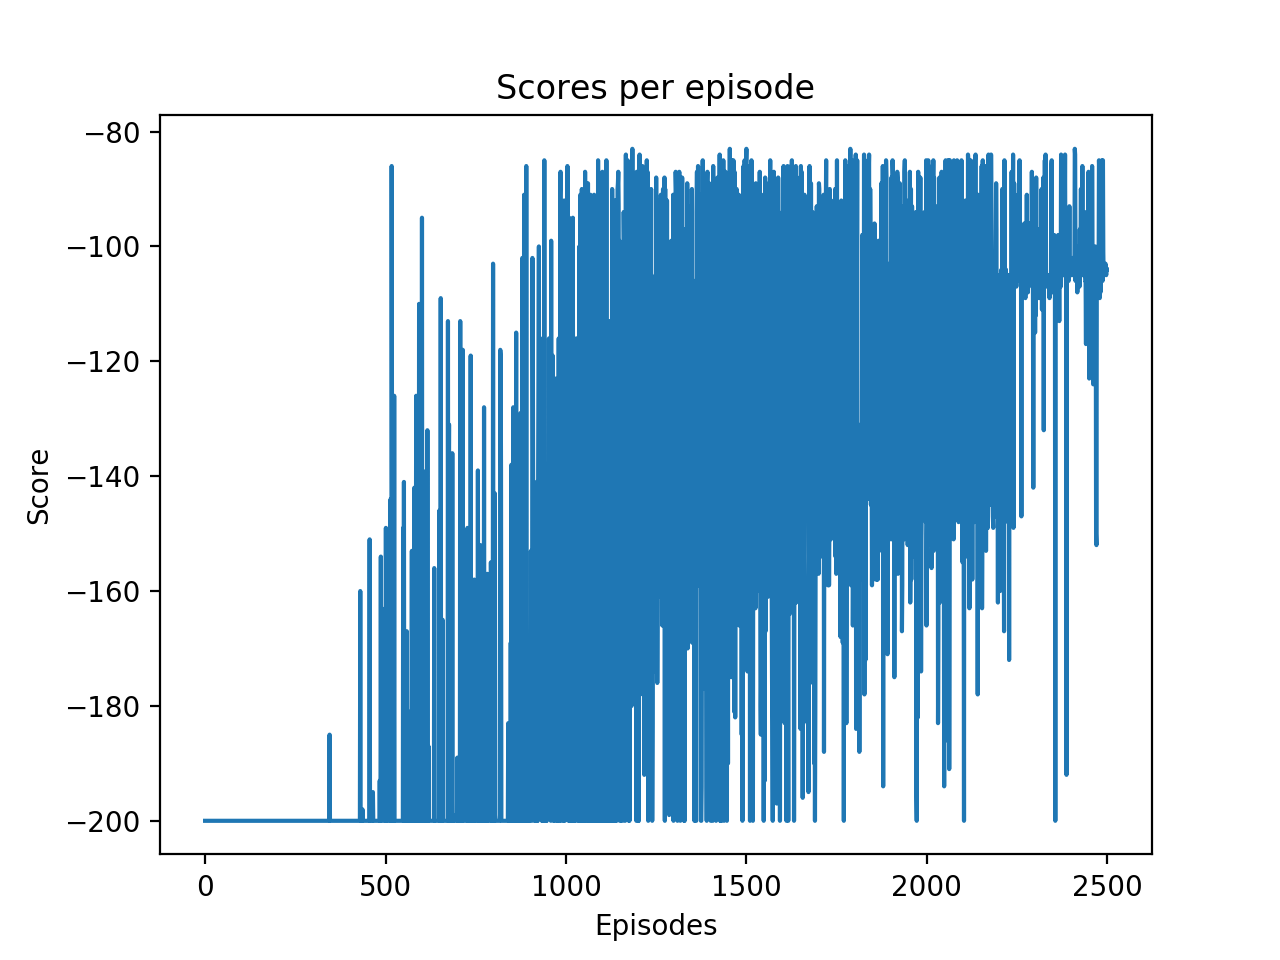

Text(0.5,1,'Scores per episode')

In [3]:
%matplotlib notebook
plt.figure()
plt.plot(averageScore)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.figure()
plt.plot(scores)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per episode')

In [4]:
PATH = './mountainCarNoGradUpdate.pth'
torch.save(Qupdate.state_dict(), PATH)

PATH = './mountainCarNoGradTarget.pth'
torch.save(QTarget.state_dict(), PATH)

# Lunar Lander Discrete Using Experience Replay and Target Network

In [ ]:
##Make no changes to the above code and simply change the environment to see if the same architecture performs well
##or not


##GOAL- Try to land the rocket in between the flags,environment considered solved when we get a score of above 200

In [5]:
env=gym.make('LunarLander-v2')
nGames=1500
scores=[]
averageScore=[]
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.fc1=nn.Linear(*observationSpace,64)
        self.fc2=nn.Linear(64,128)
        self.fc3=nn.Linear(128,256)
        self.fc4=nn.Linear(256,actionSpace)
    def forward(self,observation):
        output=F.relu(self.fc1(observation))
        output=F.relu(self.fc2(output))
        output=F.relu(self.fc3(output))
        output=self.fc4(output)
        return output
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
QTarget=QNetwork(env.observation_space.shape,env.action_space.n)
Qupdate.to(device)
QTarget.to(device)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
memorySize=50000
batchSize=16
indices=[i for i in range(batchSize)]
replayMemory=[0 for i in range(memorySize)]
epsilon=1
epsilonDec=1e-5
epsilonMin=0.01
gamma=0.99
memoryCounter=0
counter=0
replace=4
def decrementEpsilon(epsilon,epsilonDec,epsilonMin):
    if epsilon>epsilonMin:
        epsilon-=epsilonDec
    else:
        epsilon=epsilonMin
    return epsilon
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        if np.random.random()>epsilon:
            with torch.no_grad():
                action=Qupdate(torch.Tensor(observation).to(device))
                action=torch.argmax(action).item()
        else:
            action=env.action_space.sample()
        newObservation,reward,done,info=env.step(action)
        index=memoryCounter%memorySize
        d=dict()
        d['observation']=observation
        d['newObservation']=newObservation
        d['reward']=reward
        d['done']=done
        d['action']=action
        replayMemory[index]=d
        totalReward+=reward
        memoryCounter+=1
        if memoryCounter>=batchSize:
            optimizer.zero_grad()
            if counter%replace==0:
                QTarget.load_state_dict(Qupdate.state_dict())
            if memoryCounter<=memorySize:
                maxMem=memoryCounter
            else:
                maxMem=memorySize
            numbers=[i for i in range(maxMem)]
            sampleIndices=sample(numbers,batchSize)
            sampledObservations=list()
            sampledNewObservations=list()
            sampledrewards=list()
            sampledActions=list()
            sampledTerminalStates=list()
            for ele in sampleIndices:
                sampledObservations.append(replayMemory[ele]['observation'])
                sampledNewObservations.append(replayMemory[ele]['newObservation'])
                sampledrewards.append(replayMemory[ele]['reward'])
                sampledTerminalStates.append(replayMemory[ele]['done'])
                sampledActions.append(replayMemory[ele]['action'])
            batchQValue=Qupdate(torch.Tensor(sampledObservations).to(device))
            qValueCurrentState=torch.empty(batchSize).to(device)
            qValueNextState=torch.max(QTarget(torch.Tensor(sampledNewObservations).to(device)),1)[0]
            for j in range(batchSize):
                if sampledTerminalStates[j] is True:
                    qValueNextState[j]=0.0
                qValueCurrentState[j]=batchQValue[j][sampledActions[j]]
            y=(torch.Tensor(sampledrewards).to(device)+gamma*qValueNextState).detach()
            loss=criterion(y,qValueCurrentState).to(device)
            loss.backward()
            optimizer.step()
            epsilon=decrementEpsilon(epsilon,epsilonDec,epsilonMin)
            counter+=1
        observation=newObservation
    scores.append(totalReward)
    if i%100==0:
        averageScore.append(np.mean(scores[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scores[-100:]):.2f},score {totalReward:.2f},epsilon {epsilon:.2f}')
        
        

epsiode 0,Average Score -232.54,score -232.54,epsilon 1.00
epsiode 100,Average Score -177.39,score -194.39,epsilon 0.90
epsiode 200,Average Score -137.22,score -85.47,epsilon 0.80
epsiode 300,Average Score -88.76,score -86.03,epsilon 0.69
epsiode 400,Average Score -85.05,score -201.71,epsilon 0.54
epsiode 500,Average Score -55.74,score -25.82,epsilon 0.01
epsiode 600,Average Score 33.26,score 24.12,epsilon 0.01
epsiode 700,Average Score 52.83,score 126.22,epsilon 0.01
epsiode 800,Average Score 147.56,score 262.56,epsilon 0.01
epsiode 900,Average Score 164.25,score 232.83,epsilon 0.01
epsiode 1000,Average Score 166.47,score 184.35,epsilon 0.01
epsiode 1100,Average Score 221.80,score 221.75,epsilon 0.01
epsiode 1200,Average Score 235.05,score 250.09,epsilon 0.01
epsiode 1300,Average Score 215.21,score 197.19,epsilon 0.01
epsiode 1400,Average Score 239.62,score 282.78,epsilon 0.01


<IPython.core.display.Javascript object>


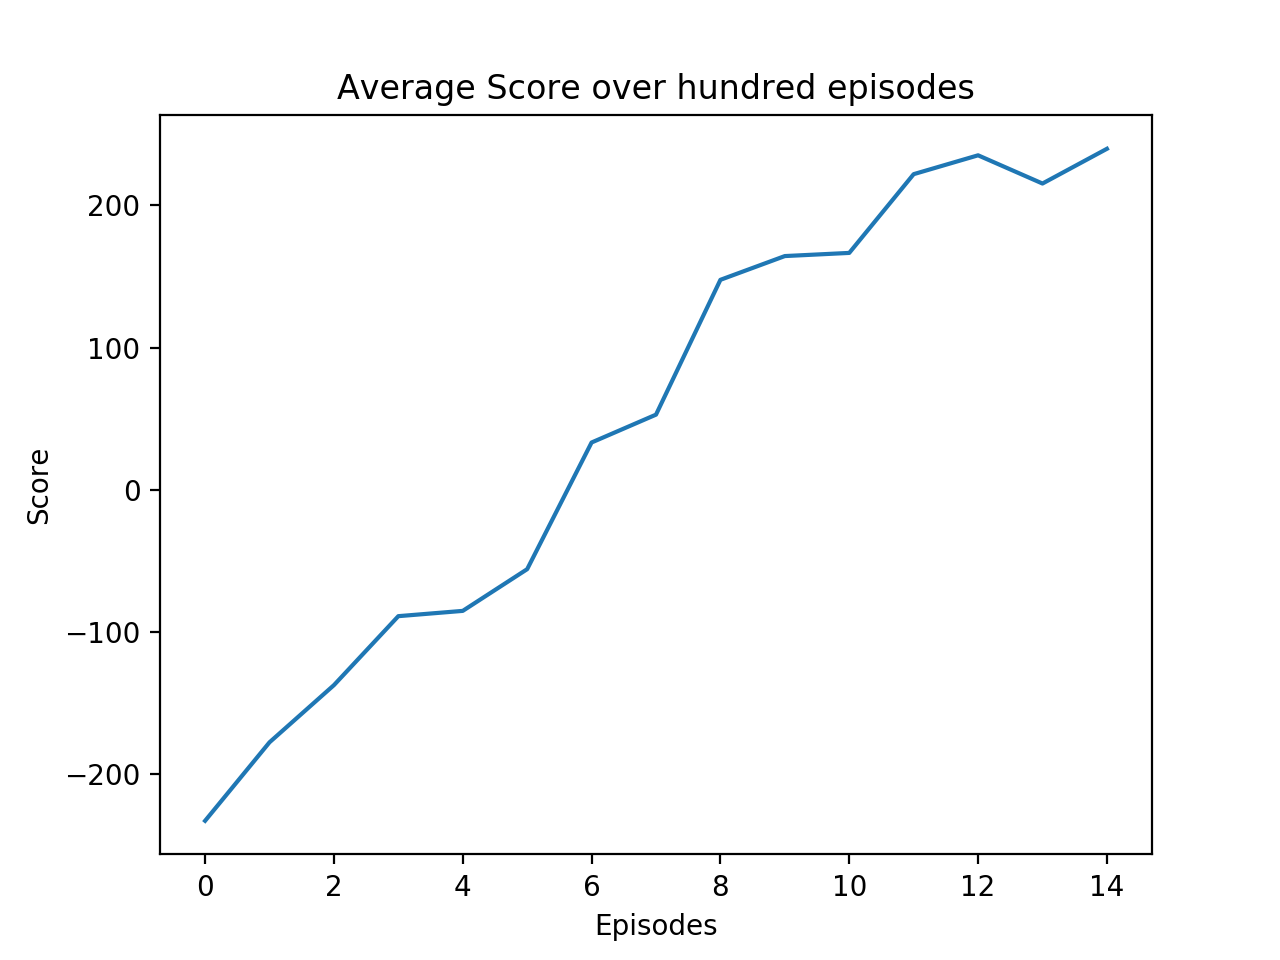

<IPython.core.display.Javascript object>


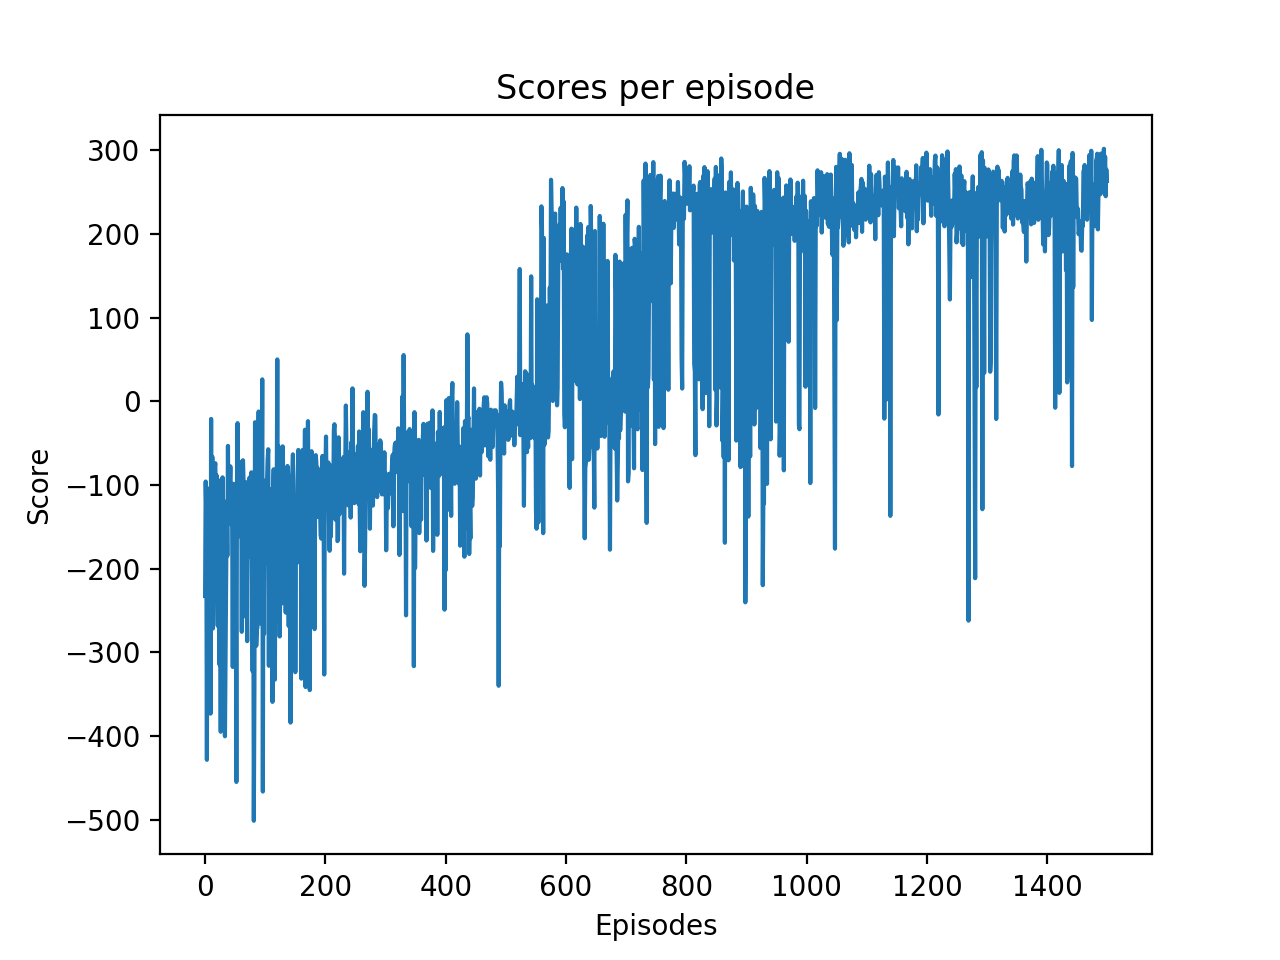

Text(0.5,1,'Scores per episode')

In [6]:
%matplotlib notebook
plt.figure()
plt.plot(averageScore)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.figure()
plt.plot(scores)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per episode')

In [7]:
PATH = './lunarlanderNoGradupdate.pth'
torch.save(Qupdate.state_dict(), PATH)

PATH = './lunarlanderNoGradTarget.pth'
torch.save(QTarget.state_dict(), PATH)

# Solving the Discrete Atari(pong) environment using Deep Q Learning

## Please Note:The below cell to modify the environment for the task was taken from https://github.com/philtabor/Deep-Q-Learning-Paper-To-Code/blob/master/DQN/utils.py

In [2]:
##Solving Atari using Deep Q Learning
import collections
import cv2
class RepeatActionAndMaxFrame(gym.Wrapper):
    def __init__(self, env=None, repeat=4, clip_reward=False, no_ops=0,
                 fire_first=False):
        super(RepeatActionAndMaxFrame, self).__init__(env)
        self.repeat = repeat
        self.shape = env.observation_space.low.shape
        #print(self.shape)
        self.frame_buffer = np.zeros_like((2, self.shape))
        self.clip_reward = clip_reward
        self.no_ops = no_ops
        self.fire_first = fire_first

    def step(self, action):
        t_reward = 0.0
        done = False
        for i in range(self.repeat):
            obs, reward, done, info = self.env.step(action)
            if self.clip_reward:
                reward = np.clip(np.array([reward]), -1, 1)[0]
            t_reward += reward
            idx = i % 2
            self.frame_buffer[idx] = obs
            if done:
                break

        max_frame = np.maximum(self.frame_buffer[0], self.frame_buffer[1])
        return max_frame, t_reward, done, info

    def reset(self):
        obs = self.env.reset()
        no_ops = np.random.randint(self.no_ops)+1 if self.no_ops > 0 else 0
        for _ in range(no_ops):
            _, _, done, _ = self.env.step(0)
            if done:
                self.env.reset()
        if self.fire_first:
            assert self.env.unwrapped.get_action_meanings()[1] == 'FIRE'
            obs, _, _, _ = self.env.step(1)

        self.frame_buffer = np.zeros_like((2,self.shape))
        self.frame_buffer[0] = obs

        return obs

class PreprocessFrame(gym.ObservationWrapper):
    def __init__(self, shape, env=None):
        super(PreprocessFrame, self).__init__(env)
        self.shape = (shape[2], shape[0], shape[1])
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0,
                                    shape=self.shape, dtype=np.float32)

    def observation(self, obs):
        new_frame = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        resized_screen = cv2.resize(new_frame, self.shape[1:],
                                    interpolation=cv2.INTER_AREA)
        new_obs = np.array(resized_screen, dtype=np.uint8).reshape(self.shape)
        new_obs = new_obs / 255.0

        return new_obs

class StackFrames(gym.ObservationWrapper):
    def __init__(self, env, repeat):
        super(StackFrames, self).__init__(env)
        self.observation_space = gym.spaces.Box(
                            env.observation_space.low.repeat(repeat, axis=0),
                            env.observation_space.high.repeat(repeat, axis=0),
                            dtype=np.float32)
        self.stack = collections.deque(maxlen=repeat)

    def reset(self):
        self.stack.clear()
        observation = self.env.reset()
        for _ in range(self.stack.maxlen):
            self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

    def observation(self, observation):
        self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

def make_env(env_name, shape=(84,84,1), repeat=4, clip_rewards=False,
             no_ops=0, fire_first=False):
    env = gym.make(env_name)
    env = RepeatActionAndMaxFrame(env, repeat, clip_rewards, no_ops, fire_first)
    env = PreprocessFrame(shape, env)
    env = StackFrames(env, repeat)

    return env

In [ ]:
## We dont follow the same procedure to implement the Q learning on the pong environment as followed on the 
##other environments as above as the algorithm was taking a lot of time to execute when we used the above 
##approach,had to modify the algorithm to make the multiple indexing scheme faster in the case of the experience 
##replay scenario and hence we directly use the tensors provided by pytorch for this purpose to save the states of the
##environment as pytorch tensors allow for very fast multiindexing and eliminates the use of for loops.

##Code took close to 4 hours to run on a GPU for 500 episodes and so we save the weights of the network when we reach a perfect
##score of 21

In [5]:
env=make_env('PongNoFrameskip-v4')
nGames=500
scores=[]
averageScore=[]
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.conv1=nn.Conv2d(observationSpace[0],32,8,stride=4)
        self.conv2=nn.Conv2d(32,64,4,stride=2)
        self.conv3=nn.Conv2d(64,64,2,stride=1)
        self.fc1=nn.Linear(4096,512)
        self.fc2=nn.Linear(512,actionSpace)
    def forward(self,observation):
        output=F.relu(self.conv1(observation))
        output=F.relu(self.conv2(output))
        output=F.relu(self.conv3(output))
        output=output.view(output.size(0),-1)
        output=F.relu(self.fc1(output))
        output=self.fc2(output)
        return output
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
QTarget=QNetwork(env.observation_space.shape,env.action_space.n)
Qupdate.to(device)
QTarget.to(device)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
memorySize=25000
batchSize=32
replayMemory=np.zeros(memorySize)
observationMemory=torch.empty((memorySize,*env.observation_space.shape))
newObservationMemory=torch.empty((memorySize,*env.observation_space.shape))
rewardMemory=torch.empty(memorySize)
terminalStateMemory=torch.empty(memorySize)
actionMemory=torch.empty(memorySize)
epsilon=1
epsilonDec=1e-5
epsilonMin=0.01
gamma=0.99
memoryCounter=0
counter=0
replace=1000
entered=False
def decrementEpsilon(epsilon,epsilonDec,epsilonMin):
    if epsilon>epsilonMin:
        epsilon-=epsilonDec
    else:
        epsilon=epsilonMin
    return epsilon
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        if np.random.random()>epsilon:
            with torch.no_grad():
                action=Qupdate(torch.Tensor([observation]).to(device))
                action=torch.argmax(action).item()
        else:
            action=env.action_space.sample()
        newObservation,reward,done,info=env.step(action)
        index=memoryCounter%memorySize
        observationMemory[index]=torch.Tensor(observation).to(device)
        newObservationMemory[index]=torch.Tensor(newObservation).to(device)
        rewardMemory[index]=torch.tensor(reward).to(device)
        terminalStateMemory[index]=torch.tensor(done).to(device)
        actionMemory[index]=torch.tensor(action).to(device)
        totalReward+=reward
        memoryCounter+=1
        if memoryCounter>=batchSize:
            optimizer.zero_grad()
            if counter%replace==0:
                QTarget.load_state_dict(Qupdate.state_dict())
            if memoryCounter<=memorySize:
                maxMem=memoryCounter
            else:
                maxMem=memorySize
            numbers=[i for i in range(maxMem)]
            sampleIndices=sample(numbers,batchSize)
            combinedQValue=Qupdate(observationMemory[sampleIndices].to(device))
            qValueNextState=torch.max(QTarget(newObservationMemory[sampleIndices].to(device)),1)[0]
            qValueCurrentState=torch.empty(batchSize).to(device)
            for j in range(batchSize):
                if terminalStateMemory[sampleIndices][j] is True:
                    qValueNextState[j]=0.0
                qValueCurrentState[j]=combinedQValue[j][int(actionMemory[sampleIndices][j])]
            y=(rewardMemory[sampleIndices].to(device)+gamma*qValueNextState).detach()
            loss=criterion(y,qValueCurrentState).to(device)
            loss.backward()
            optimizer.step()
            epsilon=decrementEpsilon(epsilon,epsilonDec,epsilonMin)
            counter+=1
        observation=newObservation
    if totalReward==21 and not entered:
        #print('You have achieved the maximum score!')
        PATH = './pongupdatenograd.pth'
        torch.save(Qupdate.state_dict(), PATH)
        PATH = './pongtargetnograd.pth'
        torch.save(QTarget.state_dict(), PATH)
        entered=True
    scores.append(totalReward)
    if i%100==0:
        averageScore.append(np.mean(scores[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scores[-100:]):.2f},score {totalReward:.2f},epsilon {epsilon:.2f}')

epsiode 0,Average Score -20.00,score -20.00,epsilon 0.99
epsiode 100,Average Score -13.18,score 19.00,epsilon 0.01
epsiode 200,Average Score 18.06,score 13.00,epsilon 0.01
epsiode 300,Average Score 19.34,score 18.00,epsilon 0.01
epsiode 400,Average Score 19.33,score 18.00,epsilon 0.01


<IPython.core.display.Javascript object>


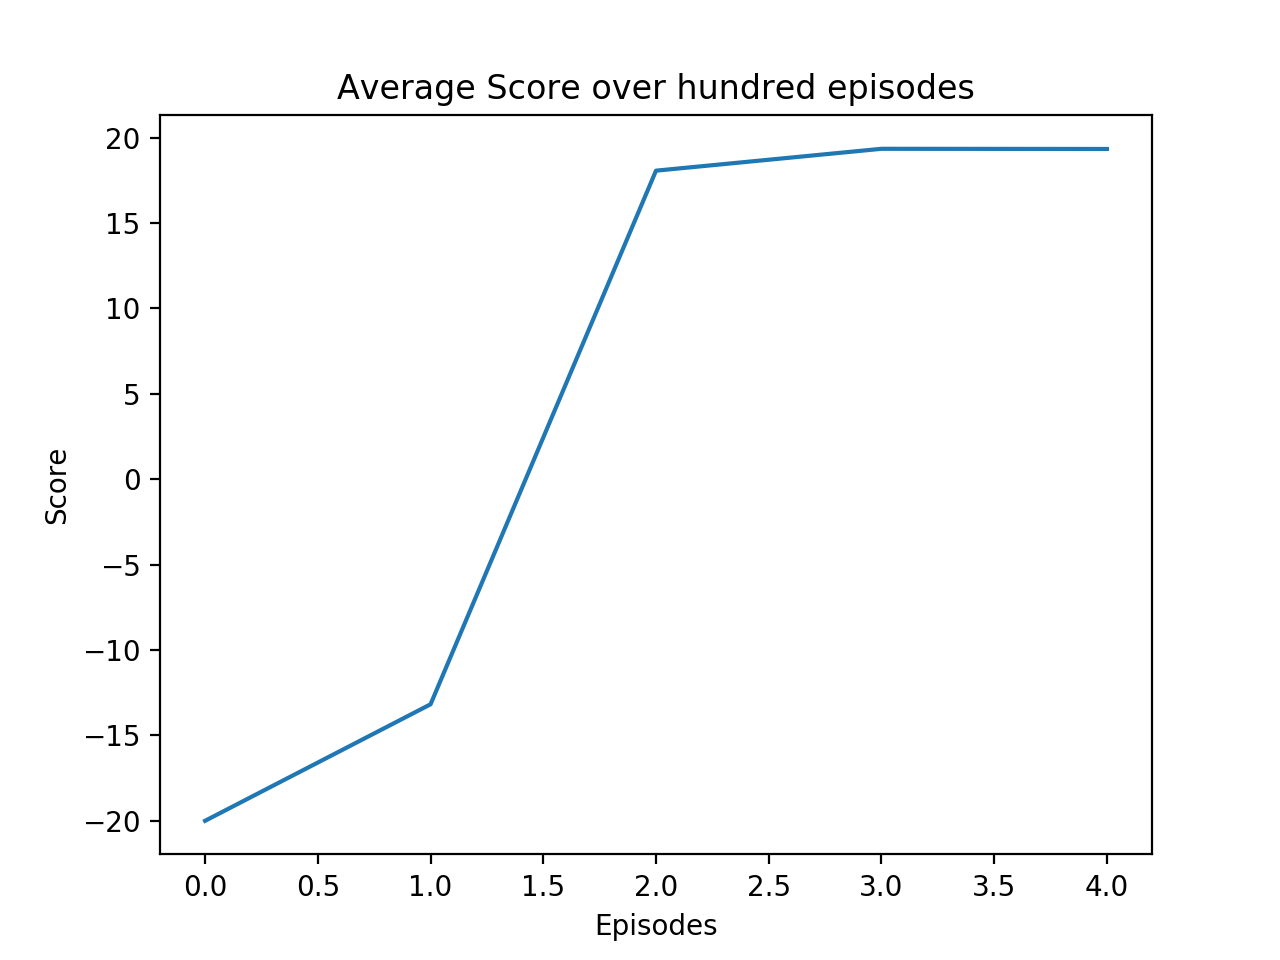

<IPython.core.display.Javascript object>


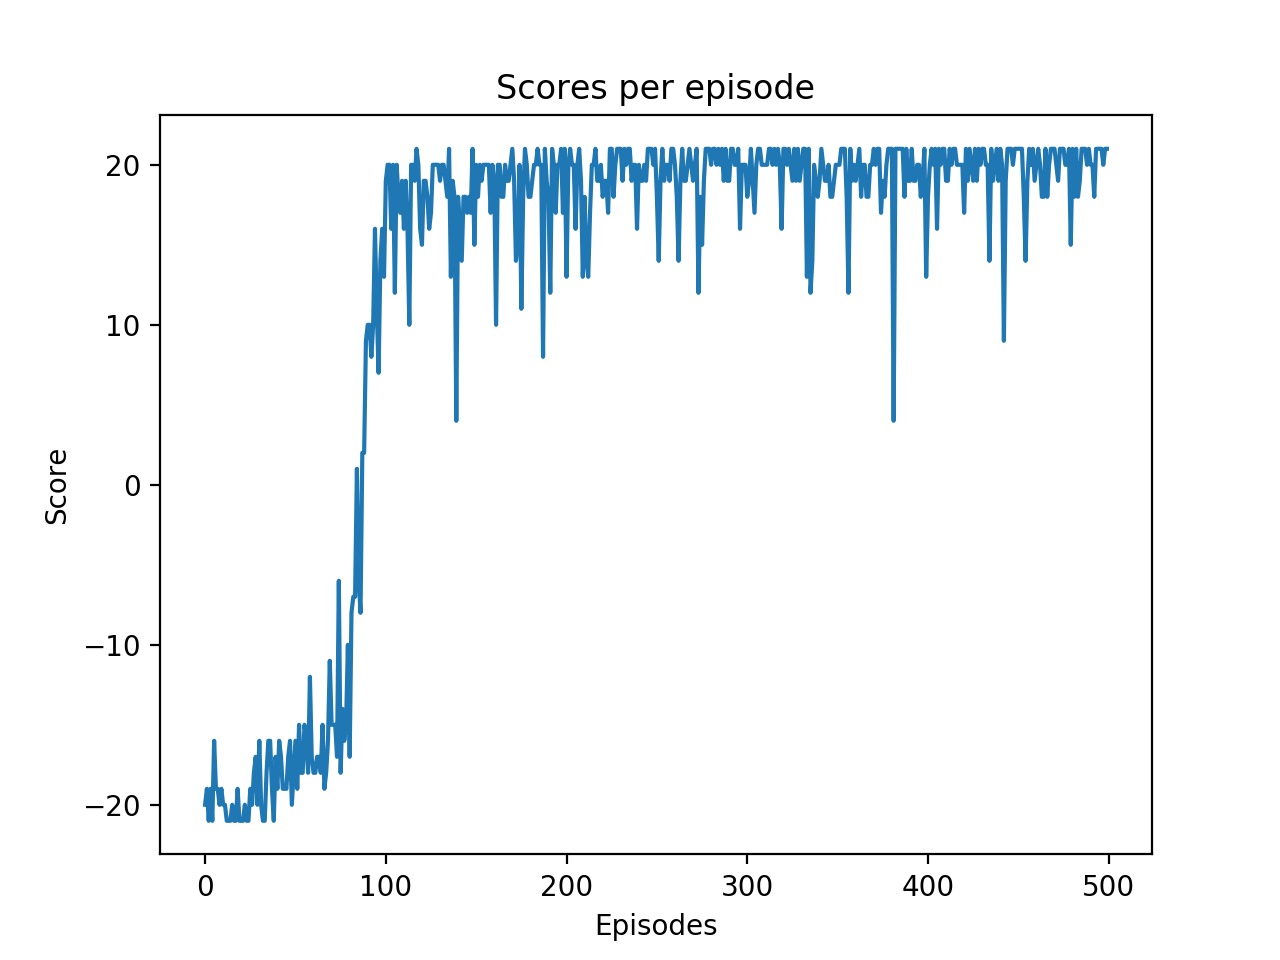

Text(0.5,1,'Scores per episode')

In [6]:
%matplotlib notebook
plt.figure()
plt.plot(averageScore)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.figure()
plt.plot(scores)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per episode')

In [7]:
PATH = './pongupdatenograd.pth'
torch.save(Qupdate.state_dict(), PATH)
PATH = './pongtargetnograd.pth'
torch.save(QTarget.state_dict(), PATH)

# EXTRA IMPLEMENTATIONS

## Note--
Just to show how running each algorithm multiple times can lead to different results here i show two executions of each of the algorithms as this would make comparing the algorithms more realistic(In reality i have run these algorithms much more than the two times shown here)

### Dueling Networks for Deep Q Learning:
Since i did a paper report on dueling networks for deep Q Learning thought about implementing it and seeing if any changes are observed,implementation is very straightforward and only need to make changes to the deep learning architecture and freeze the other parts of the implementation including the hyperparameters.

Learn more about Dueling Networks for Deep Q Learning here--https://arxiv.org/pdf/1511.06581.pdf

In [5]:
##Choice of the architecture of the Deep Q Network and the learning rate make a big difference in the learning process
##Choose 3 fully connected networks with 4->64->128->2 output with Adam and learning rate as 0.0001
##Seems to work well with 2 hidden layers and performance deteriorates when the hidden layer is increased by 1.
env=gym.make('CartPole-v1')
nGames=1000
scoresDuel=[]
averageScoreDuel=[]
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.fc1=nn.Linear(*observationSpace,64)
        self.fc2=nn.Linear(64,128)
        self.advantage=nn.Linear(128,actionSpace)
        self.value=nn.Linear(128,1)
    def forward(self,observation):
        output=F.relu(self.fc1(observation))
        output=F.relu(self.fc2(output))
        valueFunction=self.value(output)
        advantageFunction=self.advantage(output)
        output=valueFunction+(advantageFunction-torch.mean(advantageFunction))
        #output=self.fc3(output)
        return output
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
QTarget=QNetwork(env.observation_space.shape,env.action_space.n)
Qupdate.to(device)
QTarget.to(device)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
memorySize=50000
batchSize=16
indices=[i for i in range(batchSize)]
replayMemory=[0 for i in range(memorySize)]
epsilon=1
epsilonDec=1e-4
epsilonMin=0.01
gamma=0.99
memoryCounter=0
counter=0
replace=4
def decrementEpsilon(epsilon,epsilonDec,epsilonMin):
    if epsilon>epsilonMin:
        epsilon-=epsilonDec
    else:
        epsilon=epsilonMin
    return epsilon
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        if np.random.random()>epsilon:
            with torch.no_grad():
                action=Qupdate(torch.Tensor(observation).to(device))
                action=torch.argmax(action).item()
        else:
            action=env.action_space.sample()
        newObservation,reward,done,info=env.step(action)
        index=memoryCounter%memorySize
        d=dict()
        d['observation']=observation
        d['newObservation']=newObservation
        d['reward']=reward
        d['done']=done
        d['action']=action
        replayMemory[index]=d
        totalReward+=reward
        memoryCounter+=1
        if memoryCounter>=batchSize:
            optimizer.zero_grad()
            if counter%replace==0:
                QTarget.load_state_dict(Qupdate.state_dict())
            if memoryCounter<=memorySize:
                maxMem=memoryCounter
            else:
                maxMem=memorySize
            numbers=[i for i in range(maxMem)]
            sampleIndices=sample(numbers,batchSize)
            sampledObservations=list()
            sampledNewObservations=list()
            sampledrewards=list()
            sampledActions=list()
            sampledTerminalStates=list()
            for ele in sampleIndices:
                sampledObservations.append(replayMemory[ele]['observation'])
                sampledNewObservations.append(replayMemory[ele]['newObservation'])
                sampledrewards.append(replayMemory[ele]['reward'])
                sampledTerminalStates.append(replayMemory[ele]['done'])
                sampledActions.append(replayMemory[ele]['action'])
            batchQValue=Qupdate(torch.Tensor(sampledObservations).to(device))
            qValueCurrentState=torch.empty(batchSize).to(device)
            qValueNextState=torch.max(QTarget(torch.Tensor(sampledNewObservations).to(device)),1)[0]
            for j in range(batchSize):
                if sampledTerminalStates[j] is True:
                    qValueNextState[j]=0.0
                qValueCurrentState[j]=batchQValue[j][sampledActions[j]]
            y=(torch.Tensor(sampledrewards).to(device)+gamma*qValueNextState).detach()
            loss=criterion(y,qValueCurrentState).to(device)
            loss.backward()
            optimizer.step()
            epsilon=decrementEpsilon(epsilon,epsilonDec,epsilonMin)
            counter+=1
        observation=newObservation
    scoresDuel.append(totalReward)
    if i%100==0:
        averageScoreDuel.append(np.mean(scoresDuel[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scoresDuel[-100:]):.2f},score {totalReward:.2f},epsilon {epsilon:.2f}')
        
        

epsiode 0,Average Score 15.00,score 15.00,epsilon 1.00
epsiode 100,Average Score 19.48,score 15.00,epsilon 0.81
epsiode 200,Average Score 29.39,score 32.00,epsilon 0.51
epsiode 300,Average Score 102.86,score 213.00,epsilon 0.01
epsiode 400,Average Score 408.80,score 455.00,epsilon 0.01
epsiode 500,Average Score 398.99,score 443.00,epsilon 0.01
epsiode 600,Average Score 439.23,score 274.00,epsilon 0.01
epsiode 700,Average Score 434.75,score 377.00,epsilon 0.01
epsiode 800,Average Score 478.42,score 500.00,epsilon 0.01
epsiode 900,Average Score 459.32,score 306.00,epsilon 0.01


<IPython.core.display.Javascript object>


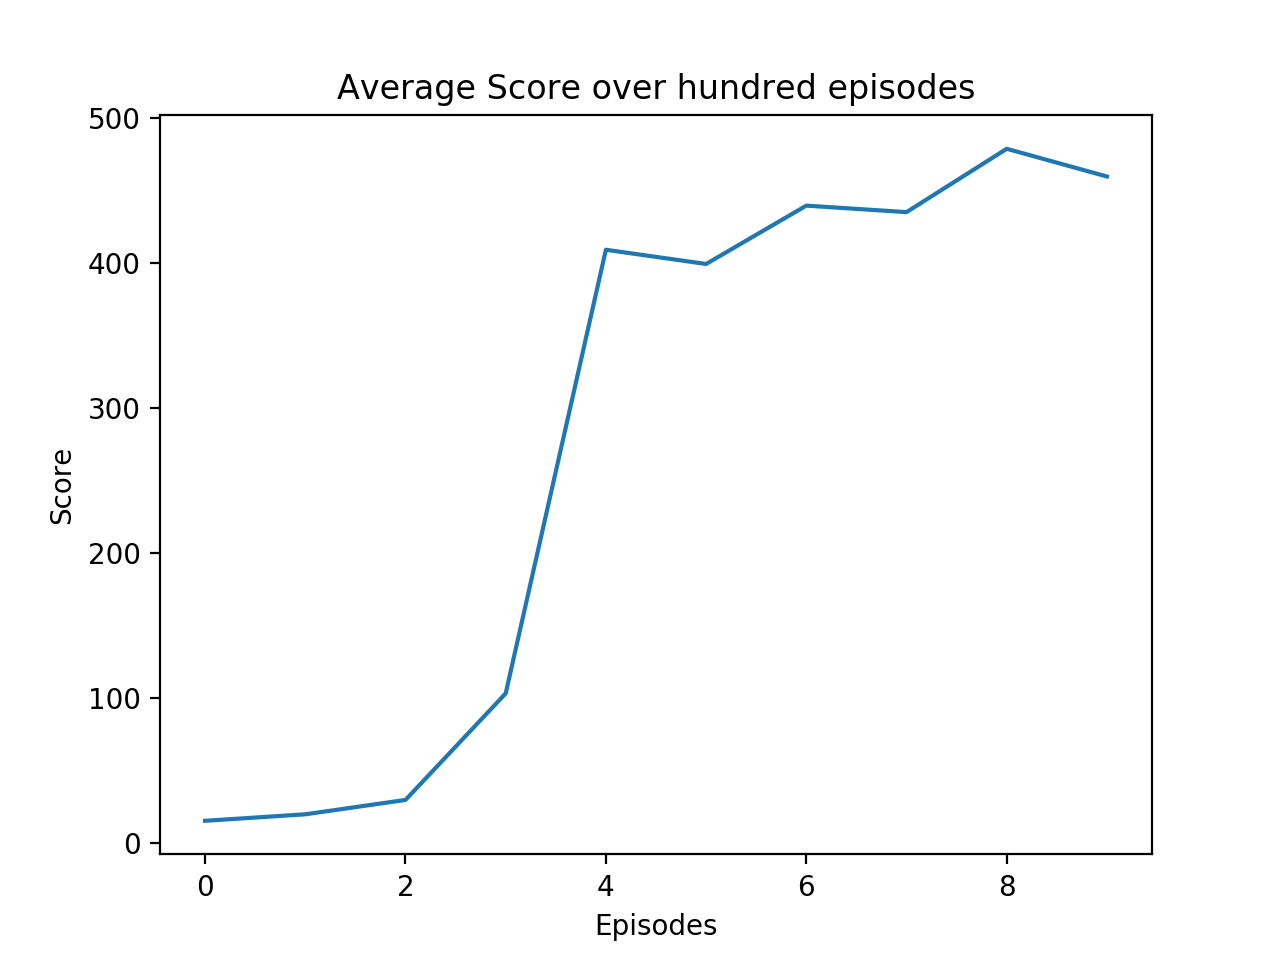

<IPython.core.display.Javascript object>


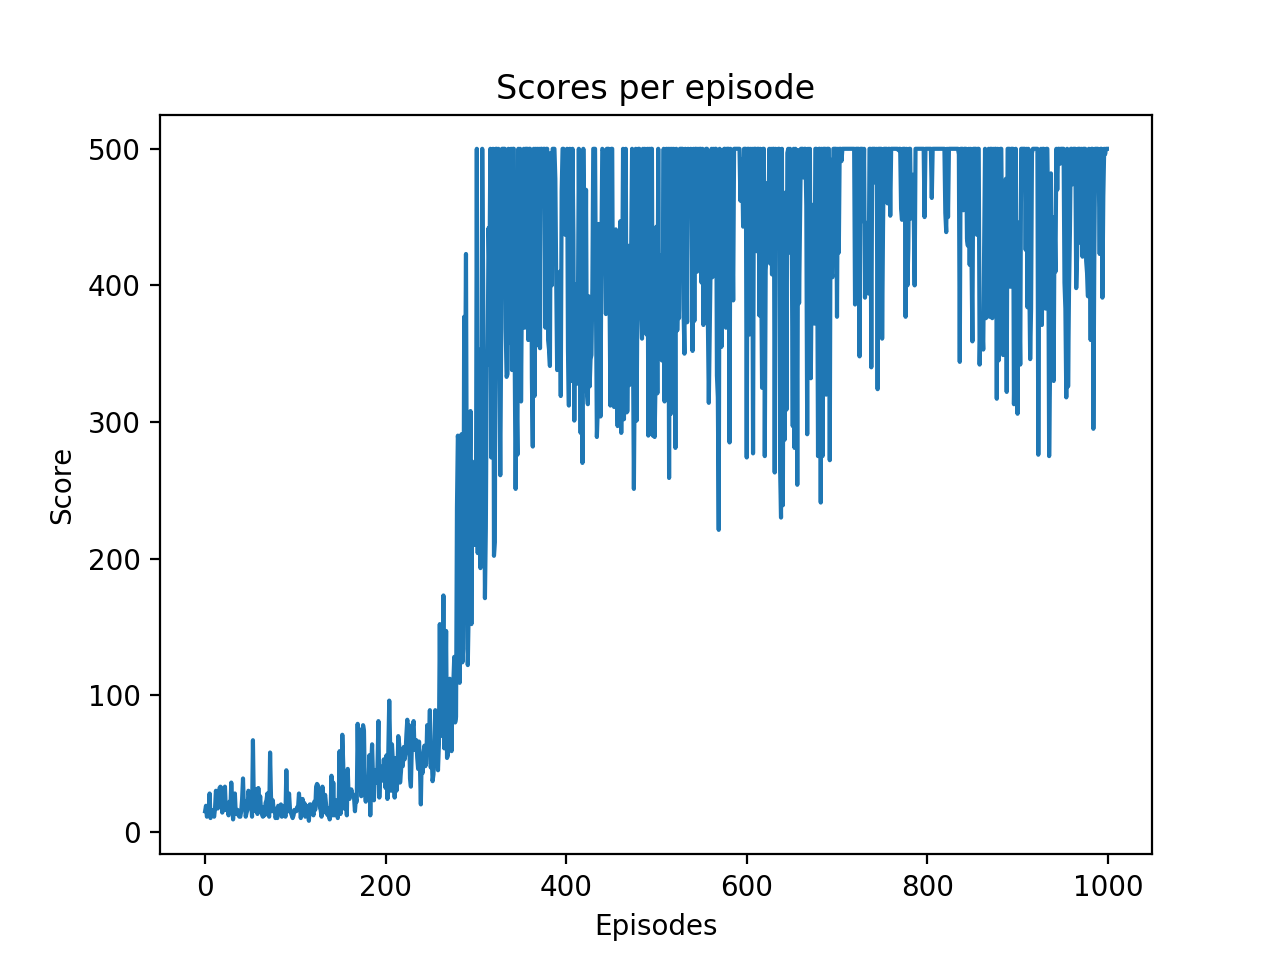

Text(0.5,1,'Scores per episode')

In [12]:
%matplotlib notebook
plt.figure()
plt.plot(averageScoreDuel)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.figure()
plt.plot(scoresDuel)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per episode')

In [2]:
##Choice of the architecture of the Deep Q Network and the learning rate make a big difference in the learning process
##Choose 3 fully connected networks with 4->64->128->2 output with Adam and learning rate as 0.0001
##Seems to work well with 2 hidden layers and performance deteriorates when the hidden layer is increased by 1.
env=gym.make('CartPole-v1')
nGames=1000
scoresDuel=[]
averageScoreDuel=[]
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.fc1=nn.Linear(*observationSpace,64)
        self.fc2=nn.Linear(64,128)
        self.advantage=nn.Linear(128,actionSpace)
        self.value=nn.Linear(128,1)
    def forward(self,observation):
        output=F.relu(self.fc1(observation))
        output=F.relu(self.fc2(output))
        valueFunction=self.value(output)
        advantageFunction=self.advantage(output)
        output=valueFunction+(advantageFunction-torch.mean(advantageFunction))
        #output=self.fc3(output)
        return output
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
QTarget=QNetwork(env.observation_space.shape,env.action_space.n)
Qupdate.to(device)
QTarget.to(device)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
memorySize=50000
batchSize=16
indices=[i for i in range(batchSize)]
replayMemory=[0 for i in range(memorySize)]
epsilon=1
epsilonDec=1e-4
epsilonMin=0.01
gamma=0.99
memoryCounter=0
counter=0
replace=4
def decrementEpsilon(epsilon,epsilonDec,epsilonMin):
    if epsilon>epsilonMin:
        epsilon-=epsilonDec
    else:
        epsilon=epsilonMin
    return epsilon
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        if np.random.random()>epsilon:
            with torch.no_grad():
                action=Qupdate(torch.Tensor(observation).to(device))
                action=torch.argmax(action).item()
        else:
            action=env.action_space.sample()
        newObservation,reward,done,info=env.step(action)
        index=memoryCounter%memorySize
        d=dict()
        d['observation']=observation
        d['newObservation']=newObservation
        d['reward']=reward
        d['done']=done
        d['action']=action
        replayMemory[index]=d
        totalReward+=reward
        memoryCounter+=1
        if memoryCounter>=batchSize:
            optimizer.zero_grad()
            if counter%replace==0:
                QTarget.load_state_dict(Qupdate.state_dict())
            if memoryCounter<=memorySize:
                maxMem=memoryCounter
            else:
                maxMem=memorySize
            numbers=[i for i in range(maxMem)]
            sampleIndices=sample(numbers,batchSize)
            sampledObservations=list()
            sampledNewObservations=list()
            sampledrewards=list()
            sampledActions=list()
            sampledTerminalStates=list()
            for ele in sampleIndices:
                sampledObservations.append(replayMemory[ele]['observation'])
                sampledNewObservations.append(replayMemory[ele]['newObservation'])
                sampledrewards.append(replayMemory[ele]['reward'])
                sampledTerminalStates.append(replayMemory[ele]['done'])
                sampledActions.append(replayMemory[ele]['action'])
            batchQValue=Qupdate(torch.Tensor(sampledObservations).to(device))
            qValueCurrentState=torch.empty(batchSize).to(device)
            qValueNextState=torch.max(QTarget(torch.Tensor(sampledNewObservations).to(device)),1)[0]
            for j in range(batchSize):
                if sampledTerminalStates[j] is True:
                    qValueNextState[j]=0.0
                qValueCurrentState[j]=batchQValue[j][sampledActions[j]]
            y=(torch.Tensor(sampledrewards).to(device)+gamma*qValueNextState).detach()
            loss=criterion(y,qValueCurrentState).to(device)
            loss.backward()
            optimizer.step()
            epsilon=decrementEpsilon(epsilon,epsilonDec,epsilonMin)
            counter+=1
        observation=newObservation
    scoresDuel.append(totalReward)
    if i%100==0:
        averageScoreDuel.append(np.mean(scoresDuel[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scoresDuel[-100:]):.2f},score {totalReward:.2f},epsilon {epsilon:.2f}')

epsiode 0,Average Score 35.00,score 35.00,epsilon 1.00
epsiode 100,Average Score 20.42,score 28.00,epsilon 0.79
epsiode 200,Average Score 46.29,score 166.00,epsilon 0.33
epsiode 300,Average Score 302.91,score 500.00,epsilon 0.01
epsiode 400,Average Score 386.71,score 455.00,epsilon 0.01
epsiode 500,Average Score 434.07,score 500.00,epsilon 0.01
epsiode 600,Average Score 443.86,score 455.00,epsilon 0.01
epsiode 700,Average Score 464.81,score 500.00,epsilon 0.01
epsiode 800,Average Score 483.87,score 500.00,epsilon 0.01
epsiode 900,Average Score 446.20,score 500.00,epsilon 0.01


<IPython.core.display.Javascript object>


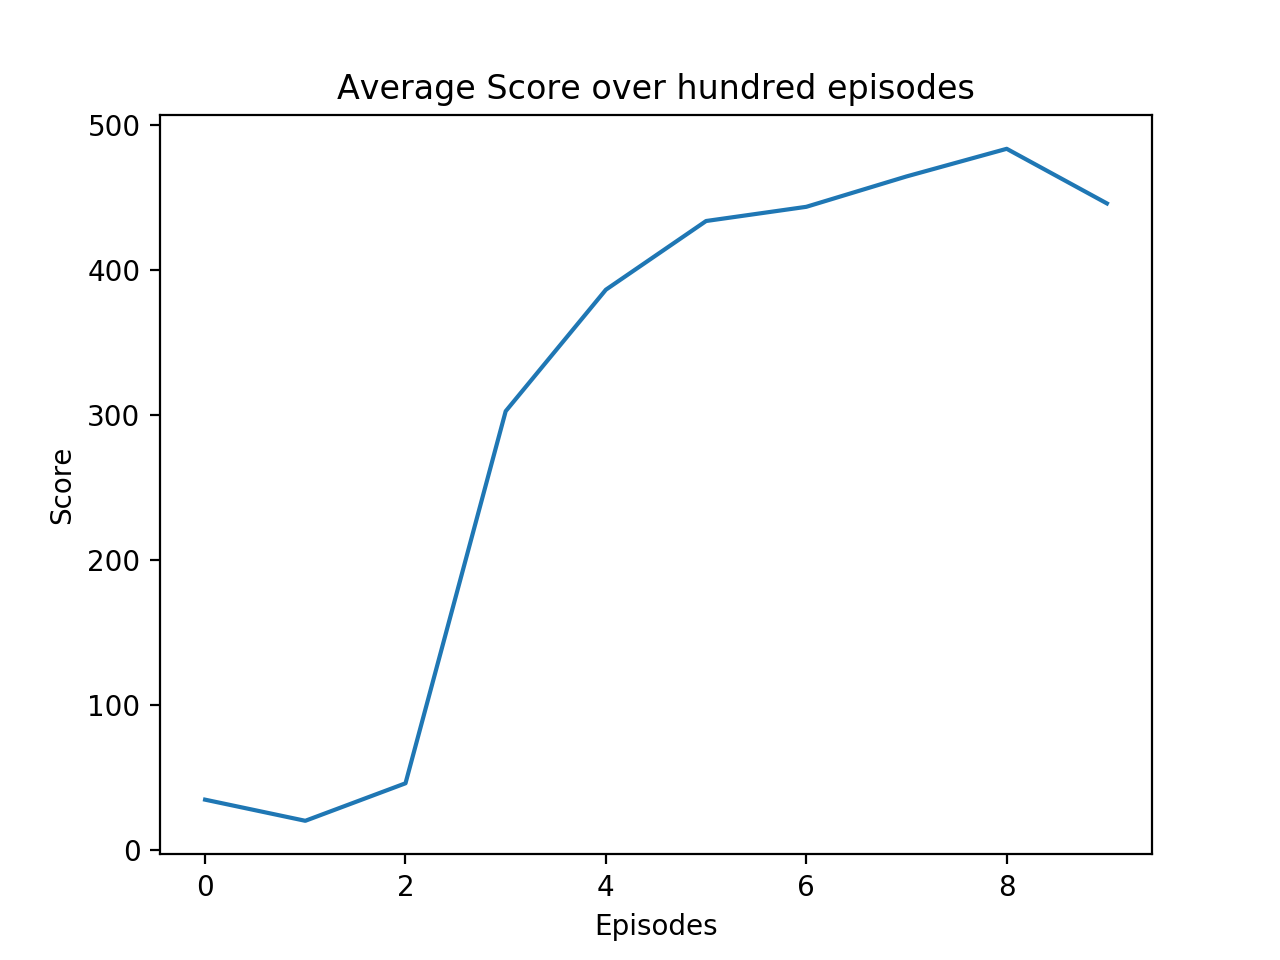

<IPython.core.display.Javascript object>


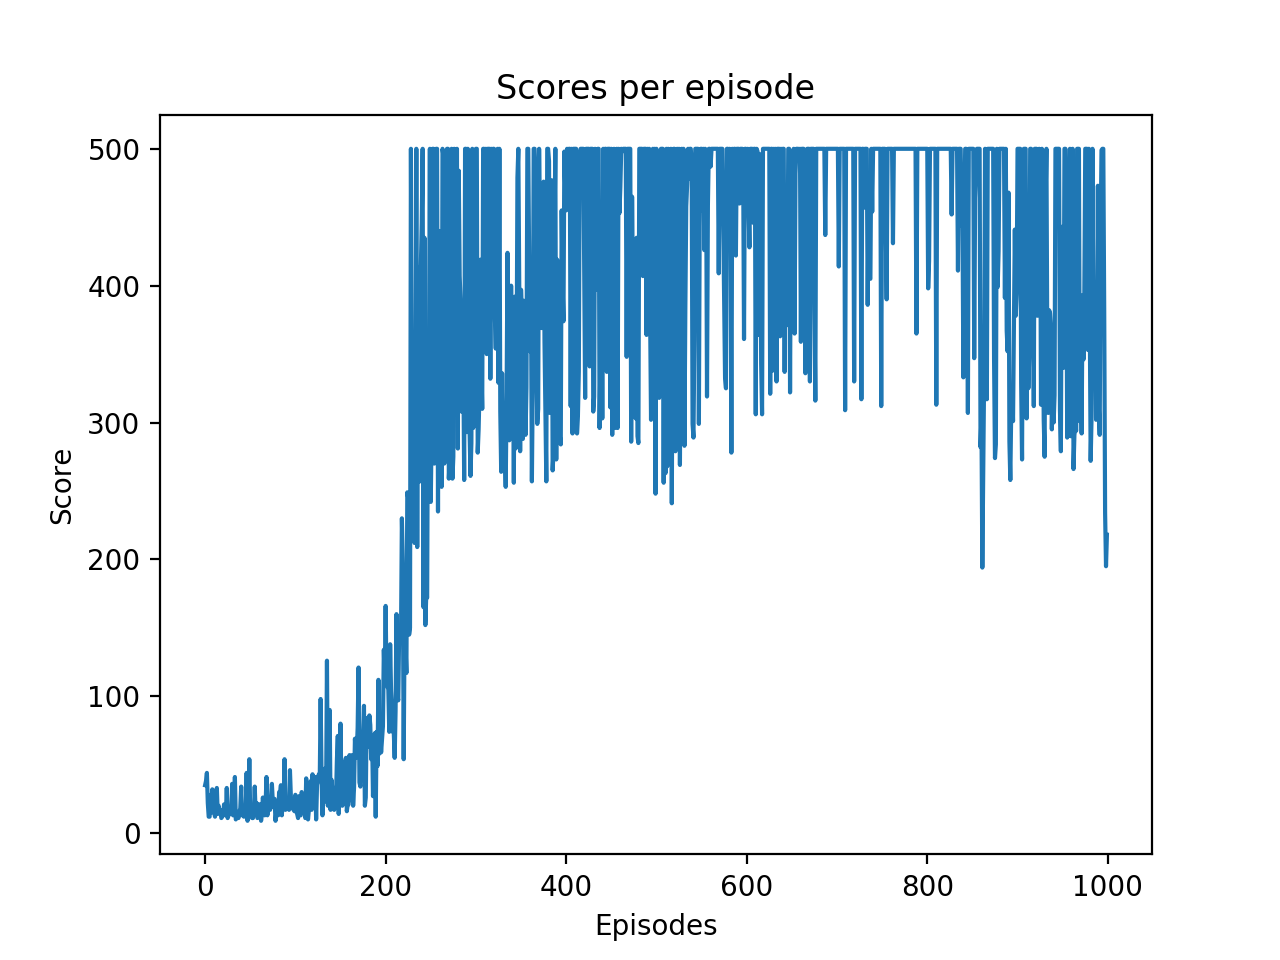

Text(0.5,1,'Scores per episode')

In [3]:
%matplotlib notebook
plt.figure()
plt.plot(averageScoreDuel)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.figure()
plt.plot(scoresDuel)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per episode')

### Double Deep Q Learning:
Normal Deep Q Networks suffer from 'overestimating' the target value due to the max operator present and also lead to training instability as the same network is used to evaluate the actions and also choose the action,double deep Q Learning tries to eliminate this phenomenon by using the normal Q network to select the action and use the target Q network to evaluate the choosen action.

Learn more about Double Deep Q Learning here--https://arxiv.org/pdf/1509.06461.pdf

The update rule changes as follows--

$a^*=argmax_a Q(s_{t+1},a;\theta)$

$y_t=r_t+Q(s_{t+1},a^*;\theta^{-})$

The above equation was got from--https://medium.com/analytics-vidhya/introduction-to-dueling-double-deep-q-network-d3qn-8353a42f9e55

In [7]:
##Double Deep Q Learning
##Choice of the architecture of the Deep Q Network and the learning rate make a big difference in the learning process
##Choose 3 fully connected networks with 4->64->128->2 output with Adam and learning rate as 0.0001
##Seems to work well with 2 hidden layers and performance deteriorates when the hidden layer is increased by 1.
env=gym.make('CartPole-v1')
nGames=1000
scoresDouble=[]
averageScoreDouble=[]
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.fc1=nn.Linear(*observationSpace,64)
        self.fc2=nn.Linear(64,128)
        self.fc3=nn.Linear(128,actionSpace)
    def forward(self,observation):
        output=F.relu(self.fc1(observation))
        output=F.relu(self.fc2(output))
        output=self.fc3(output)
        return output
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
QTarget=QNetwork(env.observation_space.shape,env.action_space.n)
Qupdate.to(device)
QTarget.to(device)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
memorySize=50000
batchSize=16
indices=[i for i in range(batchSize)]
replayMemory=[0 for i in range(memorySize)]
epsilon=1
epsilonDec=1e-4
epsilonMin=0.01
gamma=0.99
memoryCounter=0
counter=0
replace=4
def decrementEpsilon(epsilon,epsilonDec,epsilonMin):
    if epsilon>epsilonMin:
        epsilon-=epsilonDec
    else:
        epsilon=epsilonMin
    return epsilon
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        if np.random.random()>epsilon:
            with torch.no_grad():
                action=Qupdate(torch.Tensor(observation).to(device))
                action=torch.argmax(action).item()
        else:
            action=env.action_space.sample()
        newObservation,reward,done,info=env.step(action)
        index=memoryCounter%memorySize
        d=dict()
        d['observation']=observation
        d['newObservation']=newObservation
        d['reward']=reward
        d['done']=done
        d['action']=action
        replayMemory[index]=d
        totalReward+=reward
        memoryCounter+=1
        if memoryCounter>=batchSize:
            optimizer.zero_grad()
            if counter%replace==0:
                QTarget.load_state_dict(Qupdate.state_dict())
            if memoryCounter<=memorySize:
                maxMem=memoryCounter
            else:
                maxMem=memorySize
            numbers=[i for i in range(maxMem)]
            sampleIndices=sample(numbers,batchSize)
            sampledObservations=list()
            sampledNewObservations=list()
            sampledrewards=list()
            sampledActions=list()
            sampledTerminalStates=list()
            for ele in sampleIndices:
                sampledObservations.append(replayMemory[ele]['observation'])
                sampledNewObservations.append(replayMemory[ele]['newObservation'])
                sampledrewards.append(replayMemory[ele]['reward'])
                sampledTerminalStates.append(replayMemory[ele]['done'])
                sampledActions.append(replayMemory[ele]['action'])
            batchQValue=Qupdate(torch.Tensor(sampledObservations).to(device))
            qValueCurrentState=torch.empty(batchSize).to(device)
            actionIndices=torch.argmax(Qupdate(torch.Tensor(sampledNewObservations).to(device)),1)
            #print(Qupdate(torch.Tensor(sampledNewObservations).to(device)))
            #print(actionIndices)
            qValueNextStateAllActions=QTarget(torch.Tensor(sampledNewObservations).to(device))
            qValueNextState=torch.empty(batchSize).to(device)
            #print(qValueNextState)
            for j in range(batchSize):
                if sampledTerminalStates[j] is True:
                    qValueNextState[j]=0.0
                else:
                    qValueNextState[j]=qValueNextStateAllActions[j][actionIndices[j]]
                qValueCurrentState[j]=batchQValue[j][sampledActions[j]]
            y=(torch.Tensor(sampledrewards).to(device)+gamma*qValueNextState).detach()
            loss=criterion(y,qValueCurrentState).to(device)
            loss.backward()
            optimizer.step()
            epsilon=decrementEpsilon(epsilon,epsilonDec,epsilonMin)
            counter+=1
        observation=newObservation
    scoresDouble.append(totalReward)
    if i%100==0:
        averageScoreDouble.append(np.mean(scoresDouble[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scoresDouble[-100:]):.2f},score {totalReward:.2f},epsilon {epsilon:.2f}')
        
        

epsiode 0,Average Score 24.00,score 24.00,epsilon 1.00
epsiode 100,Average Score 20.70,score 13.00,epsilon 0.79
epsiode 200,Average Score 23.44,score 28.00,epsilon 0.56
epsiode 300,Average Score 106.76,score 438.00,epsilon 0.01
epsiode 400,Average Score 382.91,score 500.00,epsilon 0.01
epsiode 500,Average Score 436.54,score 237.00,epsilon 0.01
epsiode 600,Average Score 463.84,score 500.00,epsilon 0.01
epsiode 700,Average Score 481.35,score 500.00,epsilon 0.01
epsiode 800,Average Score 497.22,score 500.00,epsilon 0.01
epsiode 900,Average Score 497.74,score 385.00,epsilon 0.01


<IPython.core.display.Javascript object>


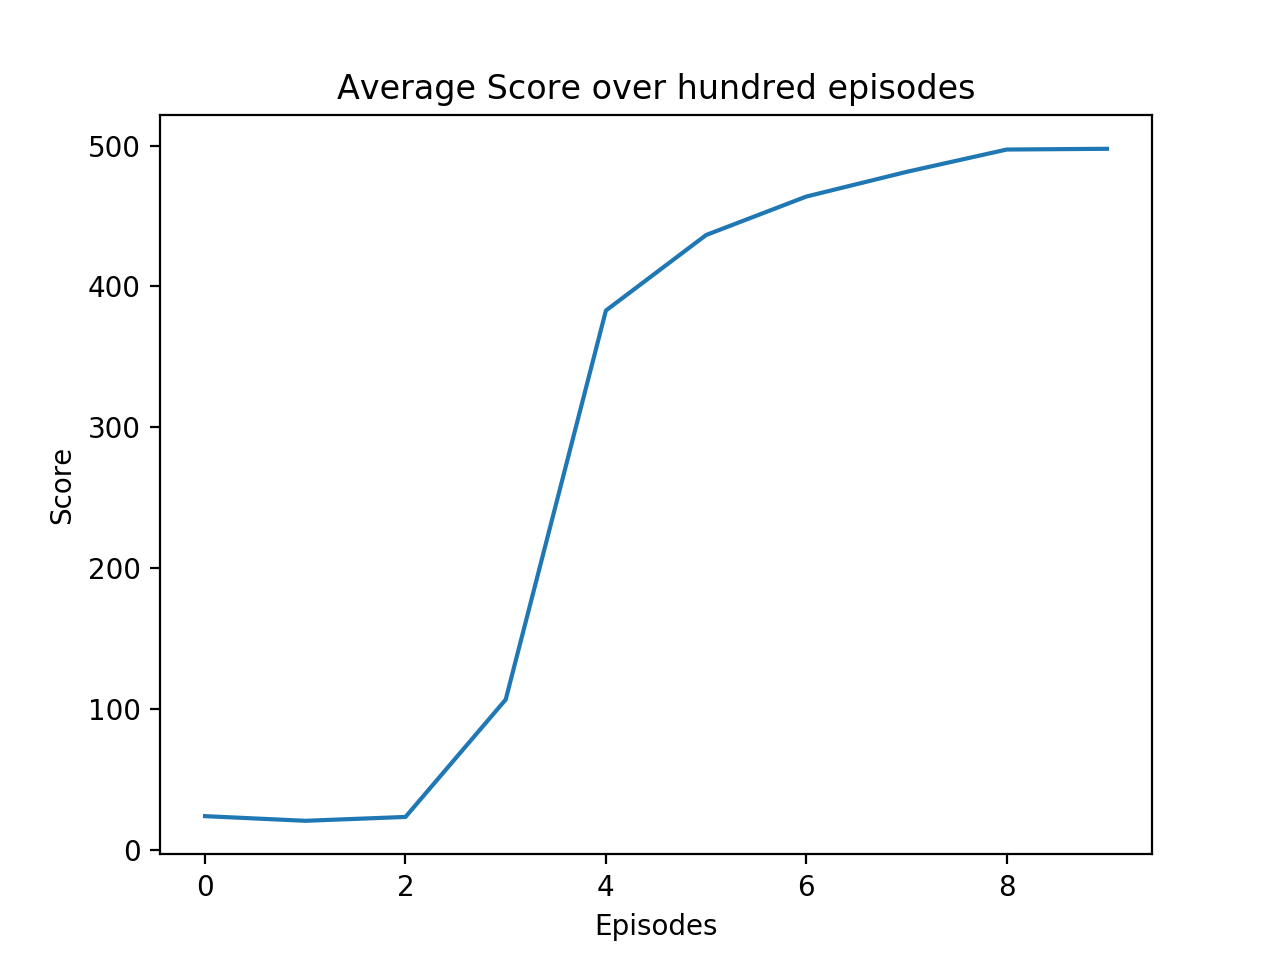

<IPython.core.display.Javascript object>


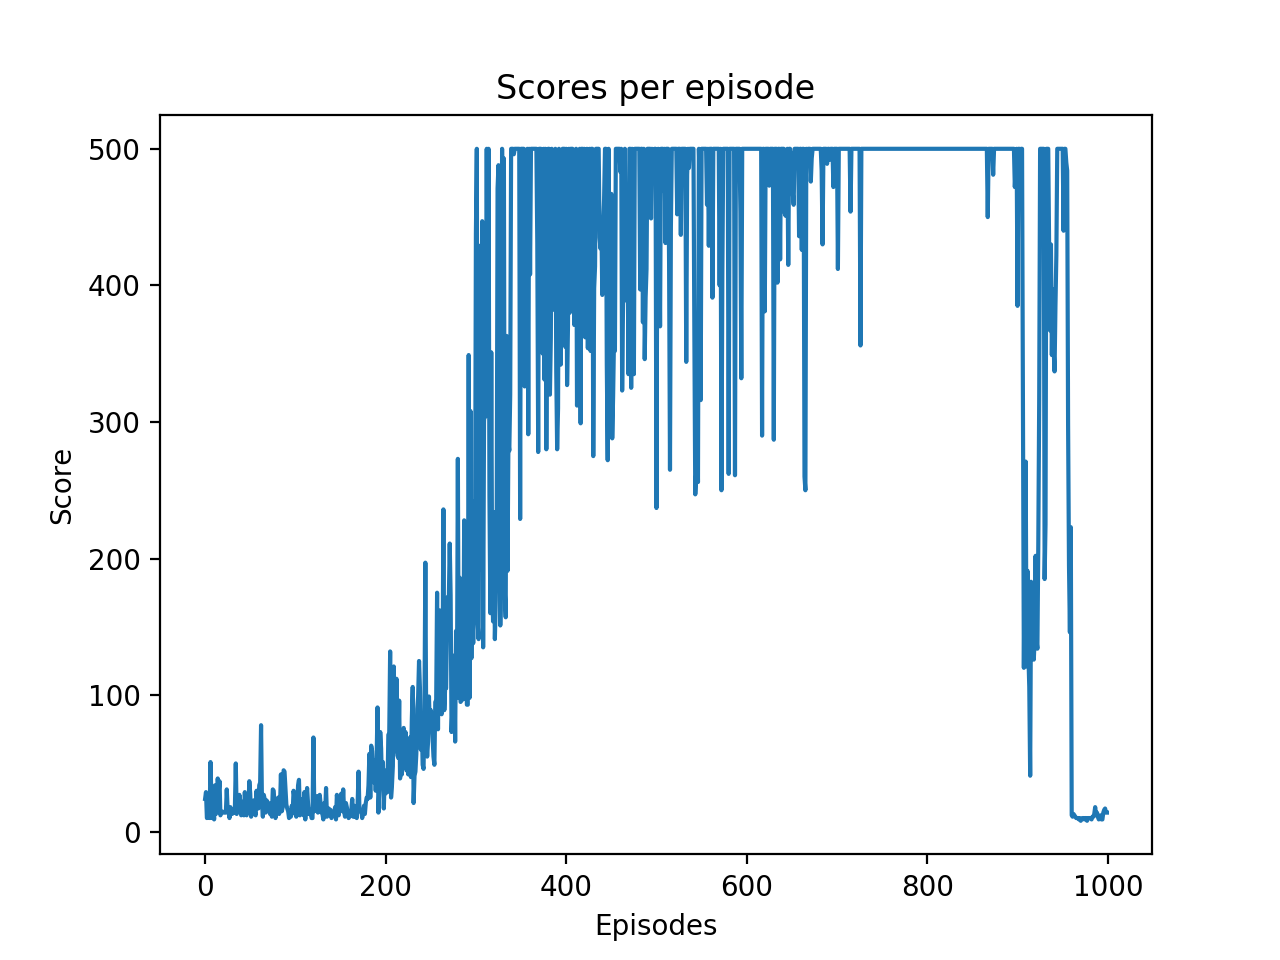

Text(0.5,1,'Scores per episode')

In [13]:
%matplotlib notebook
plt.figure()
plt.plot(averageScoreDouble)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.figure()
plt.plot(scoresDouble)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per episode')

In [4]:
##Double Deep Q Learning
##Choice of the architecture of the Deep Q Network and the learning rate make a big difference in the learning process
##Choose 3 fully connected networks with 4->64->128->2 output with Adam and learning rate as 0.0001
##Seems to work well with 2 hidden layers and performance deteriorates when the hidden layer is increased by 1.
env=gym.make('CartPole-v1')
nGames=1000
scoresDouble=[]
averageScoreDouble=[]
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.fc1=nn.Linear(*observationSpace,64)
        self.fc2=nn.Linear(64,128)
        self.fc3=nn.Linear(128,actionSpace)
    def forward(self,observation):
        output=F.relu(self.fc1(observation))
        output=F.relu(self.fc2(output))
        output=self.fc3(output)
        return output
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
QTarget=QNetwork(env.observation_space.shape,env.action_space.n)
Qupdate.to(device)
QTarget.to(device)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
memorySize=50000
batchSize=16
indices=[i for i in range(batchSize)]
replayMemory=[0 for i in range(memorySize)]
epsilon=1
epsilonDec=1e-4
epsilonMin=0.01
gamma=0.99
memoryCounter=0
counter=0
replace=4
def decrementEpsilon(epsilon,epsilonDec,epsilonMin):
    if epsilon>epsilonMin:
        epsilon-=epsilonDec
    else:
        epsilon=epsilonMin
    return epsilon
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        if np.random.random()>epsilon:
            with torch.no_grad():
                action=Qupdate(torch.Tensor(observation).to(device))
                action=torch.argmax(action).item()
        else:
            action=env.action_space.sample()
        newObservation,reward,done,info=env.step(action)
        index=memoryCounter%memorySize
        d=dict()
        d['observation']=observation
        d['newObservation']=newObservation
        d['reward']=reward
        d['done']=done
        d['action']=action
        replayMemory[index]=d
        totalReward+=reward
        memoryCounter+=1
        if memoryCounter>=batchSize:
            optimizer.zero_grad()
            if counter%replace==0:
                QTarget.load_state_dict(Qupdate.state_dict())
            if memoryCounter<=memorySize:
                maxMem=memoryCounter
            else:
                maxMem=memorySize
            numbers=[i for i in range(maxMem)]
            sampleIndices=sample(numbers,batchSize)
            sampledObservations=list()
            sampledNewObservations=list()
            sampledrewards=list()
            sampledActions=list()
            sampledTerminalStates=list()
            for ele in sampleIndices:
                sampledObservations.append(replayMemory[ele]['observation'])
                sampledNewObservations.append(replayMemory[ele]['newObservation'])
                sampledrewards.append(replayMemory[ele]['reward'])
                sampledTerminalStates.append(replayMemory[ele]['done'])
                sampledActions.append(replayMemory[ele]['action'])
            batchQValue=Qupdate(torch.Tensor(sampledObservations).to(device))
            qValueCurrentState=torch.empty(batchSize).to(device)
            actionIndices=torch.argmax(Qupdate(torch.Tensor(sampledNewObservations).to(device)),1)
            #print(Qupdate(torch.Tensor(sampledNewObservations).to(device)))
            #print(actionIndices)
            qValueNextStateAllActions=QTarget(torch.Tensor(sampledNewObservations).to(device))
            qValueNextState=torch.empty(batchSize).to(device)
            #print(qValueNextState)
            for j in range(batchSize):
                if sampledTerminalStates[j] is True:
                    qValueNextState[j]=0.0
                else:
                    qValueNextState[j]=qValueNextStateAllActions[j][actionIndices[j]]
                qValueCurrentState[j]=batchQValue[j][sampledActions[j]]
            y=(torch.Tensor(sampledrewards).to(device)+gamma*qValueNextState).detach()
            loss=criterion(y,qValueCurrentState).to(device)
            loss.backward()
            optimizer.step()
            epsilon=decrementEpsilon(epsilon,epsilonDec,epsilonMin)
            counter+=1
        observation=newObservation
    scoresDouble.append(totalReward)
    if i%100==0:
        averageScoreDouble.append(np.mean(scoresDouble[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scoresDouble[-100:]):.2f},score {totalReward:.2f},epsilon {epsilon:.2f}')
        
        

epsiode 0,Average Score 14.00,score 14.00,epsilon 1.00
epsiode 100,Average Score 21.01,score 35.00,epsilon 0.79
epsiode 200,Average Score 28.74,score 68.00,epsilon 0.50
epsiode 300,Average Score 79.37,score 85.00,epsilon 0.01
epsiode 400,Average Score 198.70,score 233.00,epsilon 0.01
epsiode 500,Average Score 321.92,score 292.00,epsilon 0.01
epsiode 600,Average Score 475.35,score 500.00,epsilon 0.01
epsiode 700,Average Score 490.68,score 500.00,epsilon 0.01
epsiode 800,Average Score 500.00,score 500.00,epsilon 0.01
epsiode 900,Average Score 500.00,score 500.00,epsilon 0.01


<IPython.core.display.Javascript object>


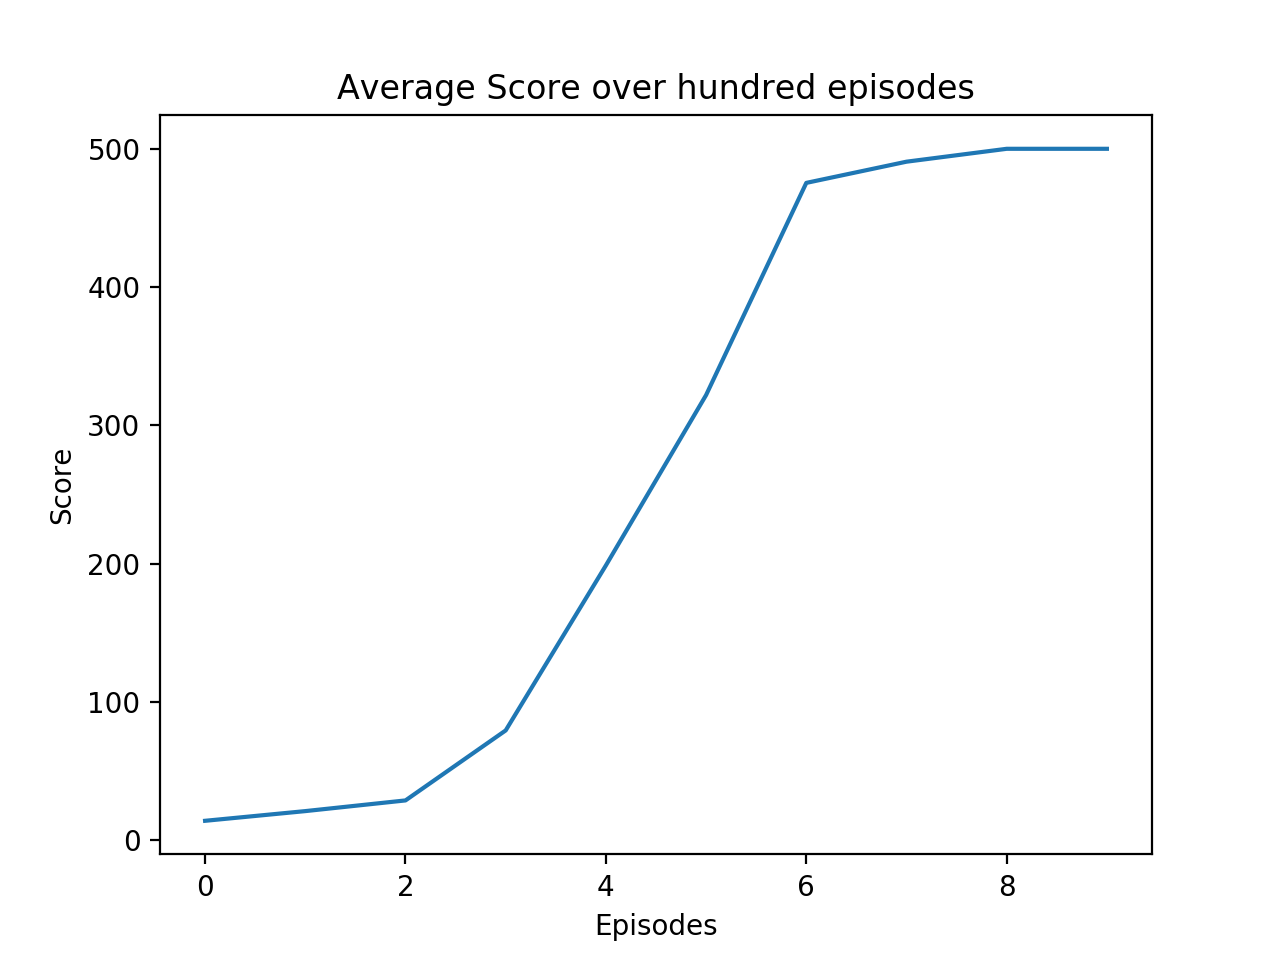

<IPython.core.display.Javascript object>


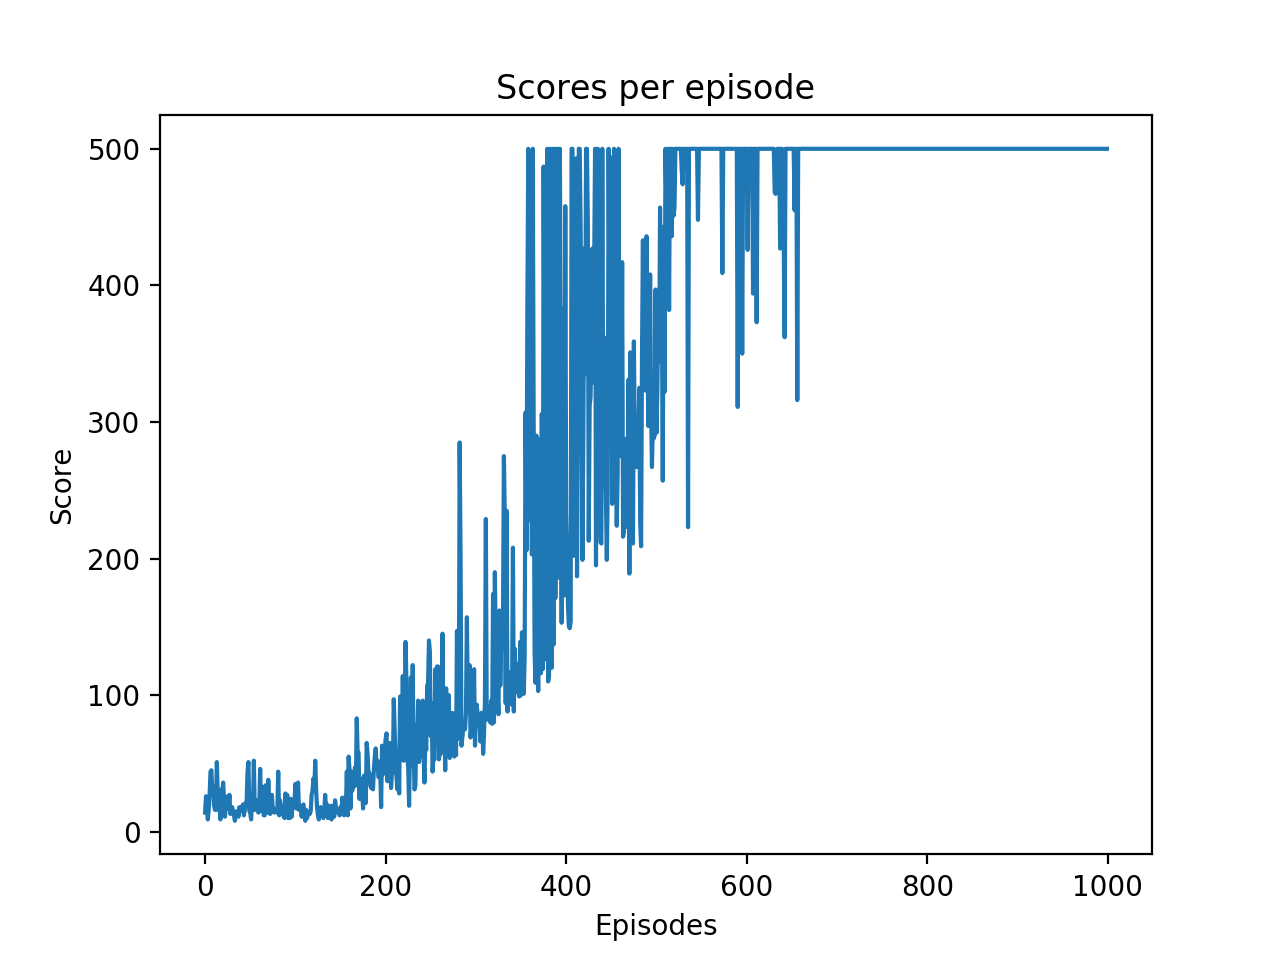

Text(0.5,1,'Scores per episode')

In [5]:
%matplotlib notebook
plt.figure()
plt.plot(averageScoreDouble)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.figure()
plt.plot(scoresDouble)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per episode')

#### Dueling Networks for Deep Q Learning + Double Deep Q Learning

In [3]:
##Double Deep Q Learning
##Choice of the architecture of the Deep Q Network and the learning rate make a big difference in the learning process
##Choose 3 fully connected networks with 4->64->128->2 output with Adam and learning rate as 0.0001
##Seems to work well with 2 hidden layers and performance deteriorates when the hidden layer is increased by 1.
env=gym.make('CartPole-v1')
nGames=1000
scoresDoubleDuel=[]
averageScoreDoubleDuel=[]
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.fc1=nn.Linear(*observationSpace,64)
        self.fc2=nn.Linear(64,128)
        self.advantage=nn.Linear(128,actionSpace)
        self.value=nn.Linear(128,1)
    def forward(self,observation):
        output=F.relu(self.fc1(observation))
        output=F.relu(self.fc2(output))
        valueFunction=self.value(output)
        advantageFunction=self.advantage(output)
        output=valueFunction+(advantageFunction-torch.mean(advantageFunction))
        #output=self.fc3(output)
        return output
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
QTarget=QNetwork(env.observation_space.shape,env.action_space.n)
Qupdate.to(device)
QTarget.to(device)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
memorySize=50000
batchSize=16
indices=[i for i in range(batchSize)]
replayMemory=[0 for i in range(memorySize)]
epsilon=1
epsilonDec=1e-4
epsilonMin=0.01
gamma=0.99
memoryCounter=0
counter=0
replace=4
def decrementEpsilon(epsilon,epsilonDec,epsilonMin):
    if epsilon>epsilonMin:
        epsilon-=epsilonDec
    else:
        epsilon=epsilonMin
    return epsilon
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        if np.random.random()>epsilon:
            with torch.no_grad():
                action=Qupdate(torch.Tensor(observation).to(device))
                action=torch.argmax(action).item()
        else:
            action=env.action_space.sample()
        newObservation,reward,done,info=env.step(action)
        index=memoryCounter%memorySize
        d=dict()
        d['observation']=observation
        d['newObservation']=newObservation
        d['reward']=reward
        d['done']=done
        d['action']=action
        replayMemory[index]=d
        totalReward+=reward
        memoryCounter+=1
        if memoryCounter>=batchSize:
            optimizer.zero_grad()
            if counter%replace==0:
                QTarget.load_state_dict(Qupdate.state_dict())
            if memoryCounter<=memorySize:
                maxMem=memoryCounter
            else:
                maxMem=memorySize
            numbers=[i for i in range(maxMem)]
            sampleIndices=sample(numbers,batchSize)
            sampledObservations=list()
            sampledNewObservations=list()
            sampledrewards=list()
            sampledActions=list()
            sampledTerminalStates=list()
            for ele in sampleIndices:
                sampledObservations.append(replayMemory[ele]['observation'])
                sampledNewObservations.append(replayMemory[ele]['newObservation'])
                sampledrewards.append(replayMemory[ele]['reward'])
                sampledTerminalStates.append(replayMemory[ele]['done'])
                sampledActions.append(replayMemory[ele]['action'])
            batchQValue=Qupdate(torch.Tensor(sampledObservations).to(device))
            qValueCurrentState=torch.empty(batchSize).to(device)
            actionIndices=torch.argmax(Qupdate(torch.Tensor(sampledNewObservations).to(device)),1)
            #print(Qupdate(torch.Tensor(sampledNewObservations).to(device)))
            #print(actionIndices)
            qValueNextStateAllActions=QTarget(torch.Tensor(sampledNewObservations).to(device))
            qValueNextState=torch.empty(batchSize).to(device)
            #print(qValueNextState)
            for j in range(batchSize):
                if sampledTerminalStates[j] is True:
                    qValueNextState[j]=0.0
                else:
                    qValueNextState[j]=qValueNextStateAllActions[j][actionIndices[j]]
                qValueCurrentState[j]=batchQValue[j][sampledActions[j]]
            y=(torch.Tensor(sampledrewards).to(device)+gamma*qValueNextState).detach()
            loss=criterion(y,qValueCurrentState).to(device)
            loss.backward()
            optimizer.step()
            epsilon=decrementEpsilon(epsilon,epsilonDec,epsilonMin)
            counter+=1
        observation=newObservation
    scoresDoubleDuel.append(totalReward)
    if i%100==0:
        averageScoreDoubleDuel.append(np.mean(scoresDoubleDuel[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scoresDoubleDuel[-100:]):.2f},score {totalReward:.2f},epsilon {epsilon:.2f}')
        
        

epsiode 0,Average Score 15.00,score 15.00,epsilon 1.00
epsiode 100,Average Score 20.09,score 20.00,epsilon 0.80
epsiode 200,Average Score 35.01,score 49.00,epsilon 0.45
epsiode 300,Average Score 363.90,score 500.00,epsilon 0.01
epsiode 400,Average Score 439.81,score 500.00,epsilon 0.01
epsiode 500,Average Score 483.82,score 500.00,epsilon 0.01
epsiode 600,Average Score 489.74,score 500.00,epsilon 0.01
epsiode 700,Average Score 491.78,score 500.00,epsilon 0.01
epsiode 800,Average Score 493.63,score 500.00,epsilon 0.01
epsiode 900,Average Score 493.49,score 500.00,epsilon 0.01


<IPython.core.display.Javascript object>


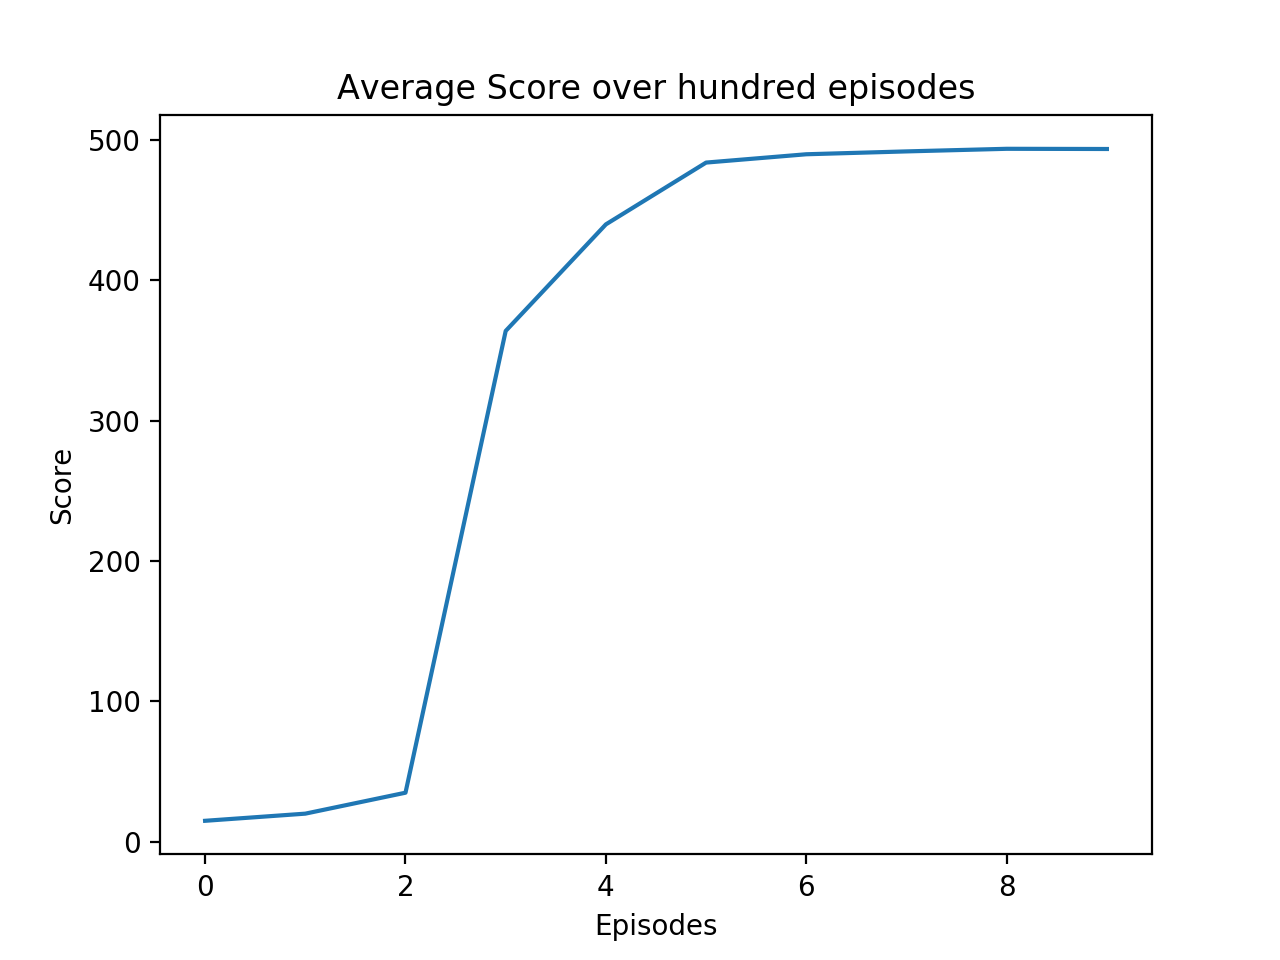

<IPython.core.display.Javascript object>


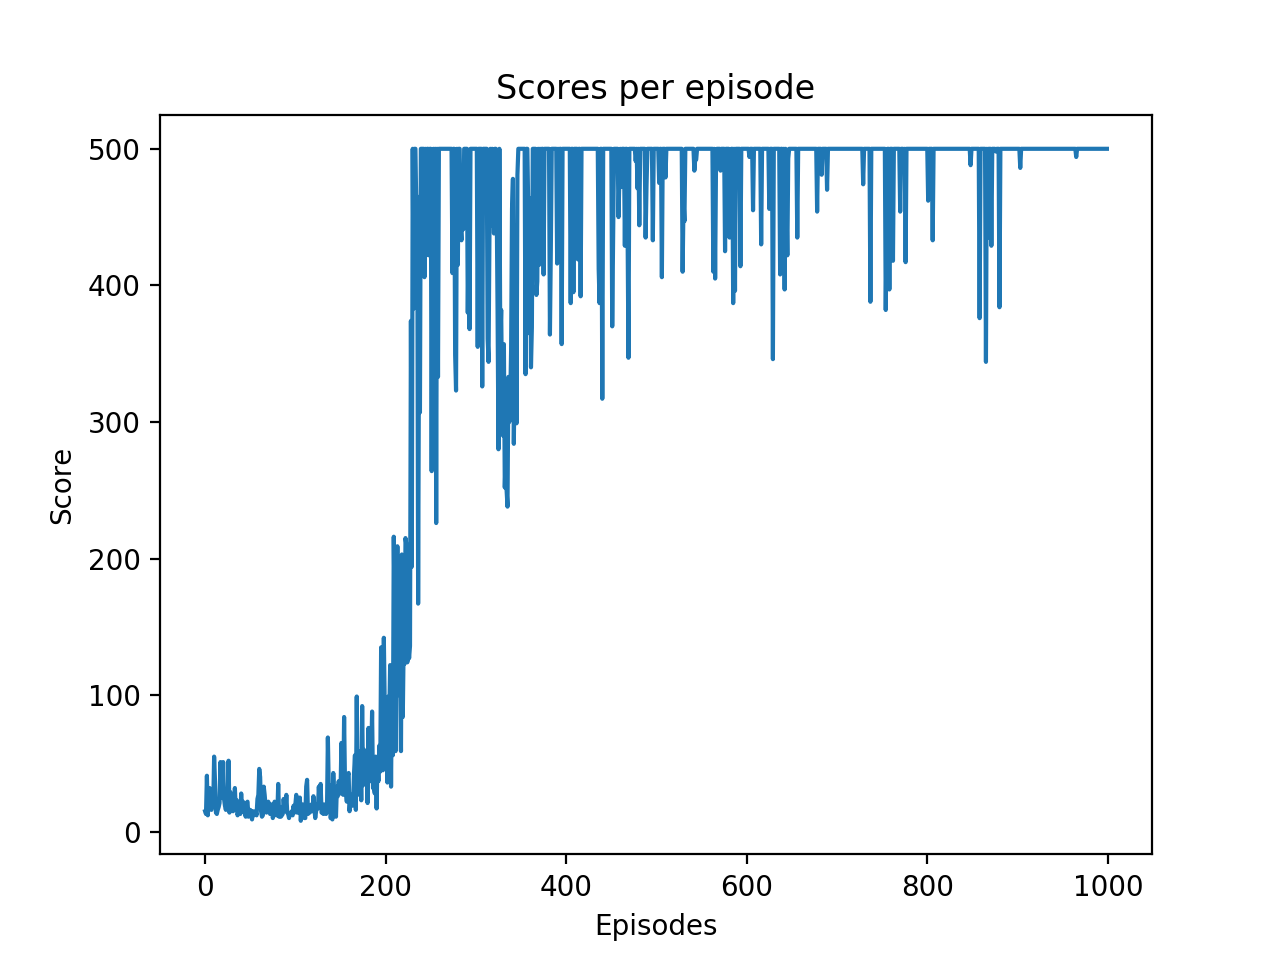

Text(0.5,1,'Scores per episode')

In [4]:
%matplotlib notebook
plt.figure()
plt.plot(averageScoreDoubleDuel)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.figure()
plt.plot(scoresDoubleDuel)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per episode')

In [7]:
##Double Deep Q Learning
##Choice of the architecture of the Deep Q Network and the learning rate make a big difference in the learning process
##Choose 3 fully connected networks with 4->64->128->2 output with Adam and learning rate as 0.0001
##Seems to work well with 2 hidden layers and performance deteriorates when the hidden layer is increased by 1.
env=gym.make('CartPole-v1')
nGames=1000
scoresDoubleDuel=[]
averageScoreDoubleDuel=[]
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.fc1=nn.Linear(*observationSpace,64)
        self.fc2=nn.Linear(64,128)
        self.advantage=nn.Linear(128,actionSpace)
        self.value=nn.Linear(128,1)
    def forward(self,observation):
        output=F.relu(self.fc1(observation))
        output=F.relu(self.fc2(output))
        valueFunction=self.value(output)
        advantageFunction=self.advantage(output)
        output=valueFunction+(advantageFunction-torch.mean(advantageFunction))
        #output=self.fc3(output)
        return output
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
QTarget=QNetwork(env.observation_space.shape,env.action_space.n)
Qupdate.to(device)
QTarget.to(device)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
memorySize=50000
batchSize=16
indices=[i for i in range(batchSize)]
replayMemory=[0 for i in range(memorySize)]
epsilon=1
epsilonDec=1e-4
epsilonMin=0.01
gamma=0.99
memoryCounter=0
counter=0
replace=4
def decrementEpsilon(epsilon,epsilonDec,epsilonMin):
    if epsilon>epsilonMin:
        epsilon-=epsilonDec
    else:
        epsilon=epsilonMin
    return epsilon
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        if np.random.random()>epsilon:
            with torch.no_grad():
                action=Qupdate(torch.Tensor(observation).to(device))
                action=torch.argmax(action).item()
        else:
            action=env.action_space.sample()
        newObservation,reward,done,info=env.step(action)
        index=memoryCounter%memorySize
        d=dict()
        d['observation']=observation
        d['newObservation']=newObservation
        d['reward']=reward
        d['done']=done
        d['action']=action
        replayMemory[index]=d
        totalReward+=reward
        memoryCounter+=1
        if memoryCounter>=batchSize:
            optimizer.zero_grad()
            if counter%replace==0:
                QTarget.load_state_dict(Qupdate.state_dict())
            if memoryCounter<=memorySize:
                maxMem=memoryCounter
            else:
                maxMem=memorySize
            numbers=[i for i in range(maxMem)]
            sampleIndices=sample(numbers,batchSize)
            sampledObservations=list()
            sampledNewObservations=list()
            sampledrewards=list()
            sampledActions=list()
            sampledTerminalStates=list()
            for ele in sampleIndices:
                sampledObservations.append(replayMemory[ele]['observation'])
                sampledNewObservations.append(replayMemory[ele]['newObservation'])
                sampledrewards.append(replayMemory[ele]['reward'])
                sampledTerminalStates.append(replayMemory[ele]['done'])
                sampledActions.append(replayMemory[ele]['action'])
            batchQValue=Qupdate(torch.Tensor(sampledObservations).to(device))
            qValueCurrentState=torch.empty(batchSize).to(device)
            actionIndices=torch.argmax(Qupdate(torch.Tensor(sampledNewObservations).to(device)),1)
            #print(Qupdate(torch.Tensor(sampledNewObservations).to(device)))
            #print(actionIndices)
            qValueNextStateAllActions=QTarget(torch.Tensor(sampledNewObservations).to(device))
            qValueNextState=torch.empty(batchSize).to(device)
            #print(qValueNextState)
            for j in range(batchSize):
                if sampledTerminalStates[j] is True:
                    qValueNextState[j]=0.0
                else:
                    qValueNextState[j]=qValueNextStateAllActions[j][actionIndices[j]]
                qValueCurrentState[j]=batchQValue[j][sampledActions[j]]
            y=(torch.Tensor(sampledrewards).to(device)+gamma*qValueNextState).detach()
            loss=criterion(y,qValueCurrentState).to(device)
            loss.backward()
            optimizer.step()
            epsilon=decrementEpsilon(epsilon,epsilonDec,epsilonMin)
            counter+=1
        observation=newObservation
    scoresDoubleDuel.append(totalReward)
    if i%100==0:
        averageScoreDoubleDuel.append(np.mean(scoresDoubleDuel[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scoresDoubleDuel[-100:]):.2f},score {totalReward:.2f},epsilon {epsilon:.2f}')
        
        

epsiode 0,Average Score 22.00,score 22.00,epsilon 1.00
epsiode 100,Average Score 23.67,score 23.00,epsilon 0.76
epsiode 200,Average Score 72.61,score 164.00,epsilon 0.04
epsiode 300,Average Score 372.63,score 500.00,epsilon 0.01
epsiode 400,Average Score 464.02,score 288.00,epsilon 0.01
epsiode 500,Average Score 436.20,score 312.00,epsilon 0.01
epsiode 600,Average Score 459.53,score 458.00,epsilon 0.01
epsiode 700,Average Score 471.25,score 500.00,epsilon 0.01
epsiode 800,Average Score 495.38,score 500.00,epsilon 0.01
epsiode 900,Average Score 499.81,score 500.00,epsilon 0.01


<IPython.core.display.Javascript object>


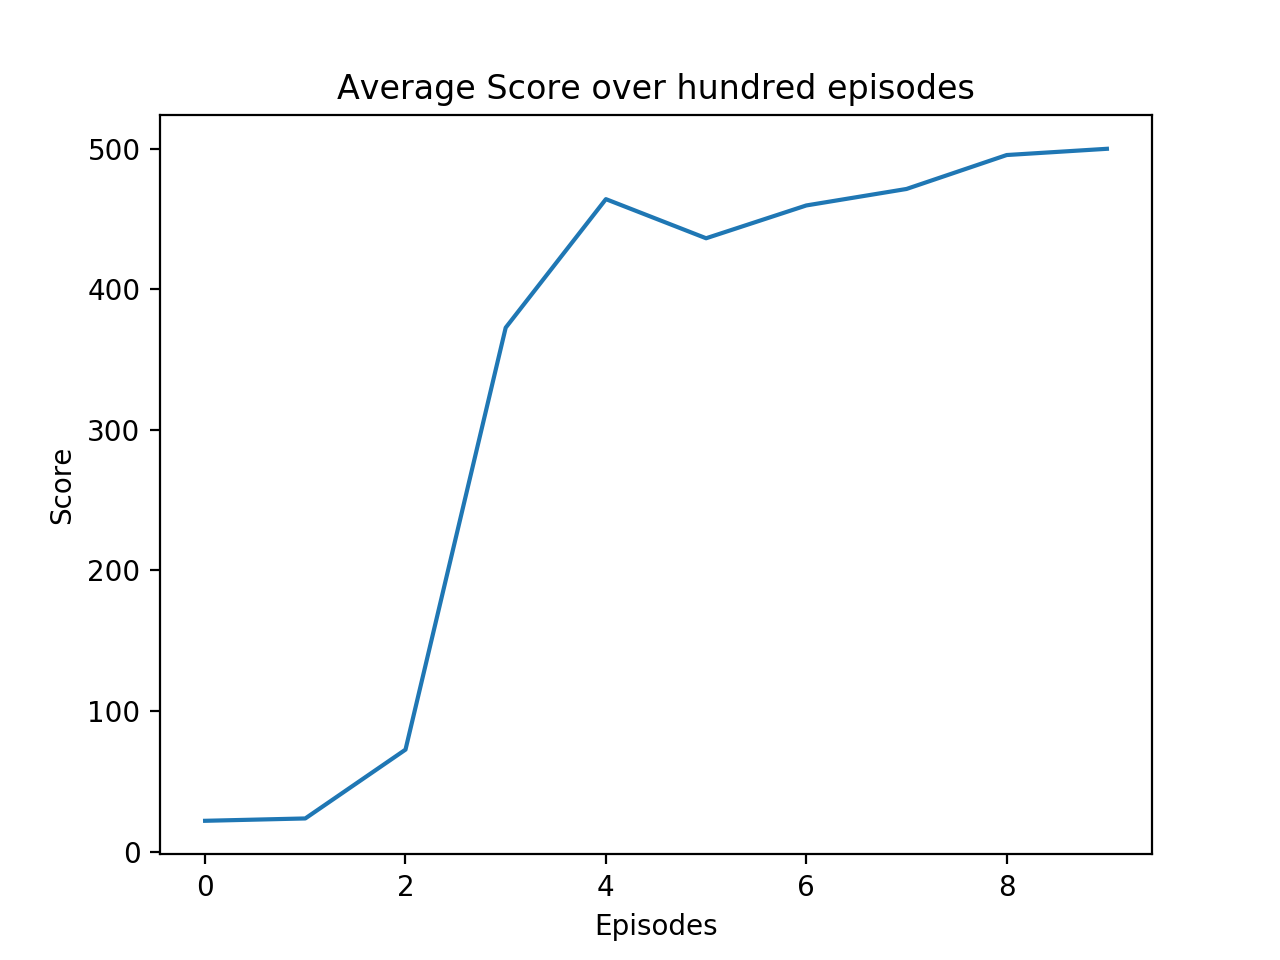

<IPython.core.display.Javascript object>


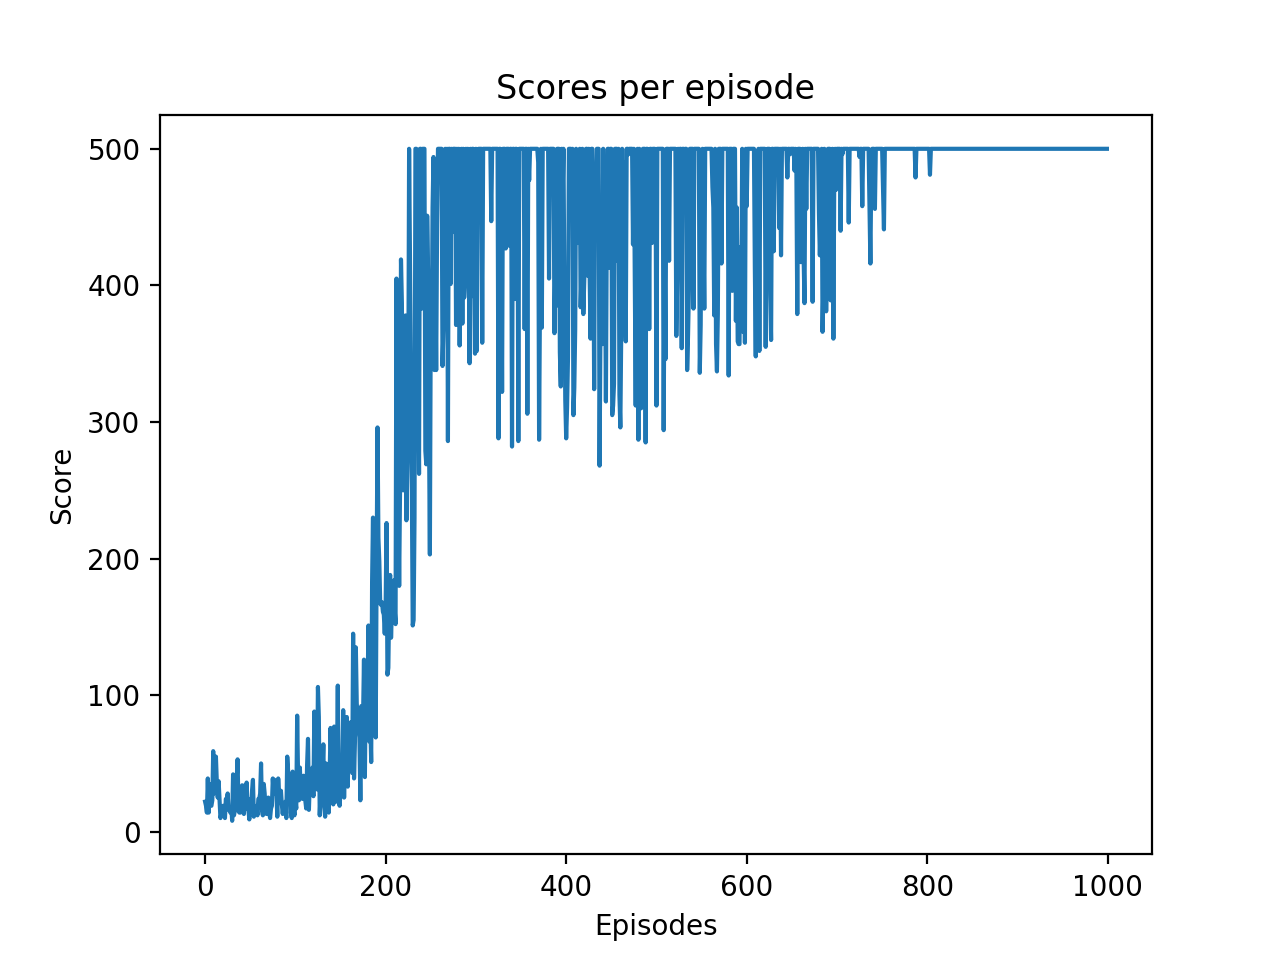

Text(0.5,1,'Scores per episode')

In [8]:
%matplotlib notebook
plt.figure()
plt.plot(averageScoreDoubleDuel)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.figure()
plt.plot(scoresDoubleDuel)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per episode')

#### Implement the normal Deep Q Learning network just for comparison purposes

In [9]:
##Choice of the architecture of the Deep Q Network and the learning rate make a big difference in the learning process
##Choose 3 fully connected networks with 4->64->128->2 output with Adam and learning rate as 0.0001
##Seems to work well with 2 hidden layers and performance deteriorates when the hidden layer is increased by 1.
env=gym.make('CartPole-v1')
nGames=1000
scoresDeepQ=[]
averageScoreDeepQ=[]
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.fc1=nn.Linear(*observationSpace,64)
        self.fc2=nn.Linear(64,128)
        self.fc3=nn.Linear(128,actionSpace)
    def forward(self,observation):
        output=F.relu(self.fc1(observation))
        output=F.relu(self.fc2(output))
        output=self.fc3(output)
        return output
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
QTarget=QNetwork(env.observation_space.shape,env.action_space.n)
Qupdate.to(device)
QTarget.to(device)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
memorySize=50000
batchSize=16
indices=[i for i in range(batchSize)]
replayMemory=[0 for i in range(memorySize)]
epsilon=1
epsilonDec=1e-4
epsilonMin=0.01
gamma=0.99
memoryCounter=0
counter=0
replace=4
def decrementEpsilon(epsilon,epsilonDec,epsilonMin):
    if epsilon>epsilonMin:
        epsilon-=epsilonDec
    else:
        epsilon=epsilonMin
    return epsilon
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        if np.random.random()>epsilon:
            with torch.no_grad():
                action=Qupdate(torch.Tensor(observation).to(device))
                action=torch.argmax(action).item()
        else:
            action=env.action_space.sample()
        newObservation,reward,done,info=env.step(action)
        index=memoryCounter%memorySize
        d=dict()
        d['observation']=observation
        d['newObservation']=newObservation
        d['reward']=reward
        d['done']=done
        d['action']=action
        replayMemory[index]=d
        totalReward+=reward
        memoryCounter+=1
        if memoryCounter>=batchSize:
            optimizer.zero_grad()
            if counter%replace==0:
                QTarget.load_state_dict(Qupdate.state_dict())
            if memoryCounter<=memorySize:
                maxMem=memoryCounter
            else:
                maxMem=memorySize
            numbers=[i for i in range(maxMem)]
            sampleIndices=sample(numbers,batchSize)
            sampledObservations=list()
            sampledNewObservations=list()
            sampledrewards=list()
            sampledActions=list()
            sampledTerminalStates=list()
            for ele in sampleIndices:
                sampledObservations.append(replayMemory[ele]['observation'])
                sampledNewObservations.append(replayMemory[ele]['newObservation'])
                sampledrewards.append(replayMemory[ele]['reward'])
                sampledTerminalStates.append(replayMemory[ele]['done'])
                sampledActions.append(replayMemory[ele]['action'])
            batchQValue=Qupdate(torch.Tensor(sampledObservations).to(device))
            qValueCurrentState=torch.empty(batchSize).to(device)
            qValueNextState=torch.max(QTarget(torch.Tensor(sampledNewObservations).to(device)),1)[0]
            for j in range(batchSize):
                if sampledTerminalStates[j] is True:
                    qValueNextState[j]=0.0
                qValueCurrentState[j]=batchQValue[j][sampledActions[j]]
            y=(torch.Tensor(sampledrewards).to(device)+gamma*qValueNextState).detach()
            loss=criterion(y,qValueCurrentState).to(device)
            loss.backward()
            optimizer.step()
            epsilon=decrementEpsilon(epsilon,epsilonDec,epsilonMin)
            counter+=1
        observation=newObservation
    scoresDeepQ.append(totalReward)
    if i%100==0:
        averageScoreDeepQ.append(np.mean(scoresDeepQ[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scoresDeepQ[-100:]):.2f},score {totalReward:.2f},epsilon {epsilon:.2f}')
        
        

epsiode 0,Average Score 19.00,score 19.00,epsilon 1.00
epsiode 100,Average Score 21.78,score 24.00,epsilon 0.78
epsiode 200,Average Score 34.87,score 14.00,epsilon 0.43
epsiode 300,Average Score 112.52,score 119.00,epsilon 0.01
epsiode 400,Average Score 262.06,score 500.00,epsilon 0.01
epsiode 500,Average Score 455.72,score 360.00,epsilon 0.01
epsiode 600,Average Score 450.42,score 393.00,epsilon 0.01
epsiode 700,Average Score 466.33,score 500.00,epsilon 0.01
epsiode 800,Average Score 497.06,score 500.00,epsilon 0.01
epsiode 900,Average Score 461.29,score 11.00,epsilon 0.01


<IPython.core.display.Javascript object>


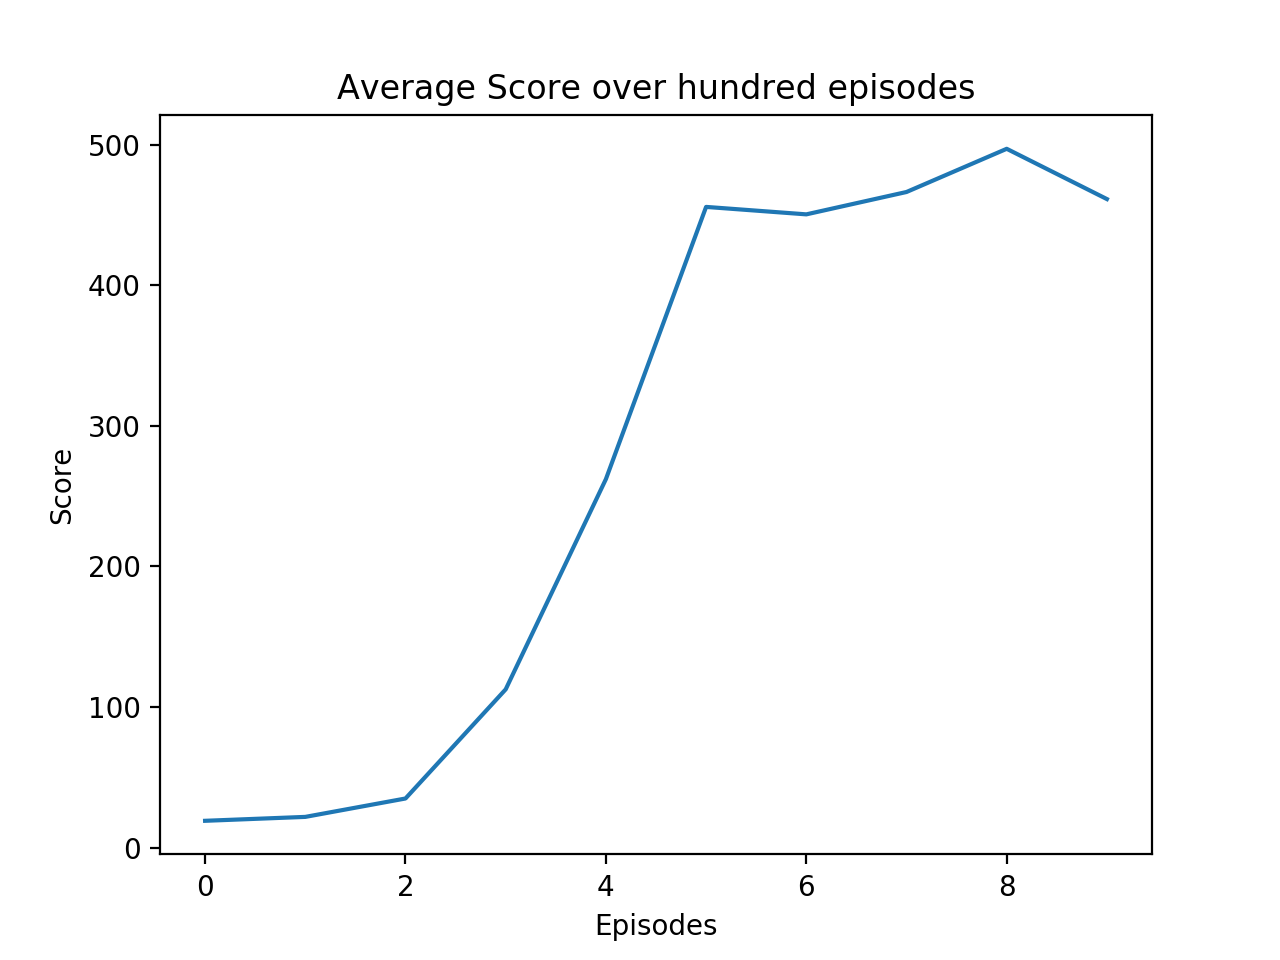

<IPython.core.display.Javascript object>


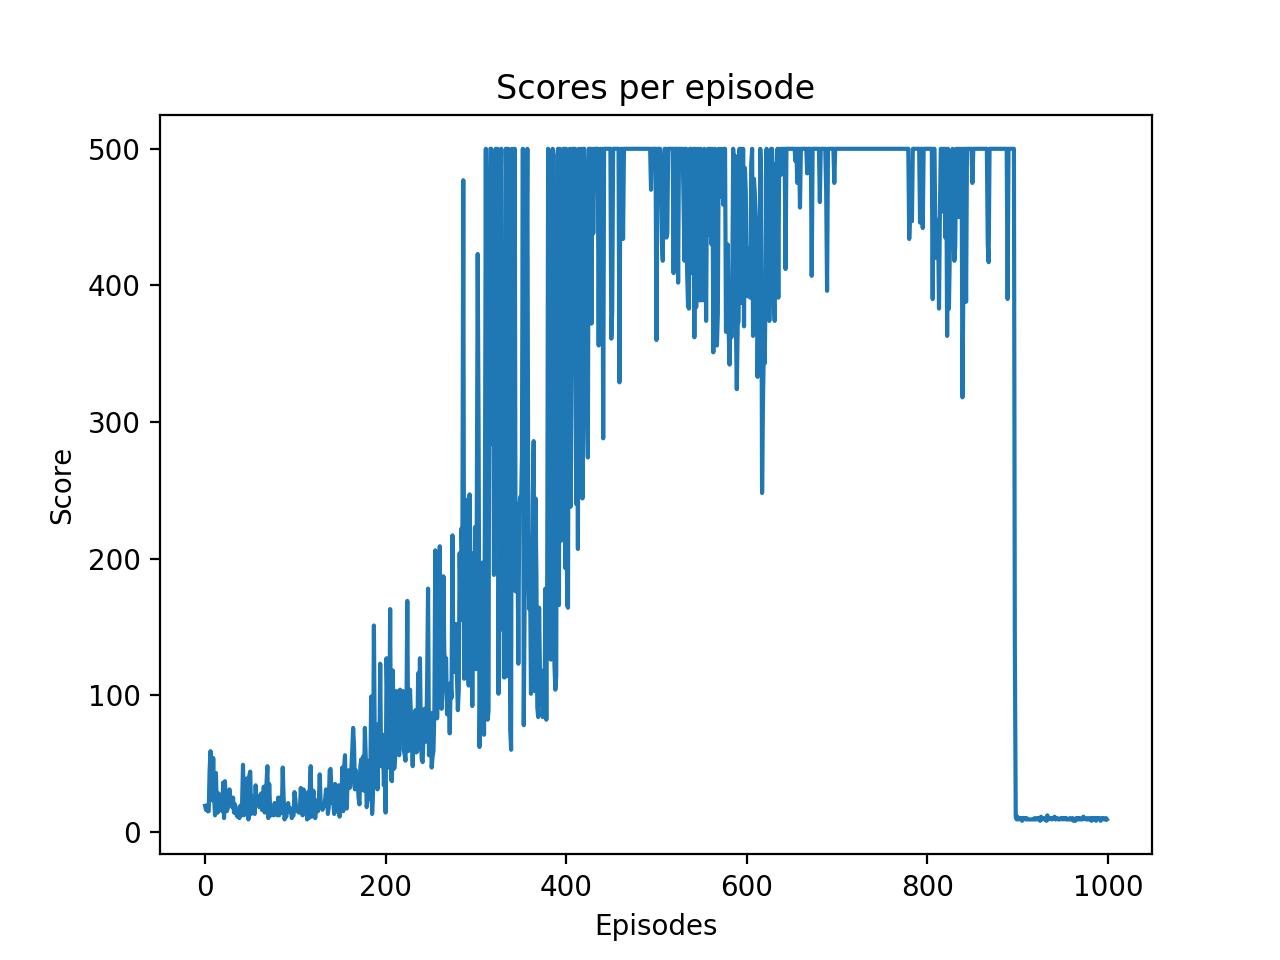

Text(0.5,1,'Scores per episode')

In [15]:
%matplotlib notebook
plt.figure()
plt.plot(averageScoreDeepQ)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.figure()
plt.plot(scoresDeepQ)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per episode')

In [10]:
##Choice of the architecture of the Deep Q Network and the learning rate make a big difference in the learning process
##Choose 3 fully connected networks with 4->64->128->2 output with Adam and learning rate as 0.0001
##Seems to work well with 2 hidden layers and performance deteriorates when the hidden layer is increased by 1.
env=gym.make('CartPole-v1')
nGames=1000
scoresDeepQ=[]
averageScoreDeepQ=[]
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.fc1=nn.Linear(*observationSpace,64)
        self.fc2=nn.Linear(64,128)
        self.fc3=nn.Linear(128,actionSpace)
    def forward(self,observation):
        output=F.relu(self.fc1(observation))
        output=F.relu(self.fc2(output))
        output=self.fc3(output)
        return output
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
QTarget=QNetwork(env.observation_space.shape,env.action_space.n)
Qupdate.to(device)
QTarget.to(device)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
memorySize=50000
batchSize=16
indices=[i for i in range(batchSize)]
replayMemory=[0 for i in range(memorySize)]
epsilon=1
epsilonDec=1e-4
epsilonMin=0.01
gamma=0.99
memoryCounter=0
counter=0
replace=4
def decrementEpsilon(epsilon,epsilonDec,epsilonMin):
    if epsilon>epsilonMin:
        epsilon-=epsilonDec
    else:
        epsilon=epsilonMin
    return epsilon
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        if np.random.random()>epsilon:
            with torch.no_grad():
                action=Qupdate(torch.Tensor(observation).to(device))
                action=torch.argmax(action).item()
        else:
            action=env.action_space.sample()
        newObservation,reward,done,info=env.step(action)
        index=memoryCounter%memorySize
        d=dict()
        d['observation']=observation
        d['newObservation']=newObservation
        d['reward']=reward
        d['done']=done
        d['action']=action
        replayMemory[index]=d
        totalReward+=reward
        memoryCounter+=1
        if memoryCounter>=batchSize:
            optimizer.zero_grad()
            if counter%replace==0:
                QTarget.load_state_dict(Qupdate.state_dict())
            if memoryCounter<=memorySize:
                maxMem=memoryCounter
            else:
                maxMem=memorySize
            numbers=[i for i in range(maxMem)]
            sampleIndices=sample(numbers,batchSize)
            sampledObservations=list()
            sampledNewObservations=list()
            sampledrewards=list()
            sampledActions=list()
            sampledTerminalStates=list()
            for ele in sampleIndices:
                sampledObservations.append(replayMemory[ele]['observation'])
                sampledNewObservations.append(replayMemory[ele]['newObservation'])
                sampledrewards.append(replayMemory[ele]['reward'])
                sampledTerminalStates.append(replayMemory[ele]['done'])
                sampledActions.append(replayMemory[ele]['action'])
            batchQValue=Qupdate(torch.Tensor(sampledObservations).to(device))
            qValueCurrentState=torch.empty(batchSize).to(device)
            qValueNextState=torch.max(QTarget(torch.Tensor(sampledNewObservations).to(device)),1)[0]
            for j in range(batchSize):
                if sampledTerminalStates[j] is True:
                    qValueNextState[j]=0.0
                qValueCurrentState[j]=batchQValue[j][sampledActions[j]]
            y=(torch.Tensor(sampledrewards).to(device)+gamma*qValueNextState).detach()
            loss=criterion(y,qValueCurrentState).to(device)
            loss.backward()
            optimizer.step()
            epsilon=decrementEpsilon(epsilon,epsilonDec,epsilonMin)
            counter+=1
        observation=newObservation
    #counter+=1
    scoresDeepQ.append(totalReward)
    if i%100==0:
        averageScoreDeepQ.append(np.mean(scoresDeepQ[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scoresDeepQ[-100:]):.2f},score {totalReward:.2f},epsilon {epsilon:.2f}')
        
        

epsiode 0,Average Score 17.00,score 17.00,epsilon 1.00
epsiode 100,Average Score 20.58,score 17.00,epsilon 0.79
epsiode 200,Average Score 23.18,score 45.00,epsilon 0.56
epsiode 300,Average Score 69.17,score 69.00,epsilon 0.01
epsiode 400,Average Score 256.32,score 500.00,epsilon 0.01
epsiode 500,Average Score 442.15,score 331.00,epsilon 0.01
epsiode 600,Average Score 390.83,score 500.00,epsilon 0.01
epsiode 700,Average Score 498.81,score 500.00,epsilon 0.01
epsiode 800,Average Score 500.00,score 500.00,epsilon 0.01
epsiode 900,Average Score 500.00,score 500.00,epsilon 0.01


<IPython.core.display.Javascript object>


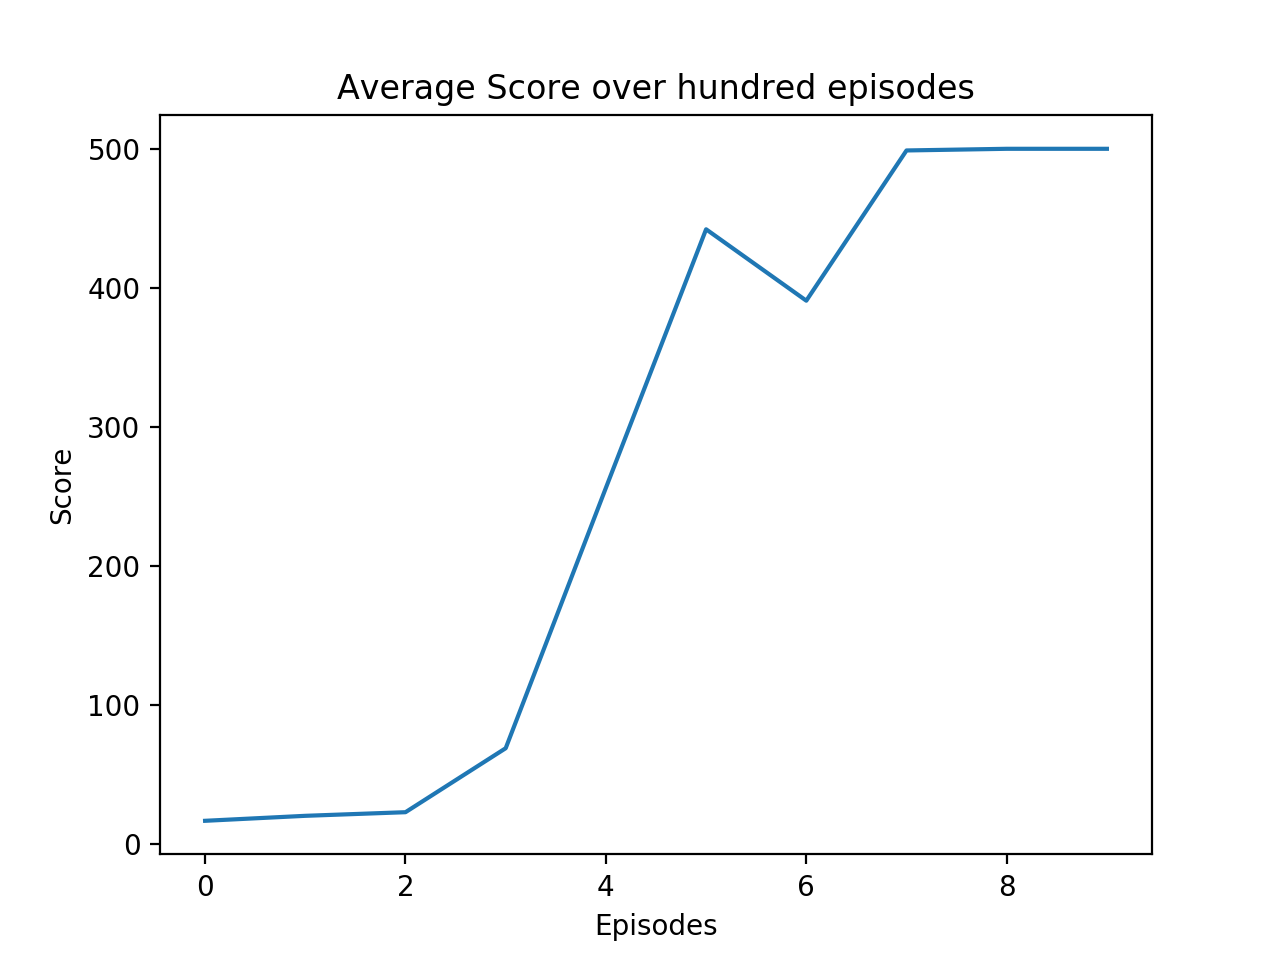

<IPython.core.display.Javascript object>


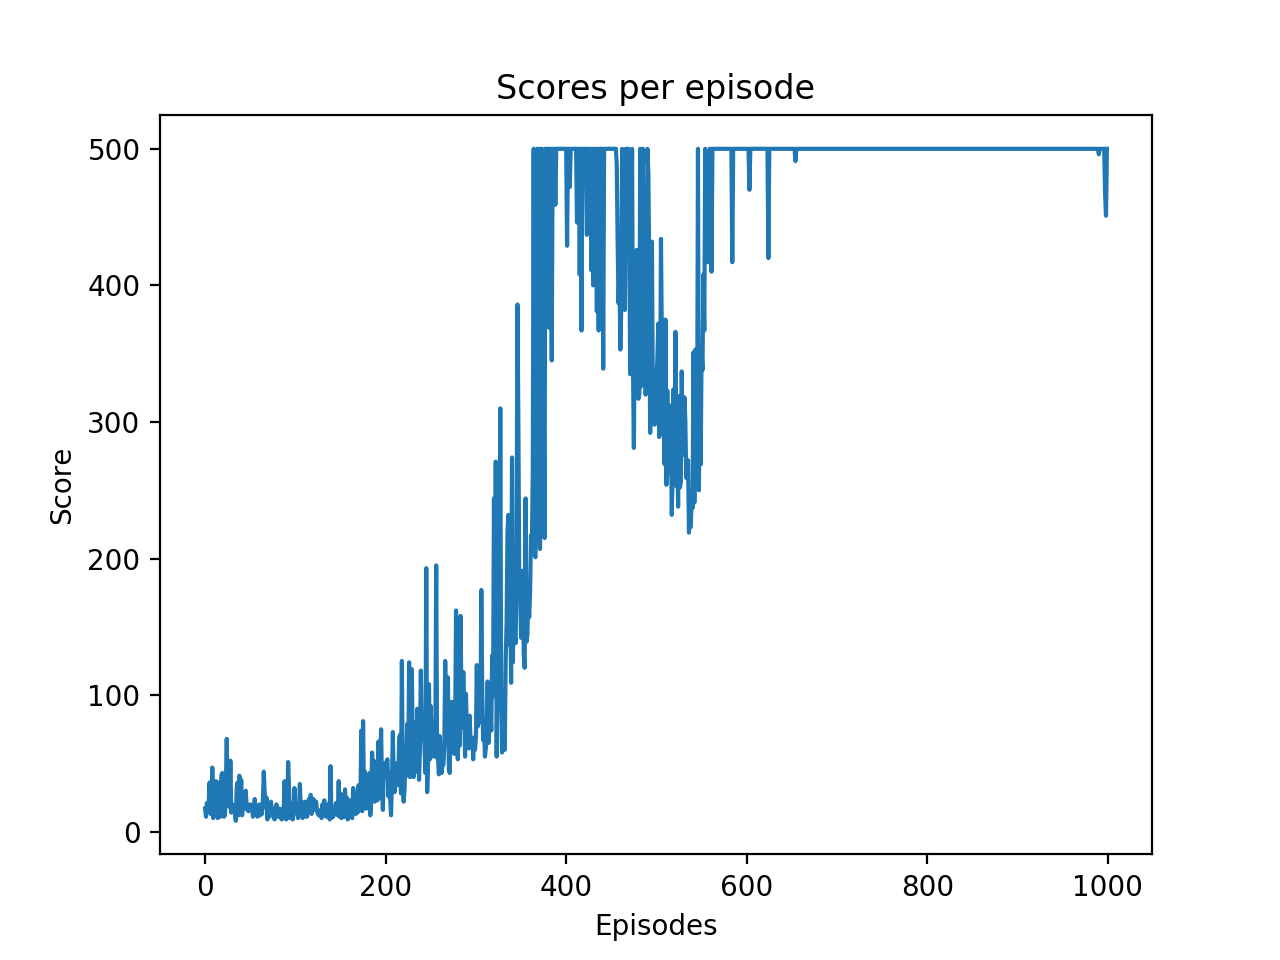

Text(0.5,1,'Scores per episode')

In [19]:
%matplotlib notebook
plt.figure()
plt.plot(averageScoreDeepQ)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.figure()
plt.plot(scoresDeepQ)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per episode')

#### Comparsion between all the variants of the Deep Q Implemented

<IPython.core.display.Javascript object>


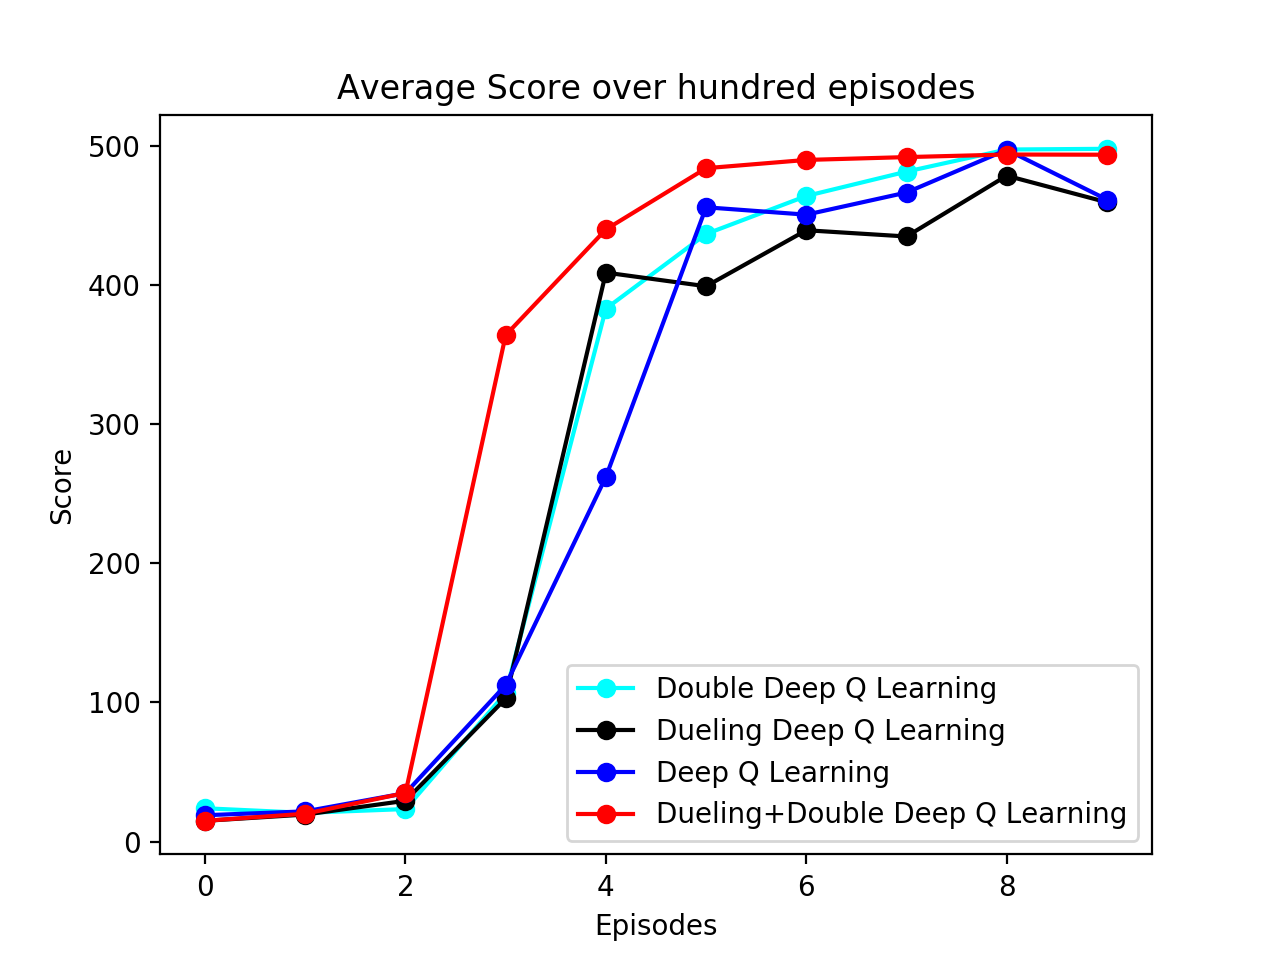

In [16]:
##For first run of all the algorithms
%matplotlib notebook
plt.figure()
plt.plot(averageScoreDouble,color='cyan',marker='o',label='Double Deep Q Learning')
plt.plot(averageScoreDuel,color='black',marker='o',label='Dueling Deep Q Learning')
plt.plot(averageScoreDeepQ,color='blue',marker='o',label='Deep Q Learning')
plt.plot(averageScoreDoubleDuel,color='red',marker='o',label='Dueling+Double Deep Q Learning')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.legend()

<IPython.core.display.Javascript object>


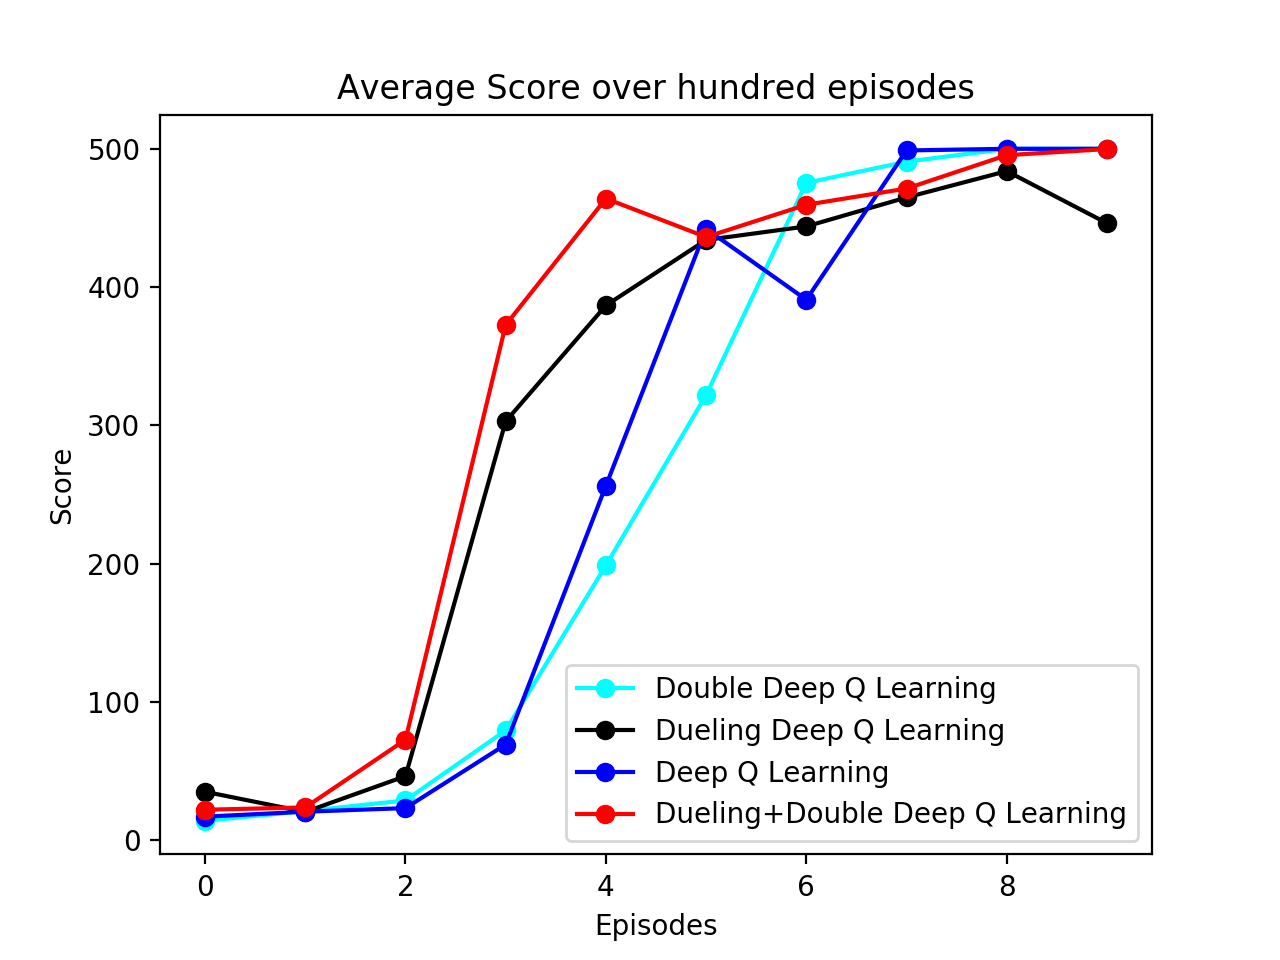

In [20]:
##For second run of all the algorithms
%matplotlib notebook
plt.figure()
plt.plot(averageScoreDouble,color='cyan',marker='o',label='Double Deep Q Learning')
plt.plot(averageScoreDuel,color='black',marker='o',label='Dueling Deep Q Learning')
plt.plot(averageScoreDeepQ,color='blue',marker='o',label='Deep Q Learning')
plt.plot(averageScoreDoubleDuel,color='red',marker='o',label='Dueling+Double Deep Q Learning')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.legend()

## Policy Gradient Techniques:
Tried to apply the reinforce,reinforce with baseline and actor-critic methods learnt in class on the cart pole environment using the exact same hyperparameters as above and following the same algorihtms mentioned in the slides just that it has been applied to maximise the reward and not minimise a cost.

## Reinforce

In [17]:
##Policy Gradient--Reinforce
env=gym.make('CartPole-v1')
nGames=1000
scoresReinforce=[]
averageScoreReinforce=[]
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.fc1=nn.Linear(*observationSpace,64)
        self.fc2=nn.Linear(64,128)
        self.fc3=nn.Linear(128,256)
        self.fc4=nn.Linear(256,actionSpace)
    def forward(self,observation):
        output=F.relu(self.fc1(observation))
        output=F.relu(self.fc2(output))
        output=F.relu(self.fc3(output))
        output=self.fc4(output)
        return F.softmax(output)
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
Qupdate.to(device)
optimizer=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
actionMemory=list()
rewardMemory=list()
gamma=0.99
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        actionSoftmax=Qupdate(torch.Tensor(observation).to(device))
        #print(np.random.choice(env.action_space.n,1,p=actionSoftmax.detach().numpy())[0])
        action=np.random.choice(env.action_space.n,1,p=actionSoftmax.detach().cpu().numpy())
        newObservation,reward,done,info=env.step(action[0])
        totalReward+=reward
        actionMemory.append(torch.log(actionSoftmax[action]))
        rewardMemory.append(reward)
        observation=newObservation
    scoresReinforce.append(totalReward)
    for j in range(len(actionMemory)):
        gValue=0.0
        loss=0.0
        optimizer.zero_grad()
        for k in range(j,len(actionMemory)):
            gValue+=(gamma**k)*rewardMemory[k]
        loss=(-(gamma**j)*gValue*actionMemory[j]).to(device)
        loss.backward()
        optimizer.step()
    actionMemory=list()
    rewardMemory=list()
    if i%100==0:
        averageScoreReinforce.append(np.mean(scoresReinforce[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scoresReinforce[-100:]):.2f},score {totalReward:.2f}')

epsiode 0,Average Score 30.00,score 30.00
epsiode 100,Average Score 39.88,score 67.00
epsiode 200,Average Score 71.62,score 64.00
epsiode 300,Average Score 55.37,score 45.00
epsiode 400,Average Score 80.68,score 47.00
epsiode 500,Average Score 137.66,score 43.00
epsiode 600,Average Score 153.99,score 30.00
epsiode 700,Average Score 229.78,score 260.00
epsiode 800,Average Score 308.73,score 194.00
epsiode 900,Average Score 135.65,score 98.00


<IPython.core.display.Javascript object>


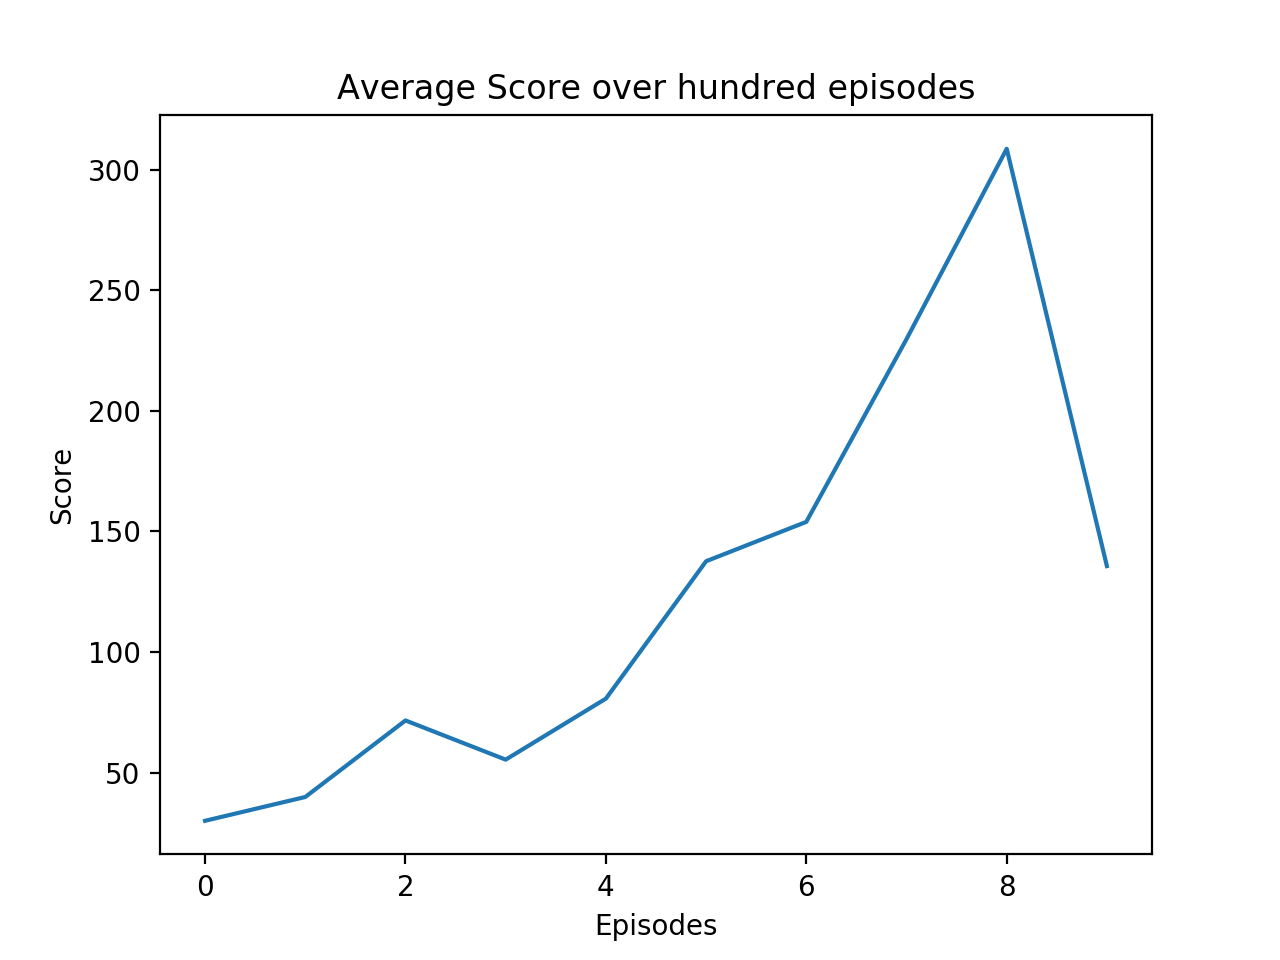

<IPython.core.display.Javascript object>


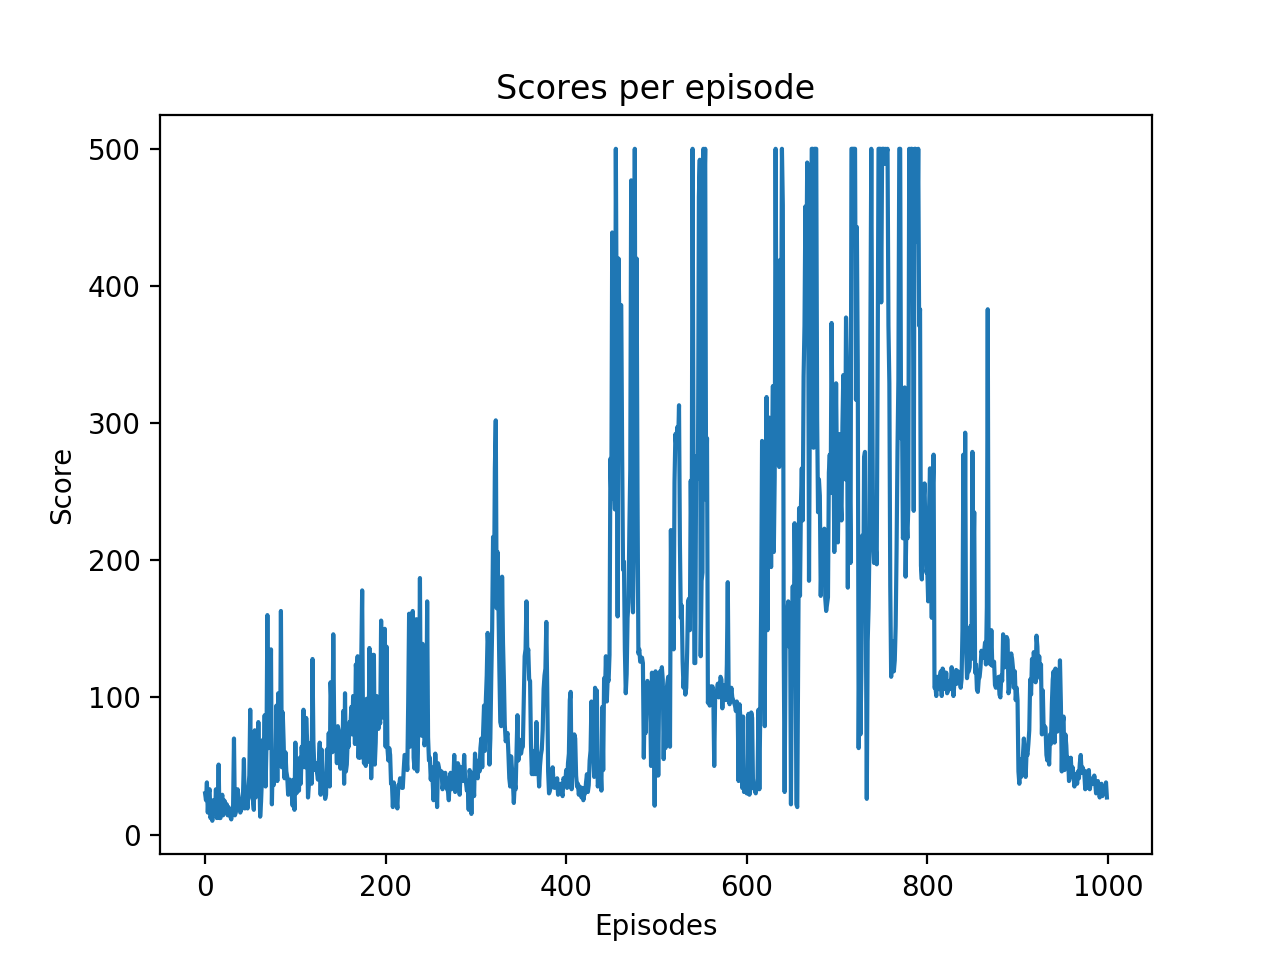

Text(0.5,1,'Scores per episode')

In [18]:
%matplotlib notebook
plt.figure()
plt.plot(averageScoreReinforce)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.figure()
plt.plot(scoresReinforce)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per episode')

In [13]:
##Policy Gradient--Reinforce
env=gym.make('CartPole-v1')
nGames=1000
scoresReinforce=[]
averageScoreReinforce=[]
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.fc1=nn.Linear(*observationSpace,64)
        self.fc2=nn.Linear(64,128)
        self.fc3=nn.Linear(128,256)
        self.fc4=nn.Linear(256,actionSpace)
    def forward(self,observation):
        output=F.relu(self.fc1(observation))
        output=F.relu(self.fc2(output))
        output=F.relu(self.fc3(output))
        output=self.fc4(output)
        return F.softmax(output)
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
Qupdate.to(device)
optimizer=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
actionMemory=list()
rewardMemory=list()
gamma=0.99
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        actionSoftmax=Qupdate(torch.Tensor(observation).to(device))
        #print(np.random.choice(env.action_space.n,1,p=actionSoftmax.detach().numpy())[0])
        action=np.random.choice(env.action_space.n,1,p=actionSoftmax.detach().cpu().numpy())
        newObservation,reward,done,info=env.step(action[0])
        totalReward+=reward
        actionMemory.append(torch.log(actionSoftmax[action]))
        rewardMemory.append(reward)
        observation=newObservation
    scoresReinforce.append(totalReward)
    for j in range(len(actionMemory)):
        gValue=0.0
        loss=0.0
        optimizer.zero_grad()
        for k in range(j,len(actionMemory)):
            gValue+=(gamma**k)*rewardMemory[k]
        loss=(-(gamma**j)*gValue*actionMemory[j]).to(device)
        loss.backward()
        optimizer.step()
    actionMemory=list()
    rewardMemory=list()
    if i%100==0:
        averageScoreReinforce.append(np.mean(scoresReinforce[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scoresReinforce[-100:]):.2f},score {totalReward:.2f}')

epsiode 0,Average Score 23.00,score 23.00
epsiode 100,Average Score 39.87,score 69.00
epsiode 200,Average Score 71.92,score 48.00
epsiode 300,Average Score 99.79,score 53.00
epsiode 400,Average Score 92.29,score 72.00
epsiode 500,Average Score 87.70,score 97.00
epsiode 600,Average Score 70.86,score 49.00
epsiode 700,Average Score 94.47,score 237.00
epsiode 800,Average Score 98.51,score 97.00
epsiode 900,Average Score 98.34,score 52.00


<IPython.core.display.Javascript object>


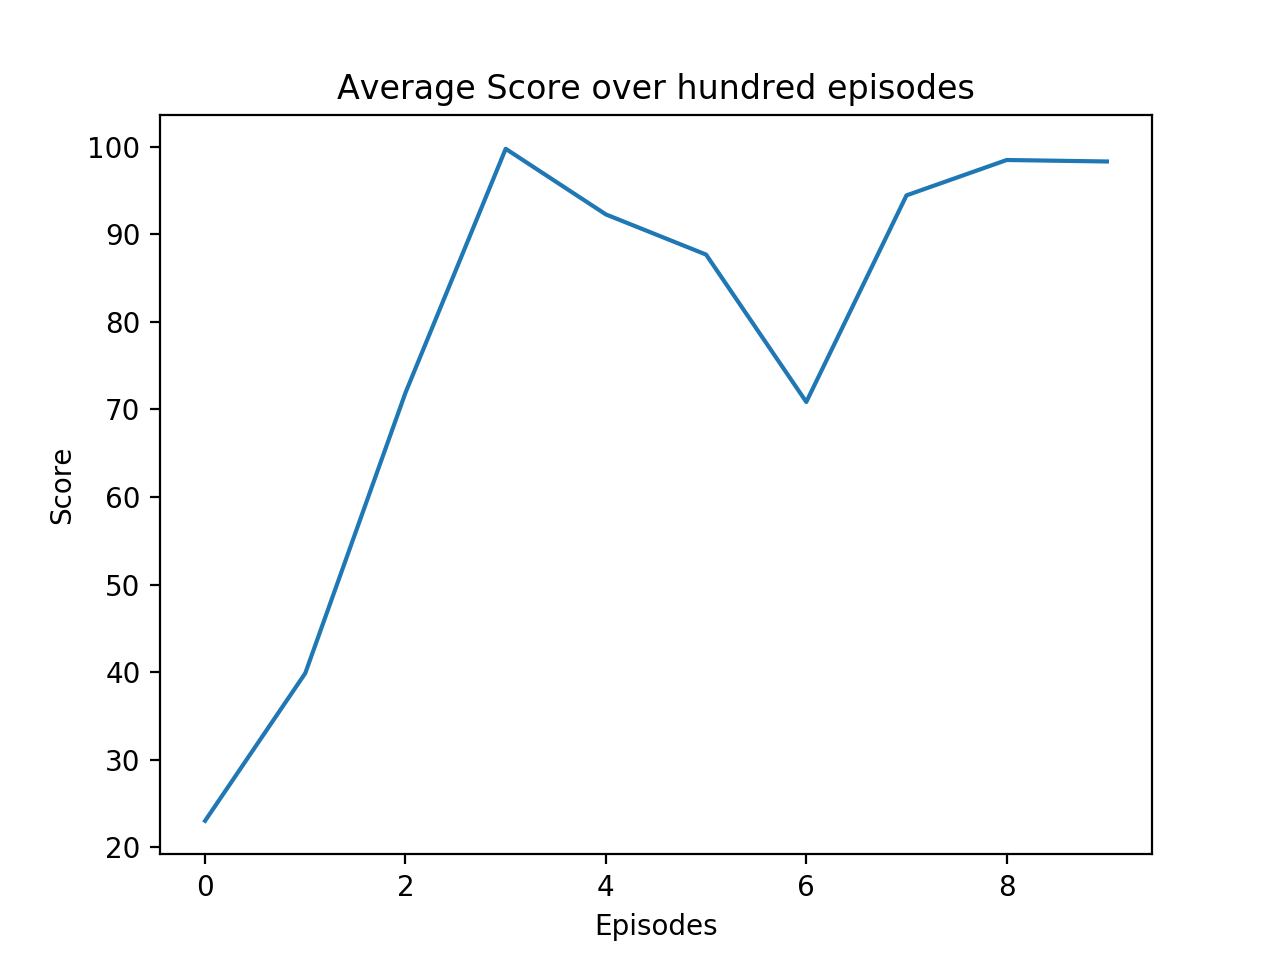

<IPython.core.display.Javascript object>


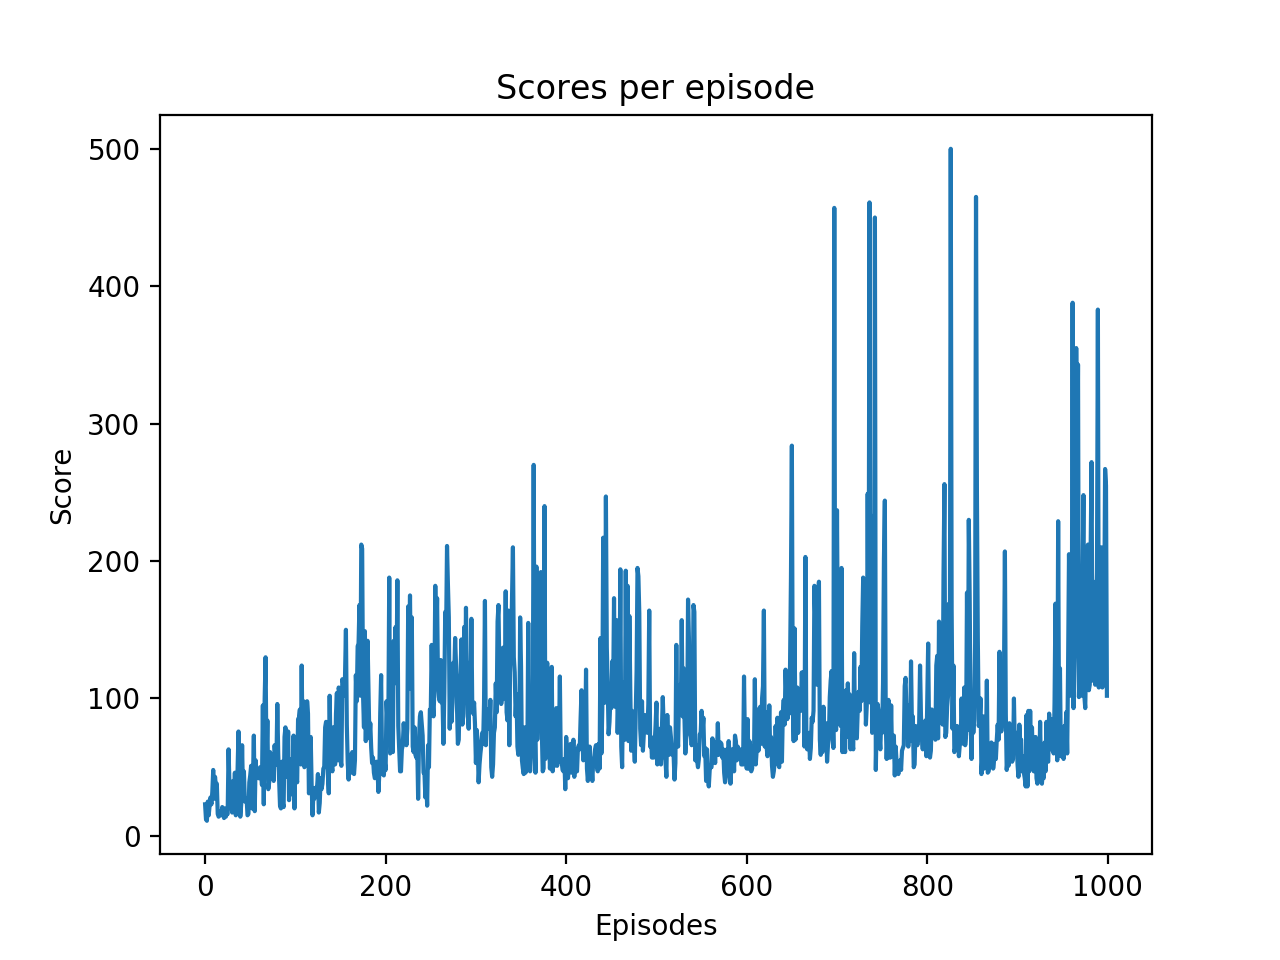

Text(0.5,1,'Scores per episode')

In [21]:
%matplotlib notebook
plt.figure()
plt.plot(averageScoreReinforce)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.figure()
plt.plot(scoresReinforce)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per episode')

## Reinforce With Baseline

In [19]:
##Policy Gradient--Reinforce with Baseline
env=gym.make('CartPole-v1')
nGames=1000
scoresReinforceBaseline=[]
averageScoreReinforceBaseline=[]
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.fc1=nn.Linear(*observationSpace,64)
        self.fc2=nn.Linear(64,128)
        self.fc3=nn.Linear(128,256)
        self.fc4=nn.Linear(256,actionSpace)
    def forward(self,observation):
        output=F.relu(self.fc1(observation))
        output=F.relu(self.fc2(output))
        output=F.relu(self.fc3(output))
        output=self.fc4(output)
        return output
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
##Policy Network
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
##Value Network
QTarget=QNetwork(env.observation_space.shape,1)
Qupdate.to(device)
QTarget.to(device)
optimizerUpdate=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
optimizerTarget=torch.optim.Adam(QTarget.parameters(),lr=0.0001)
actionMemory=list()
rewardMemory=list()
value=list()
gamma=0.99
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        actionSoftmax=F.softmax(Qupdate(torch.Tensor(observation).to(device)))
        #print(np.random.choice(env.action_space.n,1,p=actionSoftmax.detach().numpy())[0])
        action=np.random.choice(env.action_space.n,1,p=actionSoftmax.detach().cpu().numpy())
        newObservation,reward,done,info=env.step(action[0])
        valueFunction=QTarget(torch.Tensor(observation).to(device))
        totalReward+=reward
        actionMemory.append(torch.log(actionSoftmax[action]))
        rewardMemory.append(reward)
        value.append(valueFunction)
        observation=newObservation
    scoresReinforceBaseline.append(totalReward)
    for j in range(len(actionMemory)):
        gValue=0.0
        lossUpdate=0.0
        lossTarget=0.0
        optimizerUpdate.zero_grad()
        optimizerTarget.zero_grad()
        for k in range(j,len(actionMemory)):
            gValue+=(gamma**k)*rewardMemory[k]
        deltaValue=gValue-value[j].item()
        lossUpdate=(-(gamma**j)*deltaValue*actionMemory[j]).to(device)
        lossTarget=(-(gamma**j)*deltaValue*value[j]).to(device)
        lossUpdate.backward()
        lossTarget.backward()
        optimizerUpdate.step()
        optimizerTarget.step()
    actionMemory=list()
    rewardMemory=list()
    value=list()
    if i%100==0:
        averageScoreReinforceBaseline.append(np.mean(scoresReinforceBaseline[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scoresReinforceBaseline[-100:]):.2f},score {totalReward:.2f}')

epsiode 0,Average Score 46.00,score 46.00
epsiode 100,Average Score 35.31,score 34.00
epsiode 200,Average Score 67.77,score 144.00
epsiode 300,Average Score 139.78,score 310.00
epsiode 400,Average Score 177.70,score 43.00
epsiode 500,Average Score 222.75,score 437.00
epsiode 600,Average Score 106.32,score 121.00
epsiode 700,Average Score 153.20,score 149.00
epsiode 800,Average Score 160.91,score 135.00
epsiode 900,Average Score 114.60,score 146.00


<IPython.core.display.Javascript object>


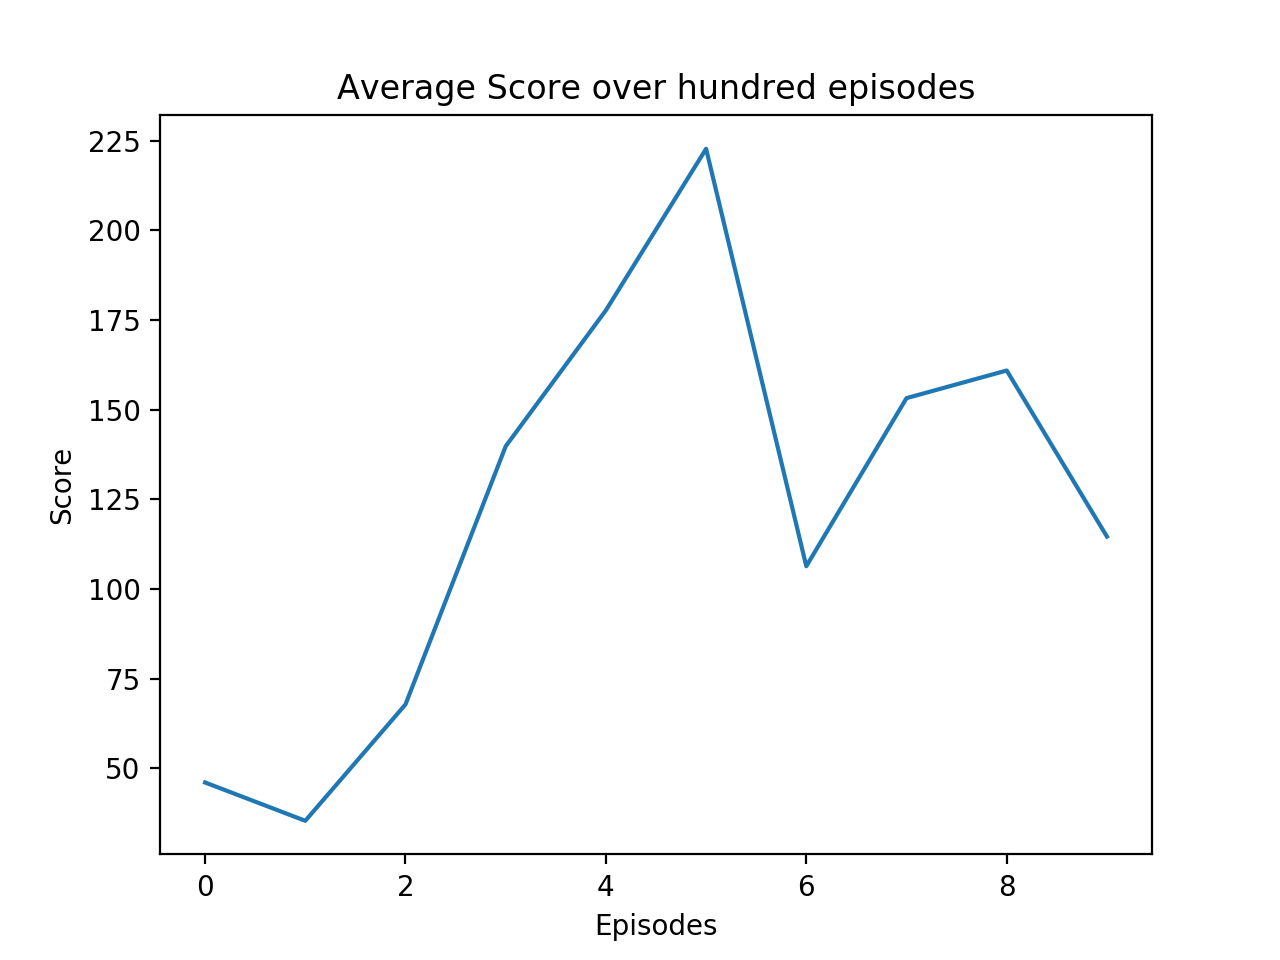

<IPython.core.display.Javascript object>


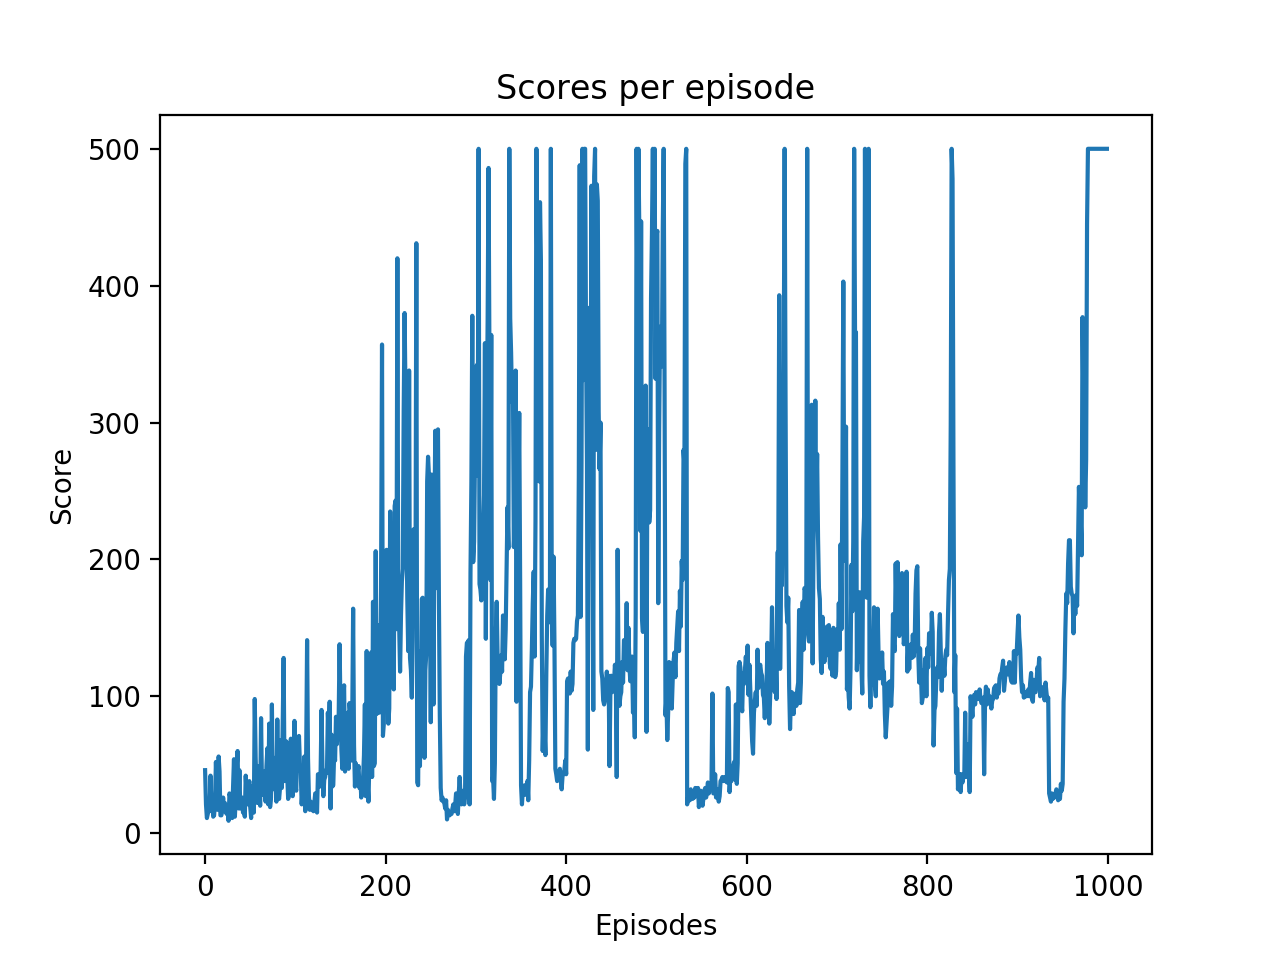

Text(0.5,1,'Scores per episode')

In [20]:
%matplotlib notebook
plt.figure()
plt.plot(averageScoreReinforceBaseline)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.figure()
plt.plot(scoresReinforceBaseline)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per episode')

In [15]:
##Policy Gradient--Reinforce with Baseline
env=gym.make('CartPole-v1')
nGames=1000
scoresReinforceBaseline=[]
averageScoreReinforceBaseline=[]
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.fc1=nn.Linear(*observationSpace,64)
        self.fc2=nn.Linear(64,128)
        self.fc3=nn.Linear(128,256)
        self.fc4=nn.Linear(256,actionSpace)
    def forward(self,observation):
        output=F.relu(self.fc1(observation))
        output=F.relu(self.fc2(output))
        output=F.relu(self.fc3(output))
        output=self.fc4(output)
        return output
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
##Policy Network
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
##Value Network
QTarget=QNetwork(env.observation_space.shape,1)
Qupdate.to(device)
QTarget.to(device)
optimizerUpdate=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
optimizerTarget=torch.optim.Adam(QTarget.parameters(),lr=0.0001)
actionMemory=list()
rewardMemory=list()
value=list()
gamma=0.99
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        actionSoftmax=F.softmax(Qupdate(torch.Tensor(observation).to(device)))
        #print(np.random.choice(env.action_space.n,1,p=actionSoftmax.detach().numpy())[0])
        action=np.random.choice(env.action_space.n,1,p=actionSoftmax.detach().cpu().numpy())
        newObservation,reward,done,info=env.step(action[0])
        valueFunction=QTarget(torch.Tensor(observation).to(device))
        totalReward+=reward
        actionMemory.append(torch.log(actionSoftmax[action]))
        rewardMemory.append(reward)
        value.append(valueFunction)
        observation=newObservation
    scoresReinforceBaseline.append(totalReward)
    for j in range(len(actionMemory)):
        gValue=0.0
        lossUpdate=0.0
        lossTarget=0.0
        optimizerUpdate.zero_grad()
        optimizerTarget.zero_grad()
        for k in range(j,len(actionMemory)):
            gValue+=(gamma**k)*rewardMemory[k]
        deltaValue=gValue-value[j].item()
        lossUpdate=(-(gamma**j)*deltaValue*actionMemory[j]).to(device)
        lossTarget=(-(gamma**j)*deltaValue*value[j]).to(device)
        lossUpdate.backward()
        lossTarget.backward()
        optimizerUpdate.step()
        optimizerTarget.step()
    actionMemory=list()
    rewardMemory=list()
    value=list()
    if i%100==0:
        averageScoreReinforceBaseline.append(np.mean(scoresReinforceBaseline[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scoresReinforceBaseline[-100:]):.2f},score {totalReward:.2f}')

epsiode 0,Average Score 41.00,score 41.00
epsiode 100,Average Score 36.14,score 65.00
epsiode 200,Average Score 151.76,score 102.00
epsiode 300,Average Score 157.73,score 163.00
epsiode 400,Average Score 160.27,score 232.00
epsiode 500,Average Score 183.53,score 252.00
epsiode 600,Average Score 221.23,score 223.00
epsiode 700,Average Score 240.61,score 107.00
epsiode 800,Average Score 376.33,score 404.00
epsiode 900,Average Score 316.67,score 487.00


<IPython.core.display.Javascript object>


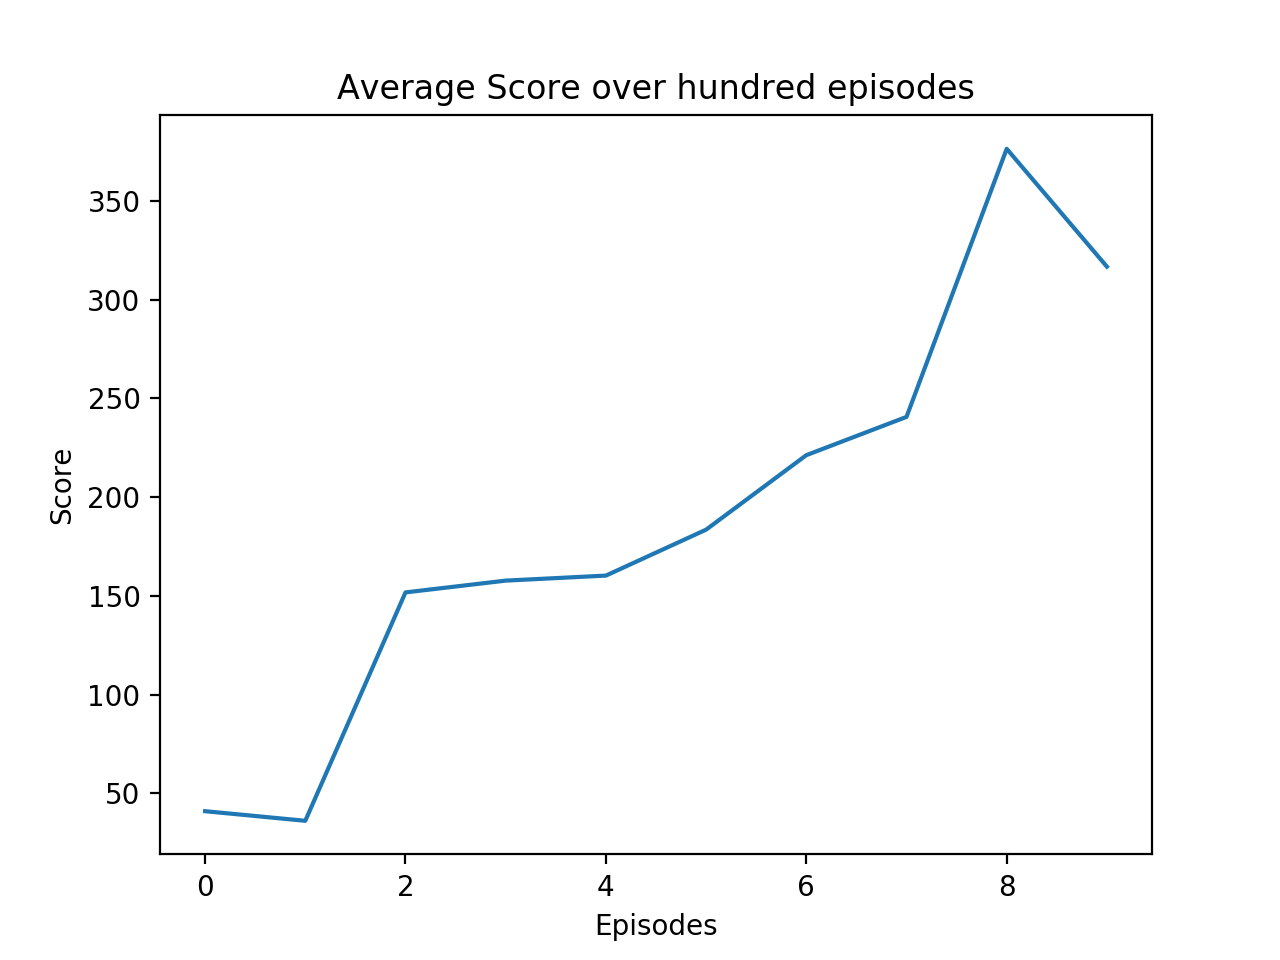

<IPython.core.display.Javascript object>


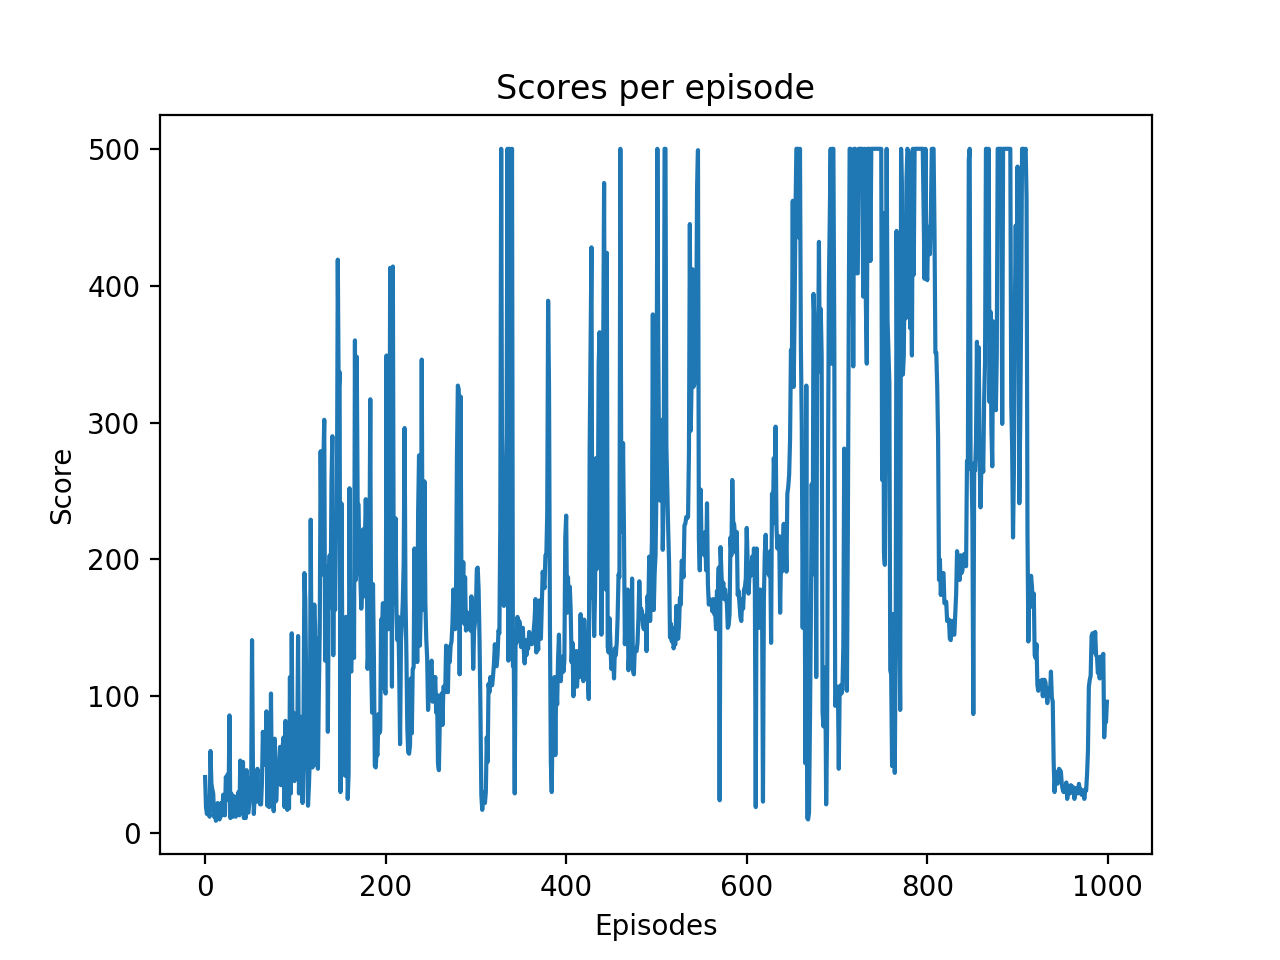

Text(0.5,1,'Scores per episode')

In [22]:
%matplotlib notebook
plt.figure()
plt.plot(averageScoreReinforceBaseline)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.figure()
plt.plot(scoresReinforceBaseline)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per episode')

## Actor Critic Algorithmn

In [22]:
##Policy Gradient--Actor Critic
env=gym.make('CartPole-v1')
nGames=1000
scoresAC=[]
averageScoreAC=[]
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.fc1=nn.Linear(*observationSpace,64)
        self.fc2=nn.Linear(64,128)
        self.fc3=nn.Linear(128,256)
        self.fc4=nn.Linear(256,actionSpace)
    def forward(self,observation):
        output=F.relu(self.fc1(observation))
        output=F.relu(self.fc2(output))
        output=F.relu(self.fc3(output))
        output=self.fc4(output)
        return output
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
##The below is the actor network
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
##The below is the critic network
QTarget=QNetwork(env.observation_space.shape,1)
Qupdate.to(device)
QTarget.to(device)
optimizerUpdate=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
optimizerTarget=torch.optim.Adam(QTarget.parameters(),lr=0.0001)
actionMemory=list()
rewardMemory=list()
value=list()
gamma=0.99
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        optimizerUpdate.zero_grad()
        optimizerTarget.zero_grad()
        actionSoftmax=F.softmax(Qupdate(torch.Tensor(observation).to(device)))
        #print(np.random.choice(env.action_space.n,1,p=actionSoftmax.detach().numpy())[0])
        action=np.random.choice(env.action_space.n,1,p=actionSoftmax.detach().cpu().numpy())
        newObservation,reward,done,info=env.step(action[0])
        valueFunction=QTarget(torch.Tensor(observation).to(device))
        valueFunctionNextState=QTarget(torch.Tensor(newObservation).to(device))
        totalReward+=reward
        if not done:
            delta=reward+gamma*valueFunctionNextState-valueFunction
        else:
            delta=reward-valueFunction
        actorLoss=(-delta.item()*torch.log(actionSoftmax[action])).to(device)
        criticLoss=(-delta.item()*valueFunction).to(device)
        actorLoss.backward()
        criticLoss.backward()
        optimizerUpdate.step()
        optimizerTarget.step()
        observation=newObservation
    scoresAC.append(totalReward)
    if i%100==0:
        averageScoreAC.append(np.mean(scoresAC[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scoresAC[-100:]):.2f},score {totalReward:.2f}')

epsiode 0,Average Score 26.00,score 26.00
epsiode 100,Average Score 21.75,score 24.00
epsiode 200,Average Score 30.47,score 43.00
epsiode 300,Average Score 61.95,score 118.00
epsiode 400,Average Score 104.26,score 96.00
epsiode 500,Average Score 77.78,score 112.00
epsiode 600,Average Score 228.04,score 183.00
epsiode 700,Average Score 278.19,score 257.00
epsiode 800,Average Score 120.53,score 296.00
epsiode 900,Average Score 246.60,score 164.00


<IPython.core.display.Javascript object>


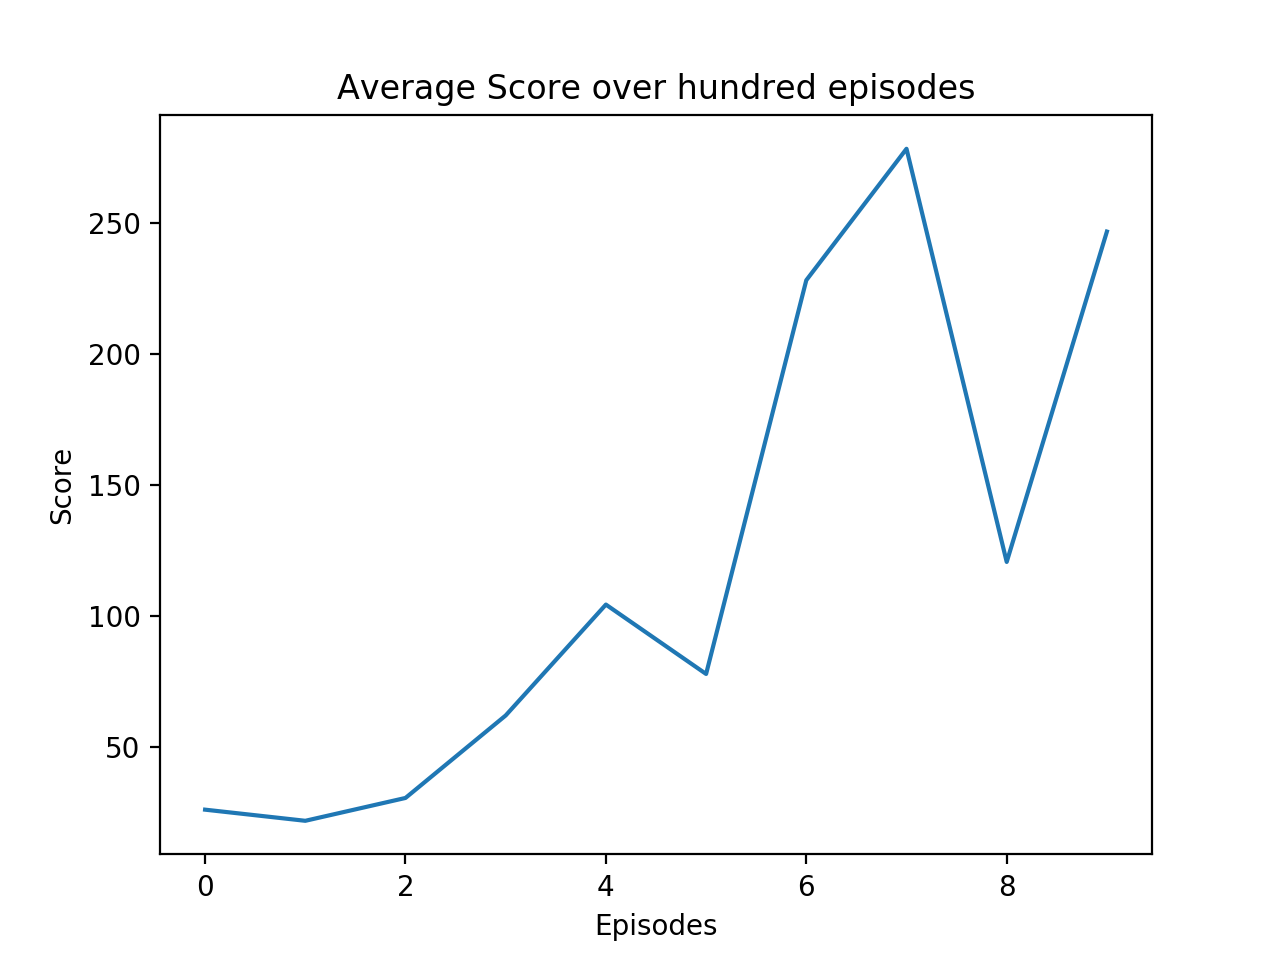

<IPython.core.display.Javascript object>


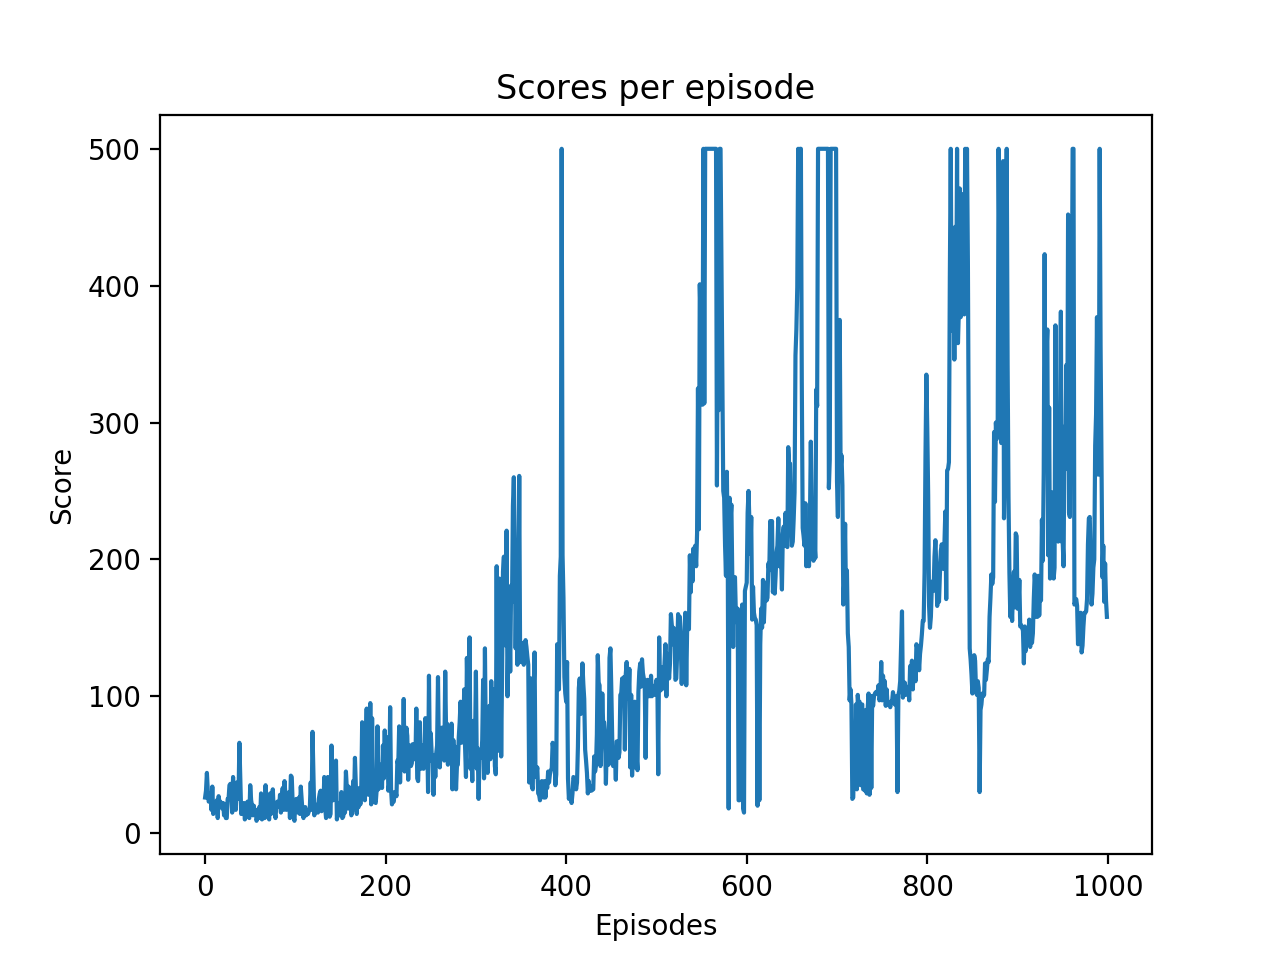

Text(0.5,1,'Scores per episode')

In [23]:
%matplotlib notebook
plt.figure()
plt.plot(averageScoreAC)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.figure()
plt.plot(scoresAC)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per episode')

In [25]:
##Policy Gradient--Actor Critic
env=gym.make('CartPole-v1')
nGames=1000
scoresAC=[]
averageScoreAC=[]
class QNetwork(nn.Module):
    def __init__(self,observationSpace,actionSpace):
        super().__init__()
        self.fc1=nn.Linear(*observationSpace,64)
        self.fc2=nn.Linear(64,128)
        self.fc3=nn.Linear(128,256)
        self.fc4=nn.Linear(256,actionSpace)
    def forward(self,observation):
        output=F.relu(self.fc1(observation))
        output=F.relu(self.fc2(output))
        output=F.relu(self.fc3(output))
        output=self.fc4(output)
        return output
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
##The below is the actor network
Qupdate=QNetwork(env.observation_space.shape,env.action_space.n)
##The below is the critic network
QTarget=QNetwork(env.observation_space.shape,1)
Qupdate.to(device)
QTarget.to(device)
optimizerUpdate=torch.optim.Adam(Qupdate.parameters(),lr=0.0001)
optimizerTarget=torch.optim.Adam(QTarget.parameters(),lr=0.0001)
actionMemory=list()
rewardMemory=list()
value=list()
gamma=0.99
for i in range(nGames):
    observation=env.reset()
    done=False
    totalReward=0.0
    while not done:
        optimizerUpdate.zero_grad()
        optimizerTarget.zero_grad()
        actionSoftmax=F.softmax(Qupdate(torch.Tensor(observation).to(device)))
        #print(np.random.choice(env.action_space.n,1,p=actionSoftmax.detach().numpy())[0])
        action=np.random.choice(env.action_space.n,1,p=actionSoftmax.detach().cpu().numpy())
        newObservation,reward,done,info=env.step(action[0])
        valueFunction=QTarget(torch.Tensor(observation).to(device))
        valueFunctionNextState=QTarget(torch.Tensor(newObservation).to(device))
        totalReward+=reward
        if not done:
            delta=reward+gamma*valueFunctionNextState-valueFunction
        else:
            delta=reward-valueFunction
        actorLoss=(-delta.item()*torch.log(actionSoftmax[action])).to(device)
        criticLoss=(-delta.item()*valueFunction).to(device)
        actorLoss.backward()
        criticLoss.backward()
        optimizerUpdate.step()
        optimizerTarget.step()
        observation=newObservation
    scoresAC.append(totalReward)
    if i%100==0:
        averageScoreAC.append(np.mean(scoresAC[-100:]))
        print(f'epsiode {i},Average Score {np.mean(scoresAC[-100:]):.2f},score {totalReward:.2f}')

epsiode 0,Average Score 9.00,score 9.00
epsiode 100,Average Score 16.51,score 23.00
epsiode 200,Average Score 28.15,score 82.00
epsiode 300,Average Score 74.67,score 102.00
epsiode 400,Average Score 66.70,score 58.00
epsiode 500,Average Score 93.24,score 91.00
epsiode 600,Average Score 50.27,score 29.00
epsiode 700,Average Score 52.89,score 45.00
epsiode 800,Average Score 110.71,score 113.00
epsiode 900,Average Score 258.83,score 255.00


<IPython.core.display.Javascript object>


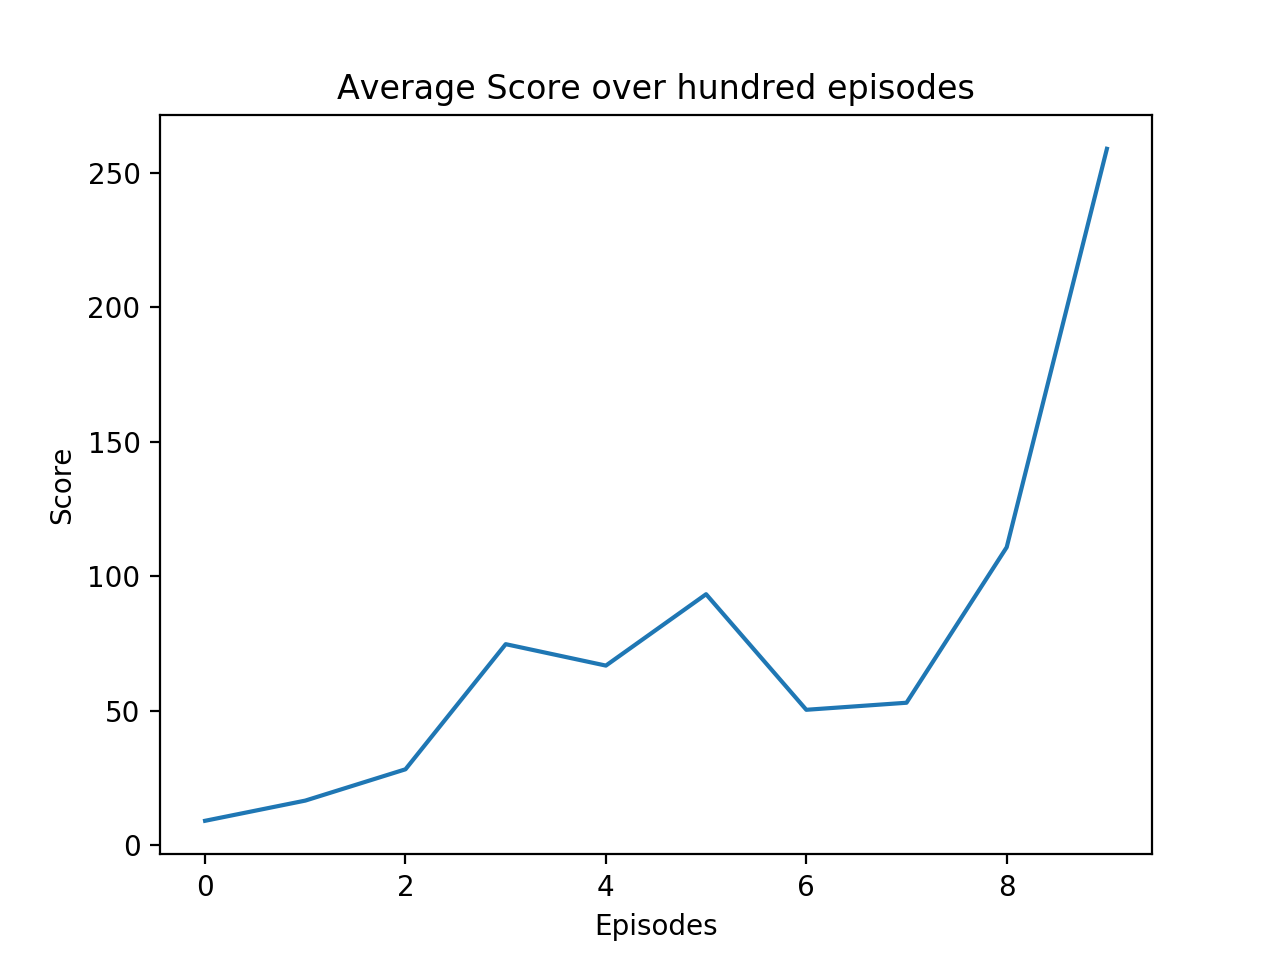

<IPython.core.display.Javascript object>


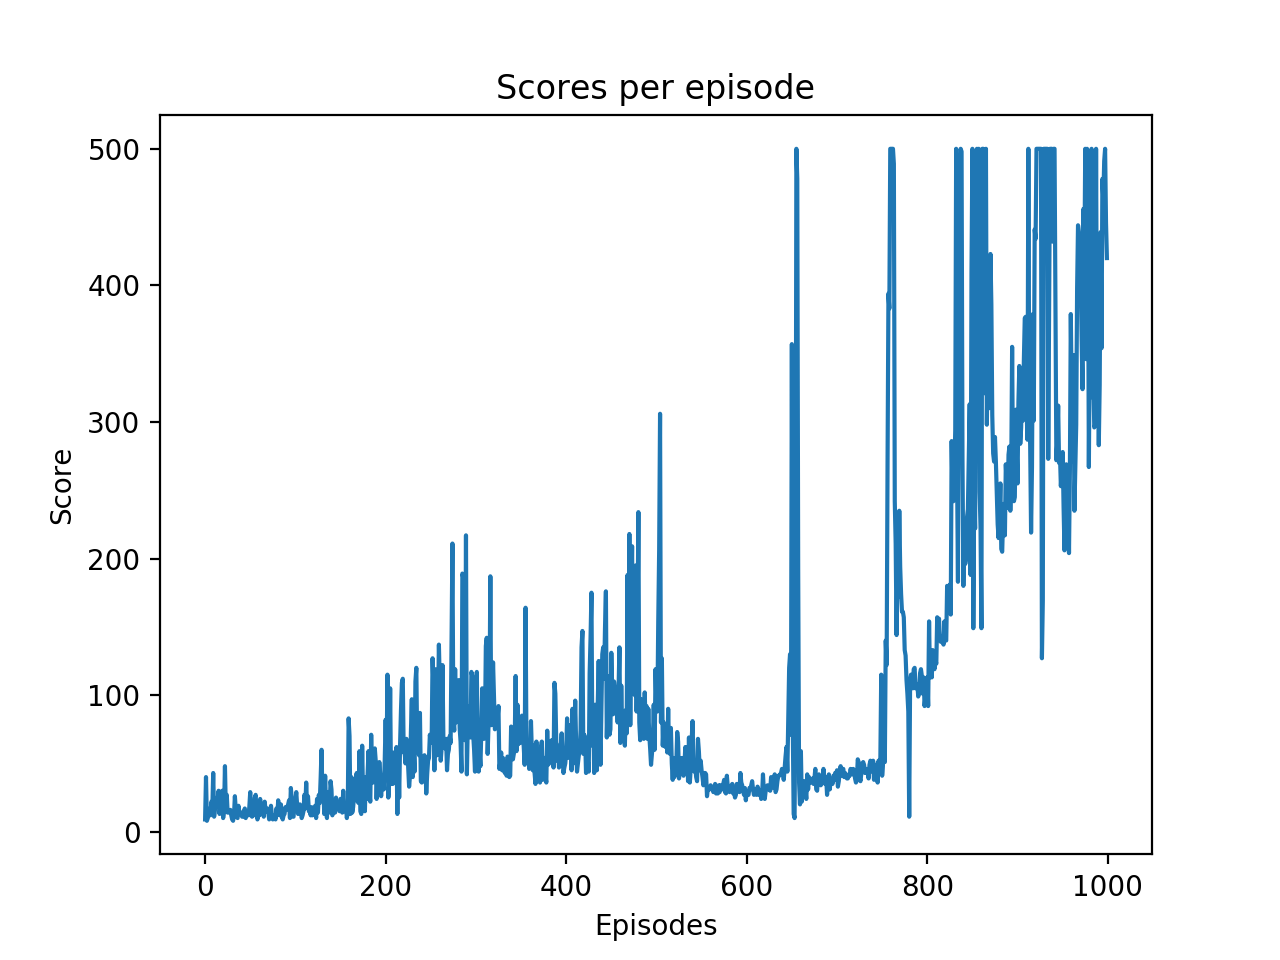

Text(0.5,1,'Scores per episode')

In [26]:
%matplotlib notebook
plt.figure()
plt.plot(averageScoreAC)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.figure()
plt.plot(scoresAC)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per episode')

#### Comparison between all the policy gradient algorithms implemented

<IPython.core.display.Javascript object>


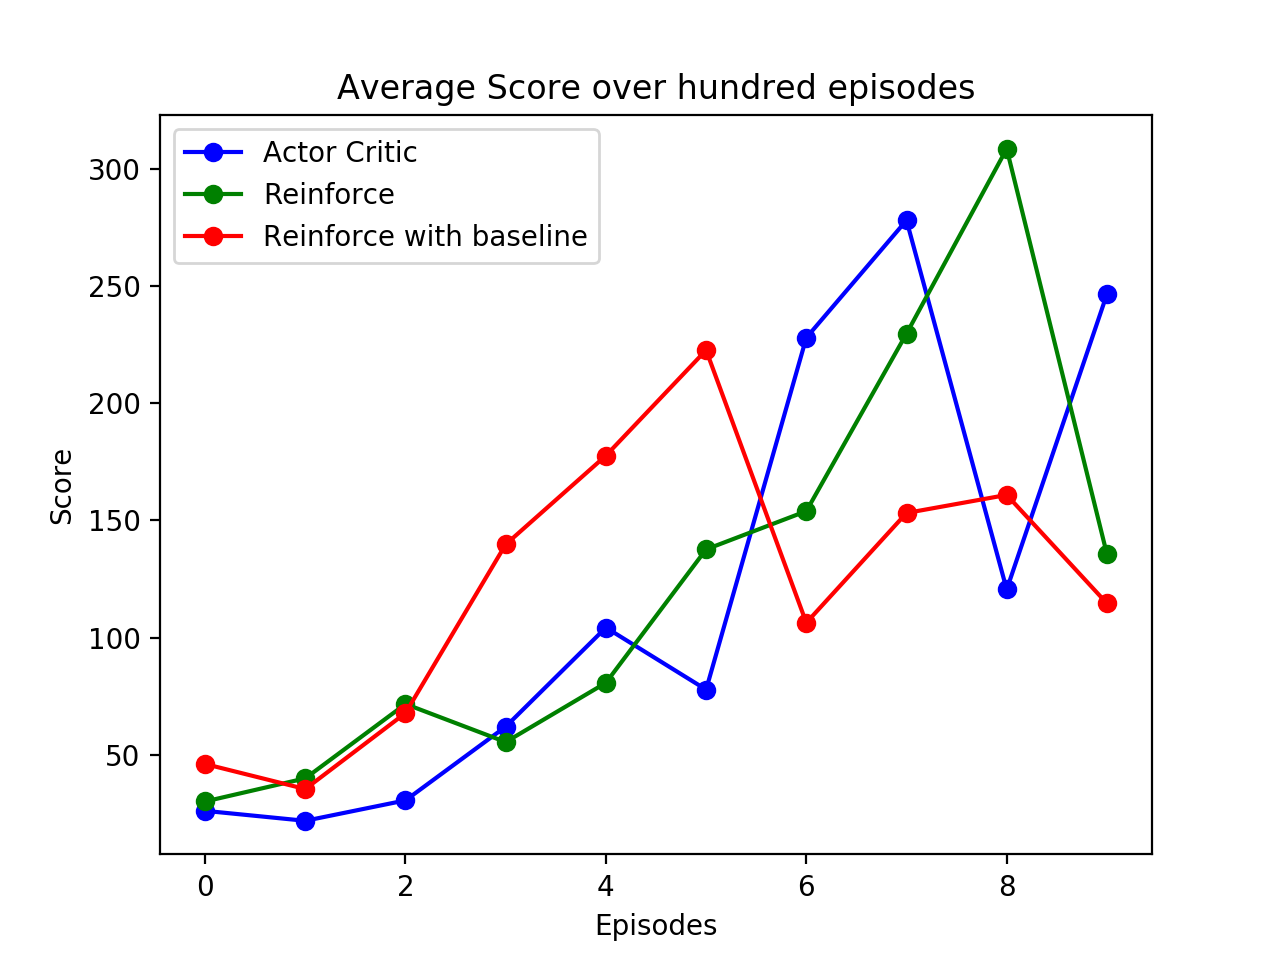

In [24]:
##For first run of all the algorithms
%matplotlib notebook
plt.figure()
plt.plot(averageScoreAC,color='blue',marker='o',label='Actor Critic')
plt.plot(averageScoreReinforce,color='green',marker='o',label='Reinforce')
plt.plot(averageScoreReinforceBaseline,color='red',marker='o',label='Reinforce with baseline')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.legend()

<IPython.core.display.Javascript object>


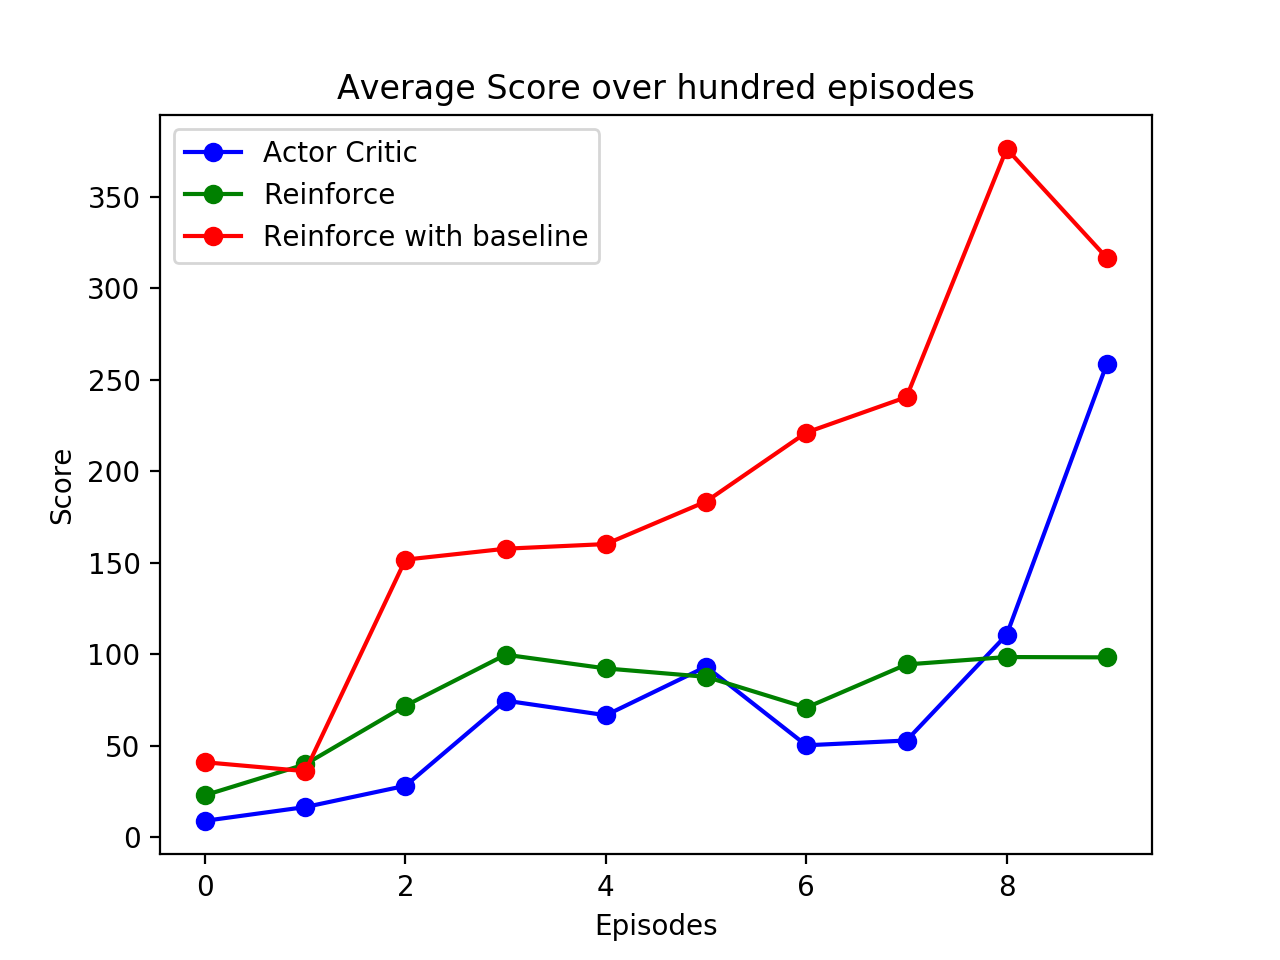

In [27]:
##For second run of all the algorithms
%matplotlib notebook
plt.figure()
plt.plot(averageScoreAC,color='blue',marker='o',label='Actor Critic')
plt.plot(averageScoreReinforce,color='green',marker='o',label='Reinforce')
plt.plot(averageScoreReinforceBaseline,color='red',marker='o',label='Reinforce with baseline')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.legend()

#### Comparison between all the algorithms implemented

<IPython.core.display.Javascript object>


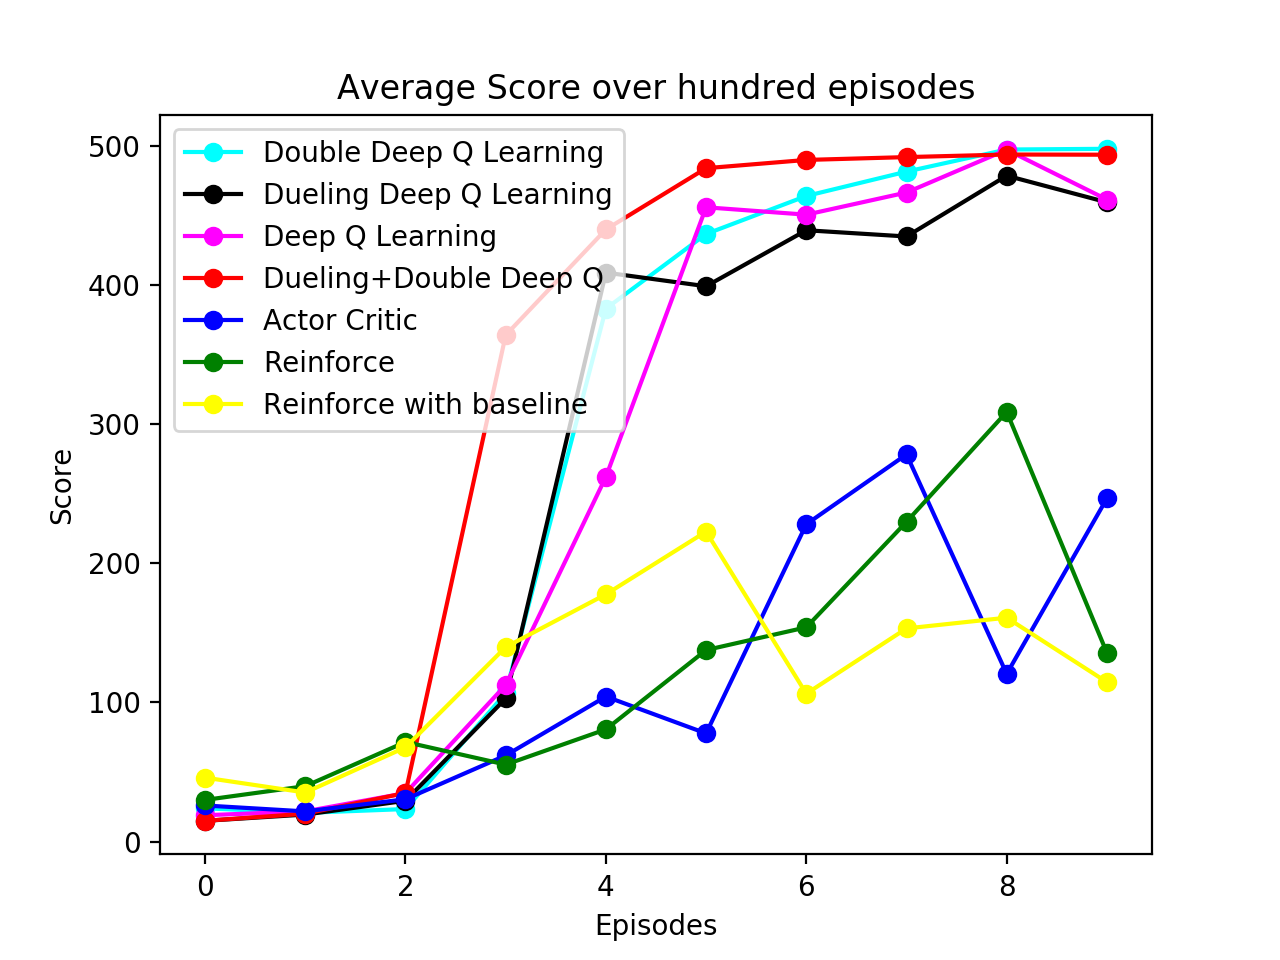

In [25]:
##For first run of all the algorithms
%matplotlib notebook
plt.figure()
plt.plot(averageScoreDouble,color='cyan',marker='o',label='Double Deep Q Learning')
plt.plot(averageScoreDuel,color='black',marker='o',label='Dueling Deep Q Learning')
plt.plot(averageScoreDeepQ,color='magenta',marker='o',label='Deep Q Learning')
plt.plot(averageScoreDoubleDuel,color='red',marker='o',label='Dueling+Double Deep Q')
plt.plot(averageScoreAC,color='blue',marker='o',label='Actor Critic')
plt.plot(averageScoreReinforce,color='green',marker='o',label='Reinforce')
plt.plot(averageScoreReinforceBaseline,color='yellow',marker='o',label='Reinforce with baseline')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.legend()

<IPython.core.display.Javascript object>


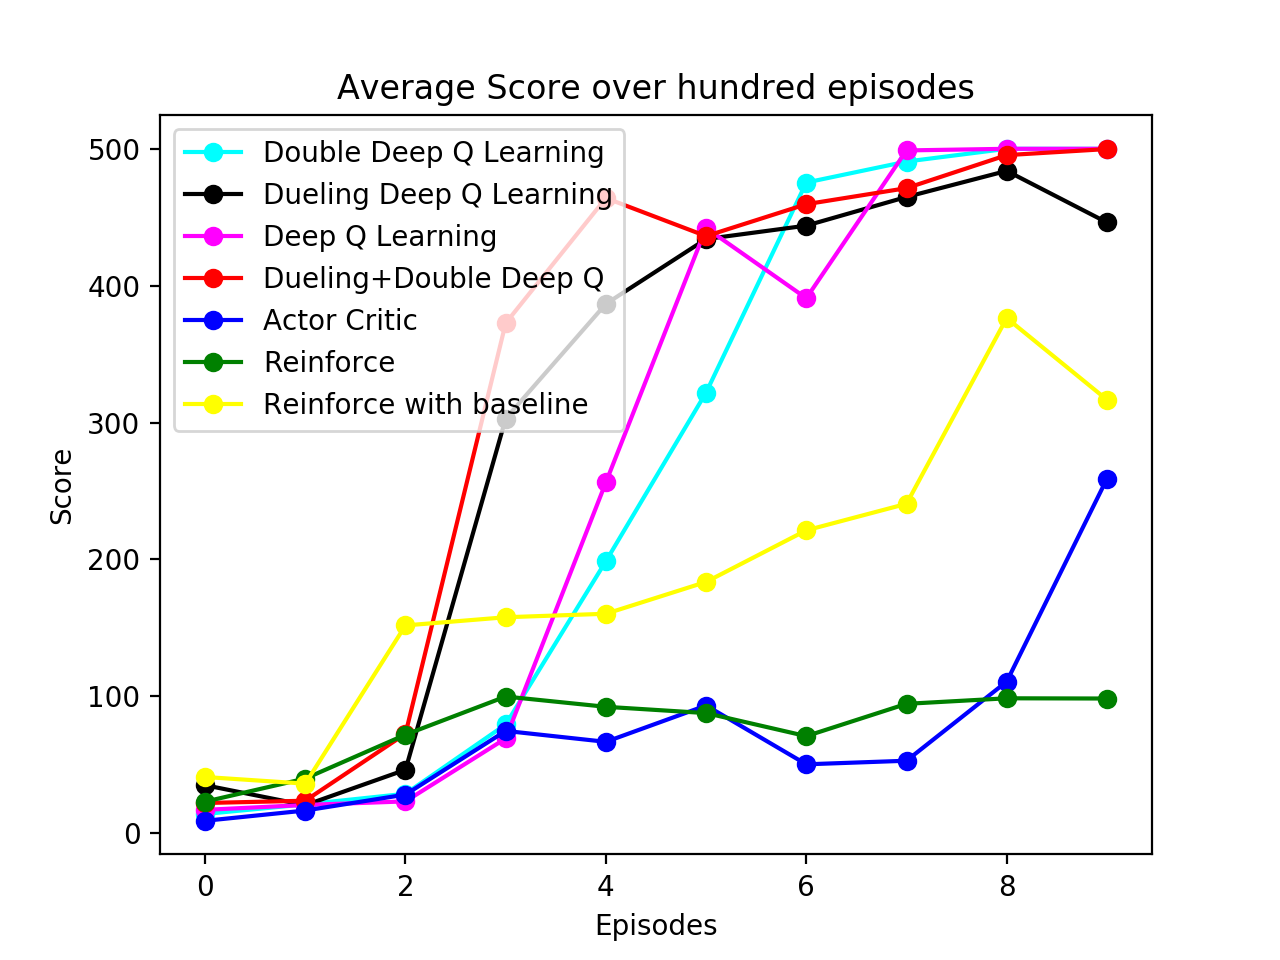

In [28]:
##For second run of all the algorithms
%matplotlib notebook
plt.figure()
plt.plot(averageScoreDouble,color='cyan',marker='o',label='Double Deep Q Learning')
plt.plot(averageScoreDuel,color='black',marker='o',label='Dueling Deep Q Learning')
plt.plot(averageScoreDeepQ,color='magenta',marker='o',label='Deep Q Learning')
plt.plot(averageScoreDoubleDuel,color='red',marker='o',label='Dueling+Double Deep Q')
plt.plot(averageScoreAC,color='blue',marker='o',label='Actor Critic')
plt.plot(averageScoreReinforce,color='green',marker='o',label='Reinforce')
plt.plot(averageScoreReinforceBaseline,color='yellow',marker='o',label='Reinforce with baseline')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Average Score over hundred episodes')
plt.legend()

### Closing Remarks:
From the above plots we can conclude and say that the Dueling Architectures are able to give better results on average as compared to the other Deep Q Learning techniques and i found that combining the dueling architecture with double deep q learning gives the best result at almost every run.

The policy gradient techniques do not give that promising results as compared to the deep Q learning frameworks,one of the possible reasons for this is that the policy gradient techniques seems to suffer from high variance problem as it does not use a replay memory hence we can see sudden drops and rises in the scores when using policy gradient techniques but even then the reinforce with baseline and actor critic methods show really promising results as on some runs these methods are able to achieve the highest score possible in the environment and also being able to solve the environment(get the score that is considered as solving the environment) on all runs.

During these executions i have not tuned the hyperparameters and chosen random hyperparameters that seemed to work well or parameters values that are used in general,to get better results one could also try to search for hyperparameters that give better results like faster learning etc.